In [11]:
#filename = "data/2021018ISA_data_from_Steve/LCMS01.txt" #path to datafile
filename = "data/brain1.txt" #path to datafile
#filename = "data/2021018ISA_data_from_Steve/101.txt" #path to datafile

formula = "C16H32O2"
#formula = "C18H36O2"
#formula = "C14H28O2" #formula for product molecule
 
polarity = -1 #ionization polarity (1 = pos, -1 = neg)
ppmThresh = 20 #m/z tolerance, all peaks within ppmThresh ppm will be summed into one feature
convSquare = 1 #size of filter (1=1x1,3=3x3,5=5x5)
convSquarePost = 0 #size of filtering to use post ISA (applied to G, D, and T plots)
colormap = "gray" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
num_cores = 20 #number of processor cores to use
dm_method = "PCA" #method for dimensionality reduction ("PCA" or "TSNE") PCA has worked better for me
seg_method = "K_means" #thresholding method ("TIC_auto", "K_means", "TIC_manual")
num_components = 2 #number of compoents to use with PCA or TSNE
filt = "GB" #filtering method (GB = gaussian blur, MA = moving average)

In [12]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import os
matplotlib.rcParams['figure.dpi'] = 100
import helper
import molmass
from PIL import Image
from multiprocessing import Pool
import importlib
importlib.reload(helper)
import zipfile
from sklearn.metrics import r2_score

def getISAEq(numCarbons):
    d = {16:helper.palmitateISA,14:helper.myristicISA,18:helper.stearicISA}
    return d[numCarbons]

In [13]:
#not used anymore
height = 230 #desired number of rows in output image
width = 160 #desired number of columns in output image

#get formulas
f = molmass.Formula(formula) #create formula object
m0Mz = f.isotope.mass #get monoisotopcic mass for product ion
adductChange = polarity * 1.0077276 #calculate adduct m/z

#get number of carbons
comp = f.composition()
for row in comp:
    if row[0] == "C":
        numCarbons = int(row[1])

func = getISAEq(numCarbons) #get relevant ISA equation

#load in data and organize
data = [r.strip().split() for r in open(filename,"r").readlines()[3:]]
data = {(x[0],float(x[1]),float(x[2])):{mz:float(i) for mz,i in zip(data[0],x[3:])} for x in data[1:] if len(x) > 0}
data = pd.DataFrame.from_dict(data,orient="index")
cols = data.columns.values
mzs = cols


#get mzs of interest
mzsOI = [m0Mz+adductChange+1.00336*x for x in range(numCarbons+1)]
mzMatchDict = {i:{"true":m,"observed":[],"matched":False} for m,i in zip(mzsOI,range(len(mzsOI)))}

#find matching peaks in data and output found and missing peaks
for m,i in zip(mzsOI,range(len(mzsOI))):
    matched = False
    for m2 in mzs:
        tmpM2 = float(m2)
        if abs(m-tmpM2) / m * 1e6 < ppmThresh:
            mzMatchDict[i]["observed"].append(m2)
            mzMatchDict[i]["matched"] = True
            matched = True
            break
    if not matched:
        print("missed",m)
    else:
        print("found",m,mzMatchDict[i]["observed"])


found 255.23250267049997 ['255.2323']
found 256.23586267049996 ['256.2357']
found 257.23922267049994 ['257.2376']
found 258.2425826705 ['258.2400']
found 259.24594267049997 ['259.2431']
found 260.24930267049996 ['260.2474']
found 261.25266267049994 ['261.2514']
found 262.2560226705 ['262.2550']
found 263.2593826705 ['263.2583']
found 264.26274267049996 ['264.2615']
found 265.26610267049995 ['265.2651']
found 266.2694626705 ['266.2690']
found 267.2728226705 ['267.2719']
found 268.27618267049996 ['268.2757']
found 269.27954267049995 ['269.2795']
found 270.2829026705 ['270.2830']
found 271.2862626705 ['271.2857']


In [14]:
#gather images for mzs of interest 
tensor = []
for mz in range(numCarbons+1):
    #iterate through mzs of interest
    if mzMatchDict[mz]["matched"]:   
        outarray = np.sum(np.array([helper.getImage(data,x,height,width) for x in mzMatchDict[mz]["observed"]]),axis=0)
        height = len(outarray)
        width = len(outarray[0])
    else:
        outarray = np.zeros((height,width))
    tensor.append(outarray)

tensor = np.array(tensor)

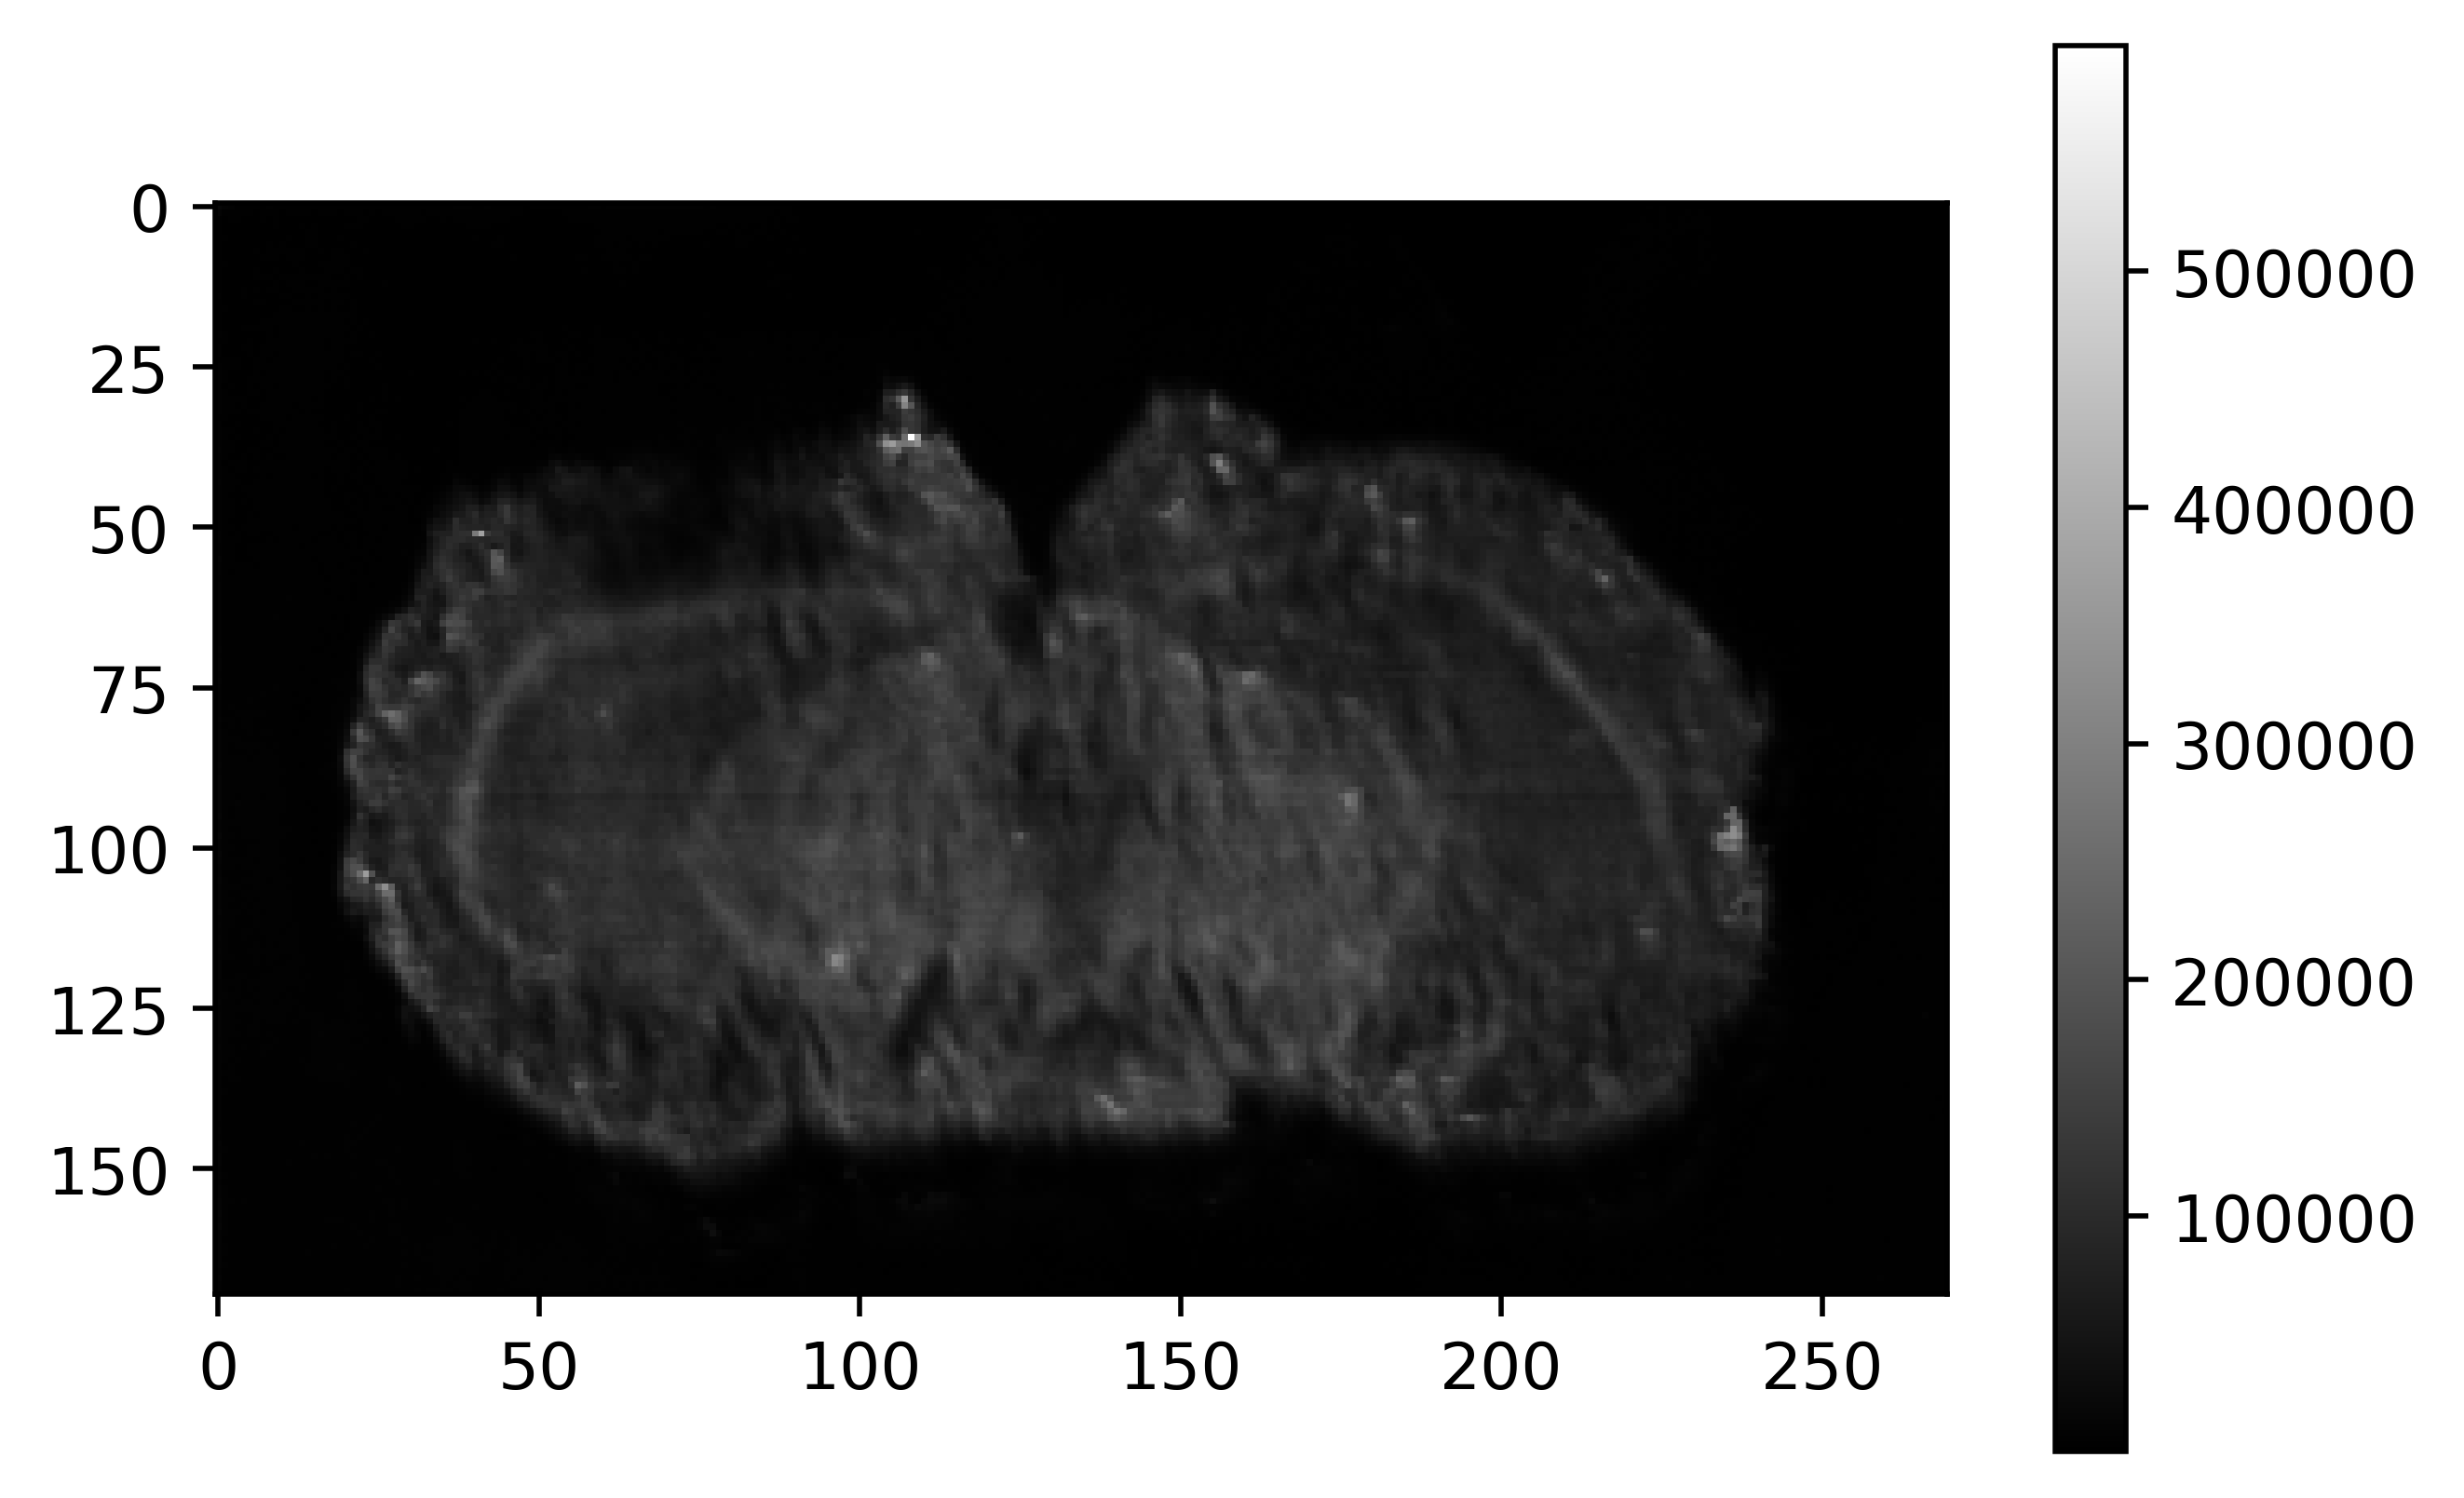

<Figure size 3000x2000 with 0 Axes>

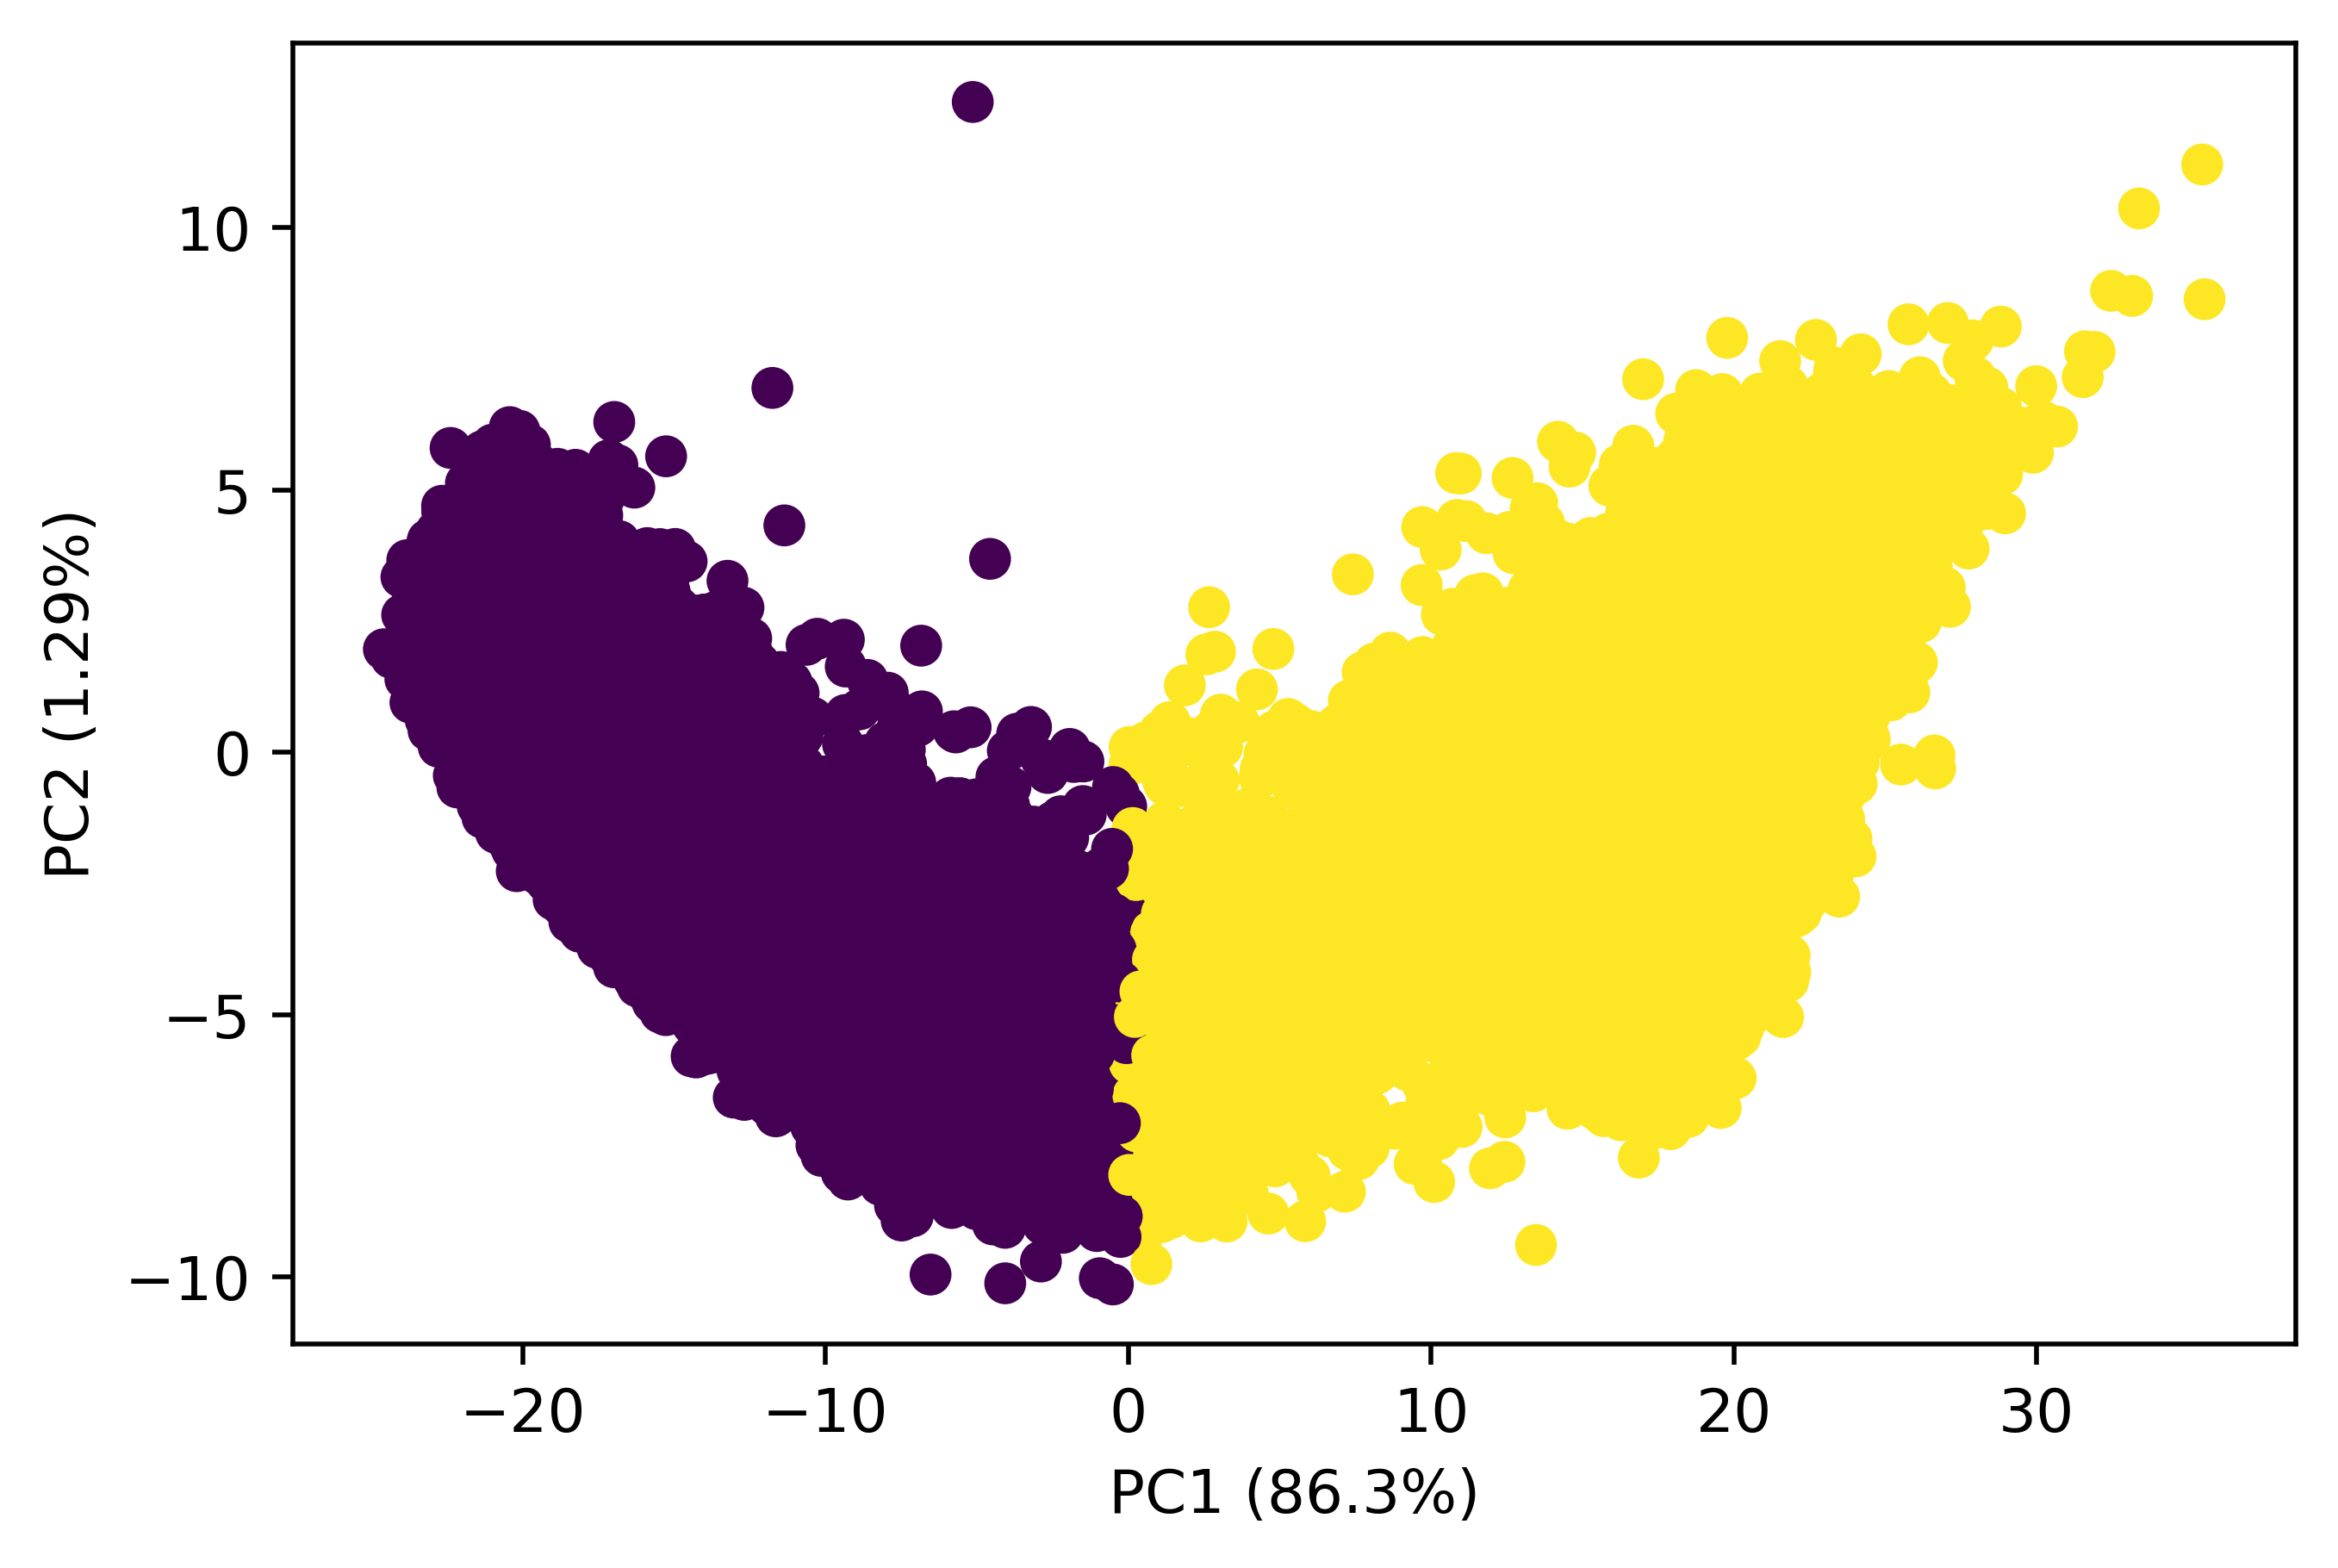

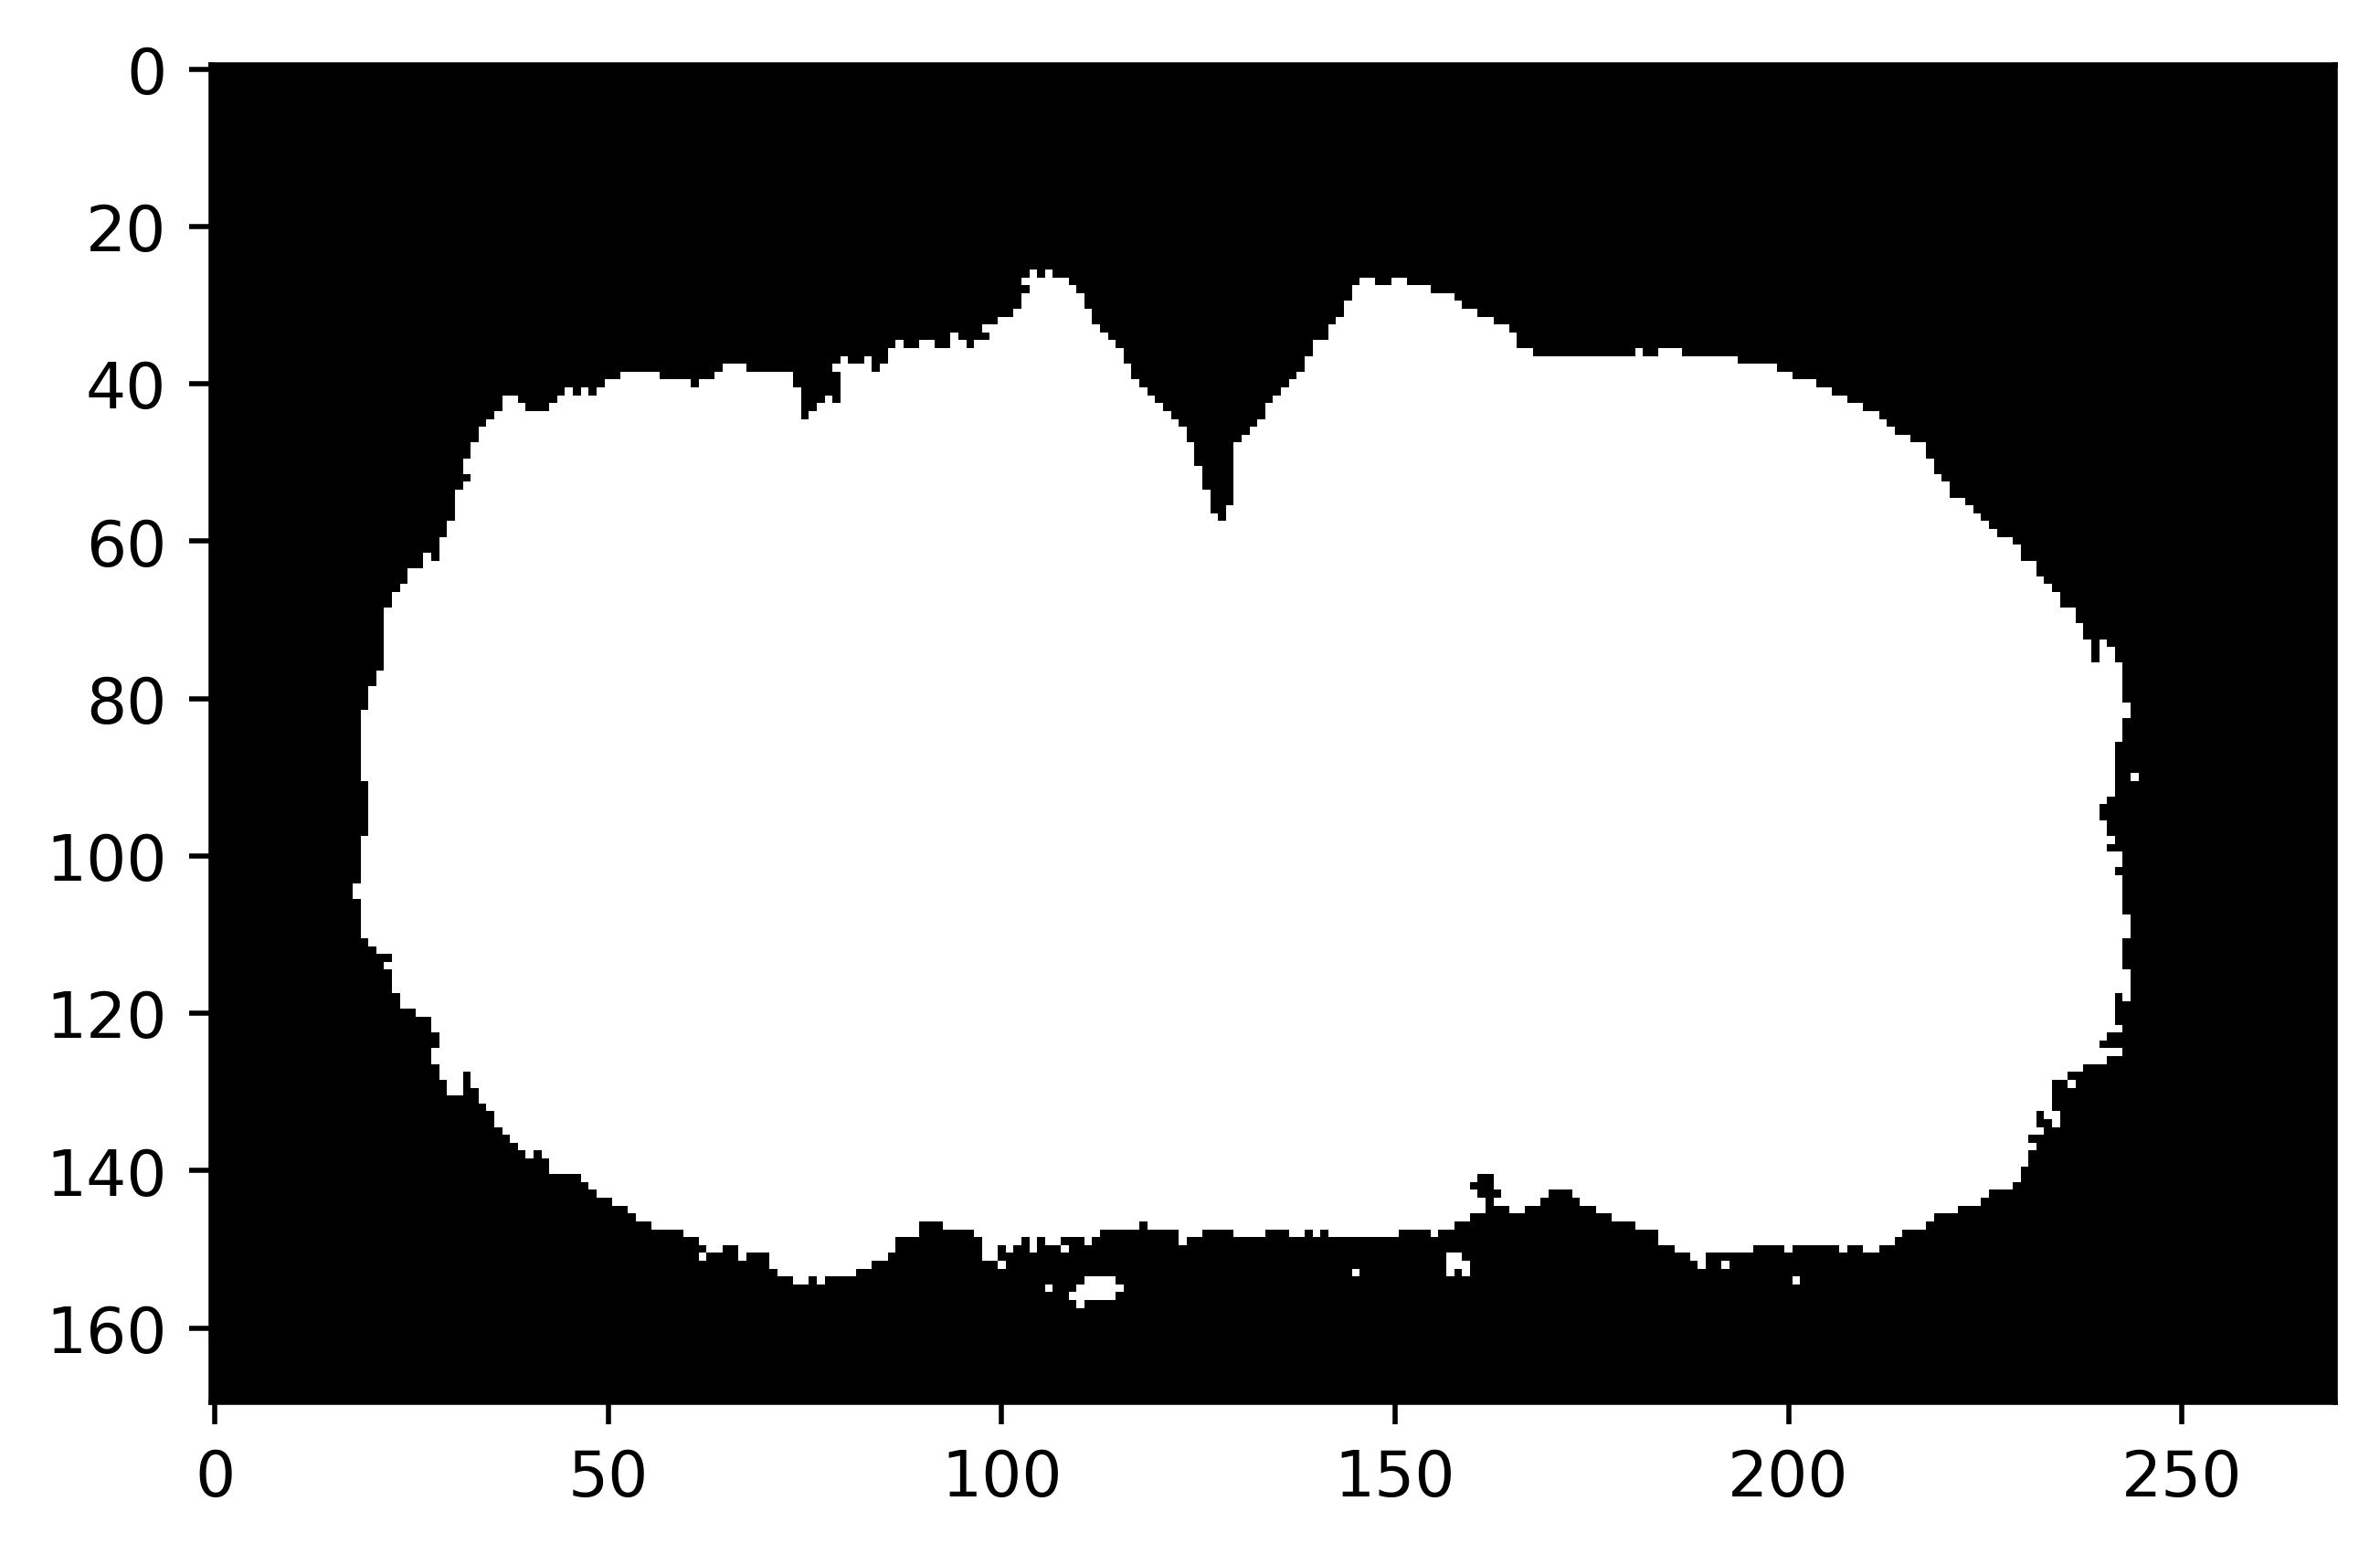

In [15]:
#get thresholded image to define sample boundary

imageBoundary = helper.segmentImage(data,height,width,mzs,colormap,method=seg_method,dm_method=dm_method,num_latent=num_components)

plt.figure()

#show masked image
plt.imshow(imageBoundary,cmap=colormap)

In [16]:

#apply moving average filter
offset = int((convSquare-1)/2)
tensorFilt = np.zeros((len(tensor),height-2*offset,width-2*offset)) #new tensor for filtered image
newImageBoundary = np.zeros((height-2*offset,width-2*offset)) #new image boundary

if __name__ == "__main__":
    pool = Pool(num_cores)
    tensorFilt = np.array(pool.starmap(helper.convolveLayer,[(offset,height,width,tensor[t],imageBoundary,filt) for t in range(len(tensor))]))
    pool.close()
    pool.join()

#normalize so the sum of the signal = 1
helper.normalizeTensor(tensorFilt)

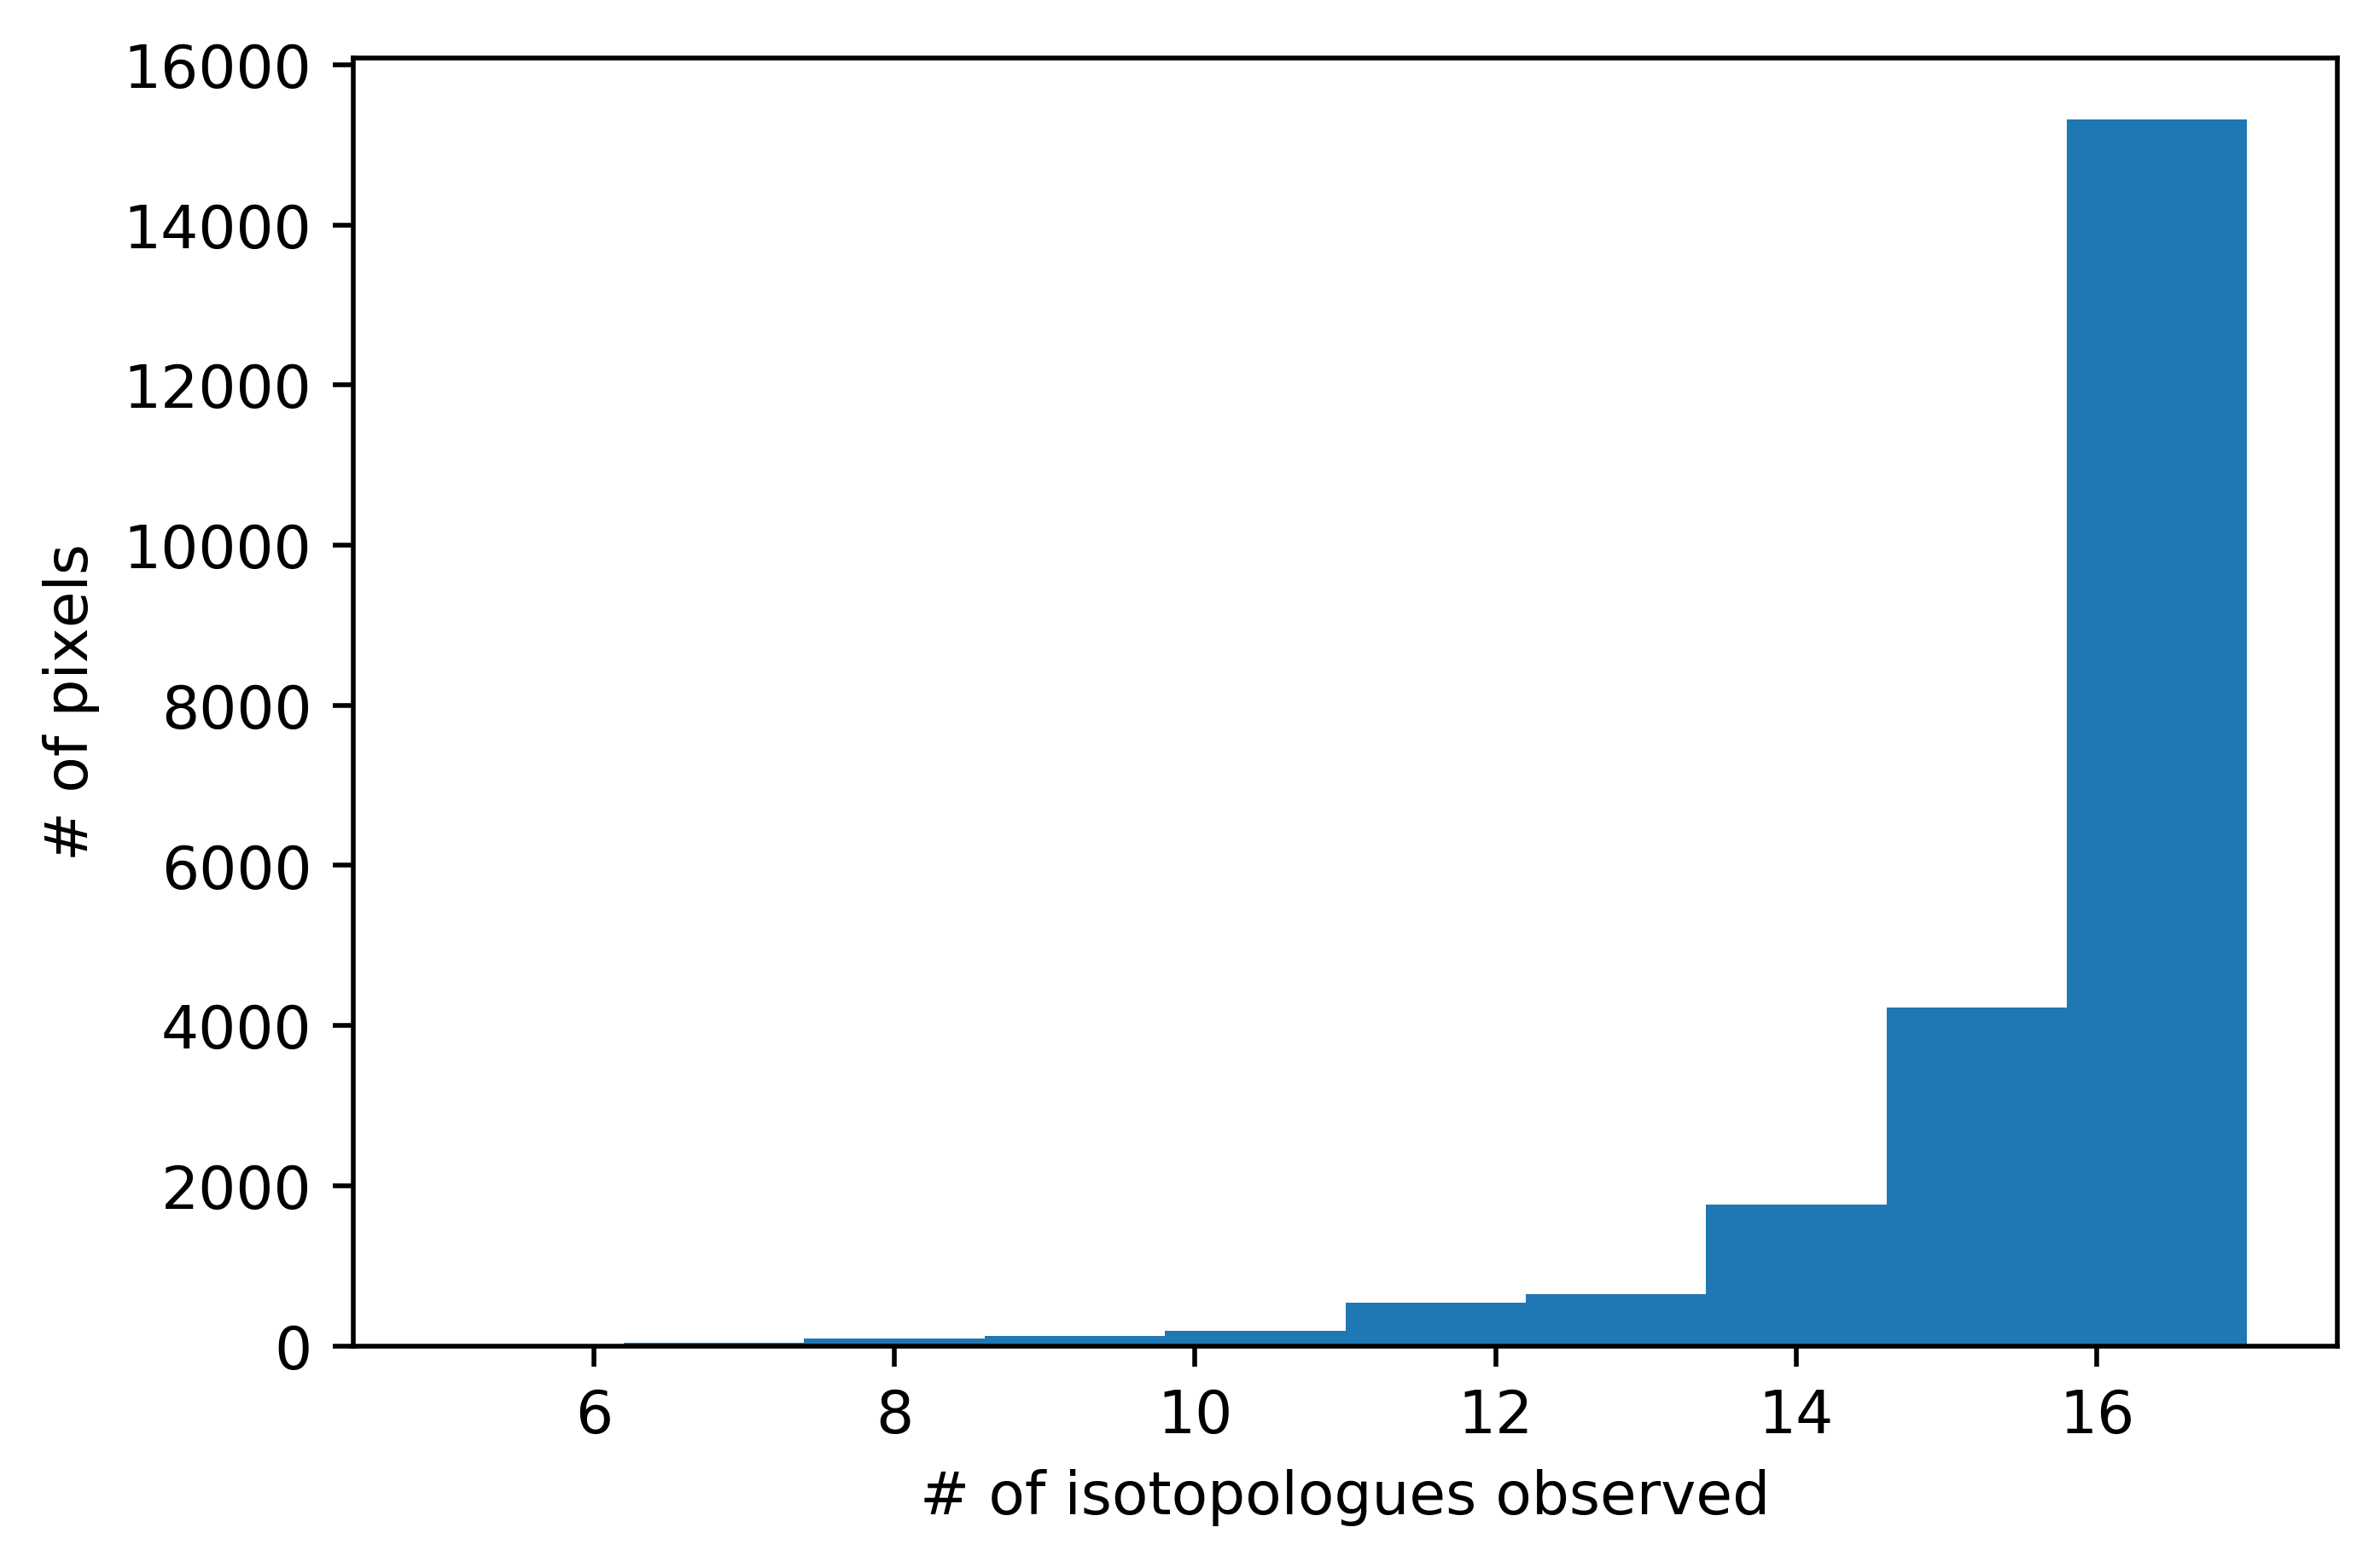

In [17]:
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
T = [0,0,1] #set initial tracer labeling

#create data structures to store output
errs = []
T_founds = []
fluxImageG = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
fluxImageD = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
fluxImageT0 = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
fluxImageT1 = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
fluxImageT2 = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
P_consider = []
P_trues = []
P_preds = []

#do pixel by pixel ISA
argList = []
coords = []

#func = helper.palmitateISA

numFounds = []

for r in range(len(tensorFilt[0])):
    for c in range(len(tensorFilt[0][0])):
        #get product labeling
        P = tensorFilt[:,r,c]

        goodInd = [x for x in range(len(P)) if P[x] > 0]

        #if not on background pixel
        if imageBoundary[r,c] > .5:
            #fit ISA
            numFounds.append(len(goodInd))
            argList.append((T,N,P,numCarbons,goodInd,np.array([.5,.1,.1,.1,.1])))#np.random.random(1)))
            coords.append((r,c))
            P_consider.append(P)
            #break
    #if len(P_consider) > 1:break
            


plt.hist(numFounds)
plt.xlabel("# of isotopologues observed")
plt.ylabel("# of pixels")

if __name__ == "__main__":
    pool = Pool(num_cores)
    results = pool.starmap(helper.ISAFit_nonSS_full,argList)
    pool.close()
    pool.join()

#results = []
#for arg in argList:
#    results.append(helper.ISAFit_nonSS_full(*arg))

for (g,D,T_found,err,P_pred),(r,c),P_true in zip(results,coords,P_consider):
    #save results in data structures
    if g > -.0001 and g < 1.1 and all(xx > -0.01 and xx < 1.1 for xx in T_found):
        errs.append(err)
        T_founds.append(T_found)
        #P_trues.append(P)
        P_preds.append(P_pred)
        P_trues.append(P_true)

        fluxImageG[r,c] = g
        fluxImageD[r,c] = D
        fluxImageT0[r,c] = T_found[0]
        fluxImageT1[r,c] = T_found[1]
        fluxImageT2[r,c] = T_found[2]
    else:
        print(g,D,T_found)

T (mean) =  [0.20412722 0.18703447 0.60883831]


Text(0, 0.5, '# of Pixels')

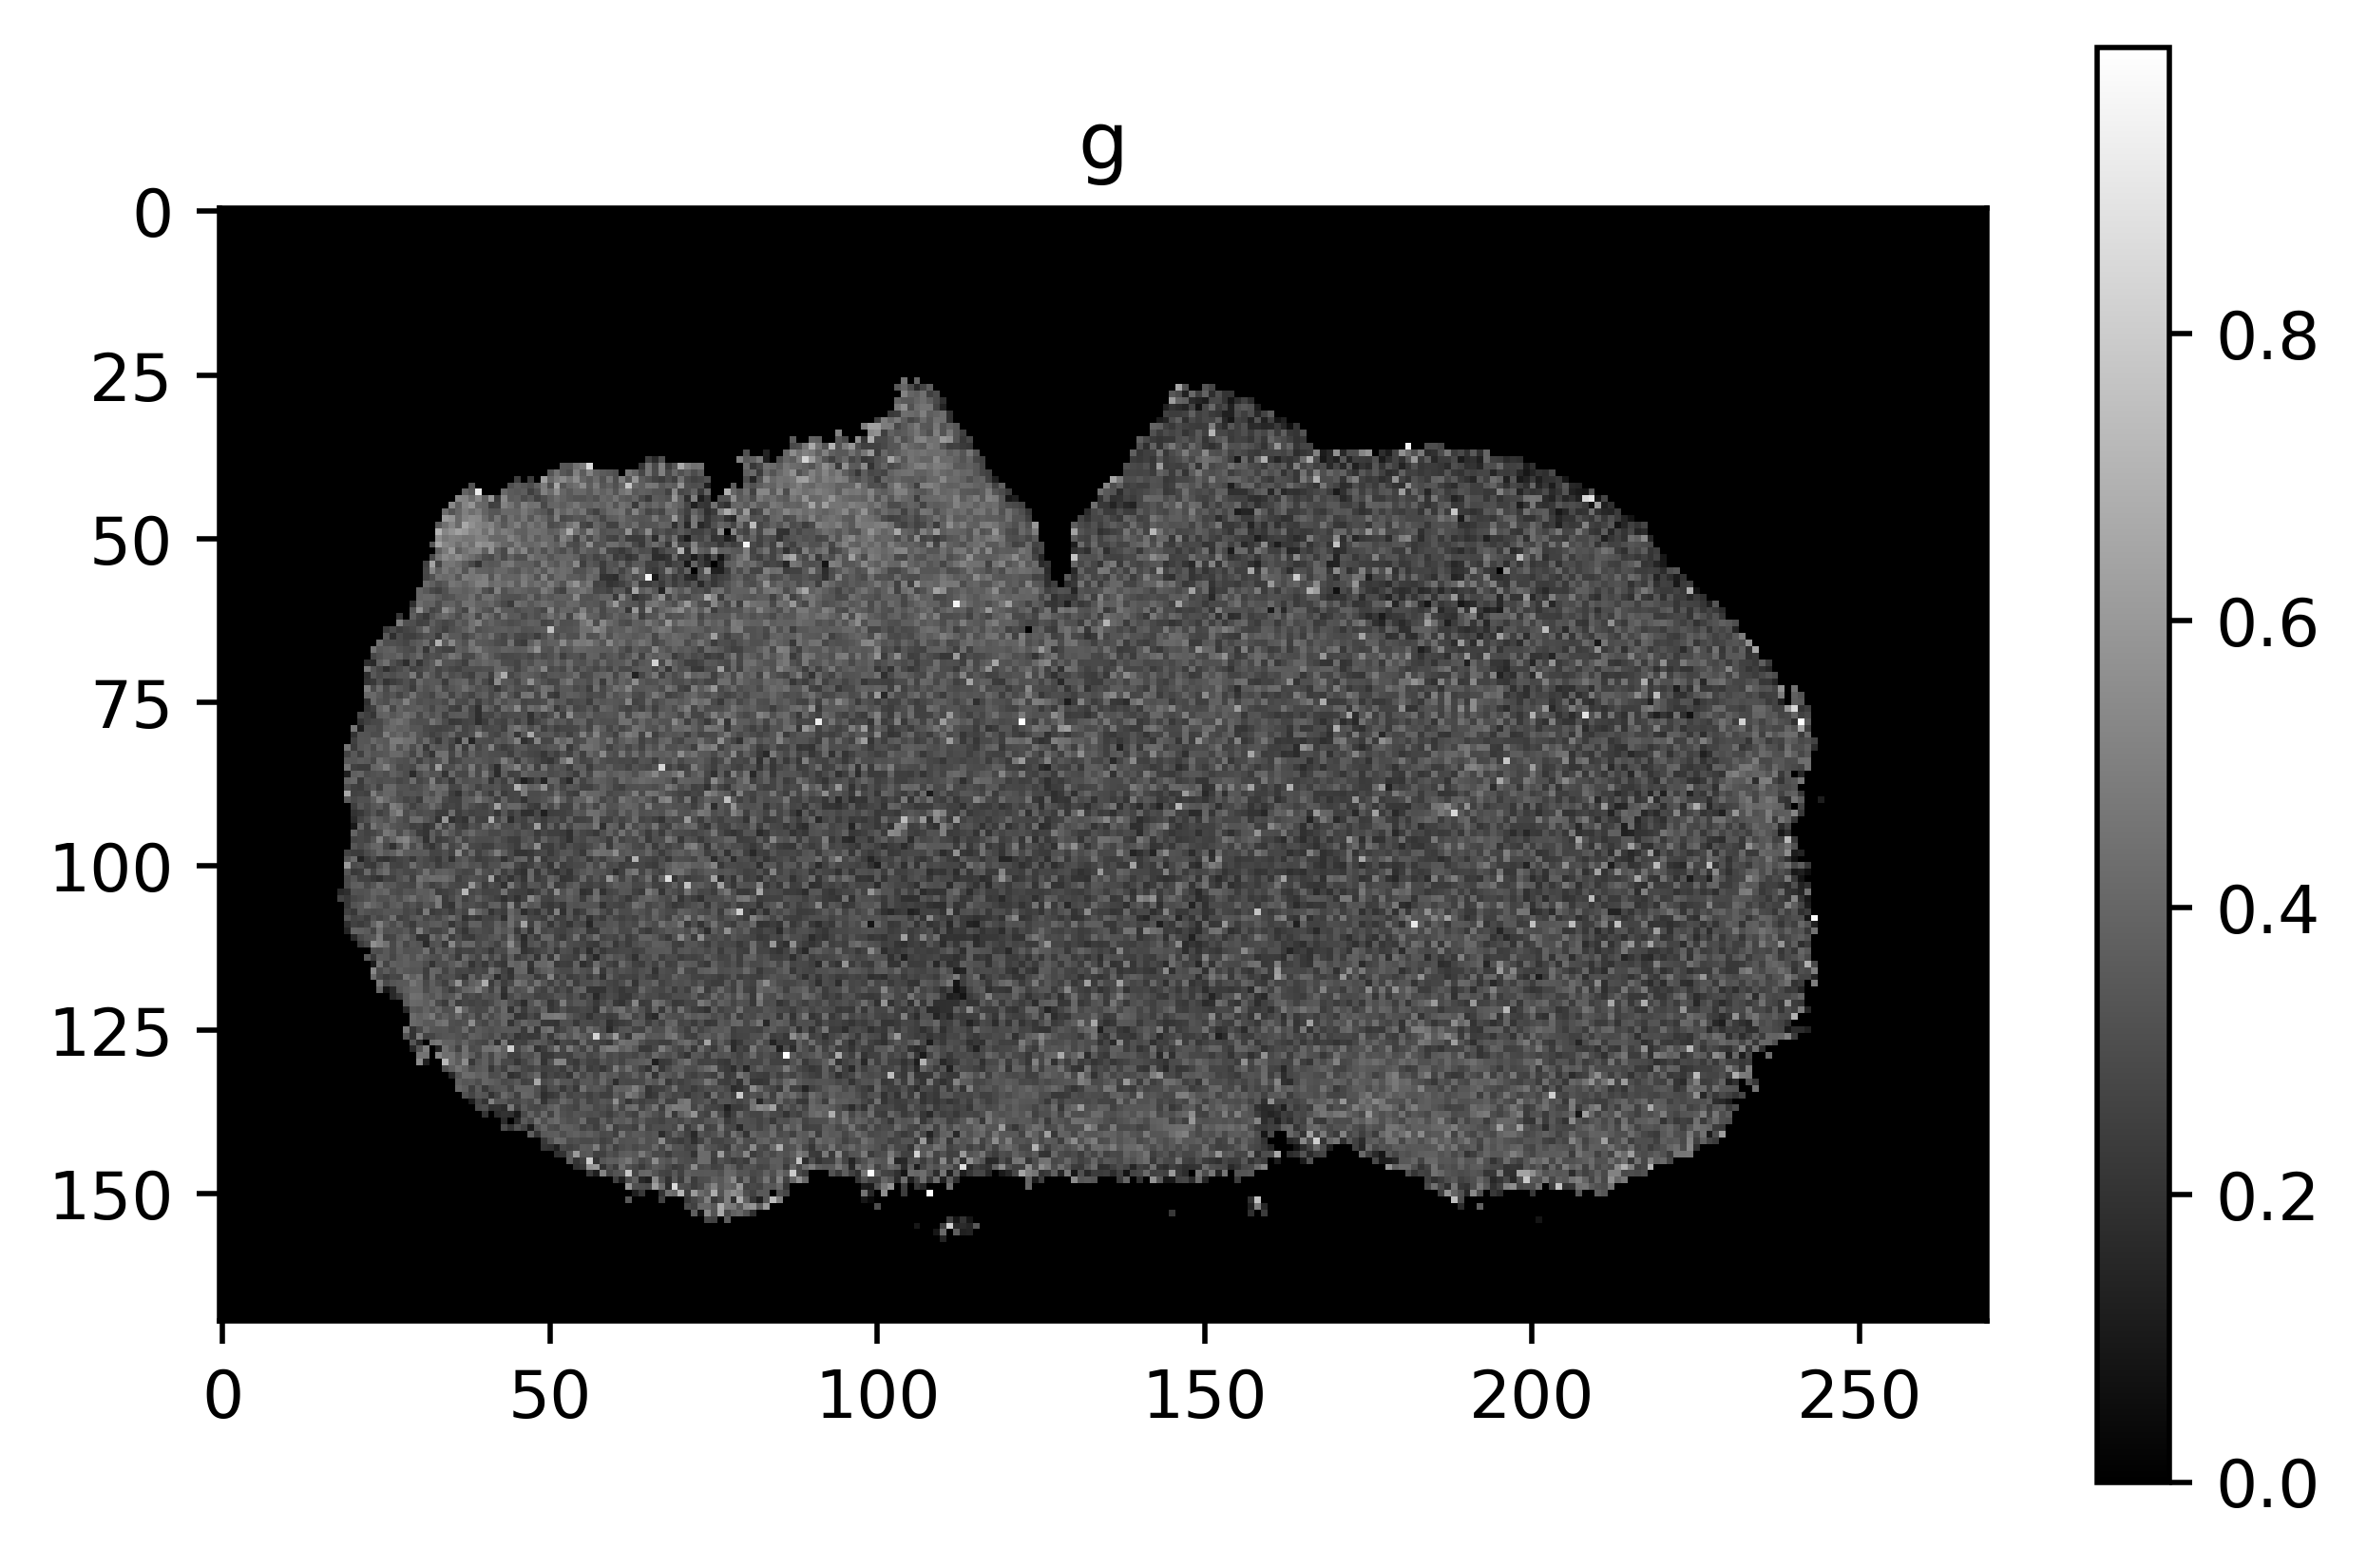

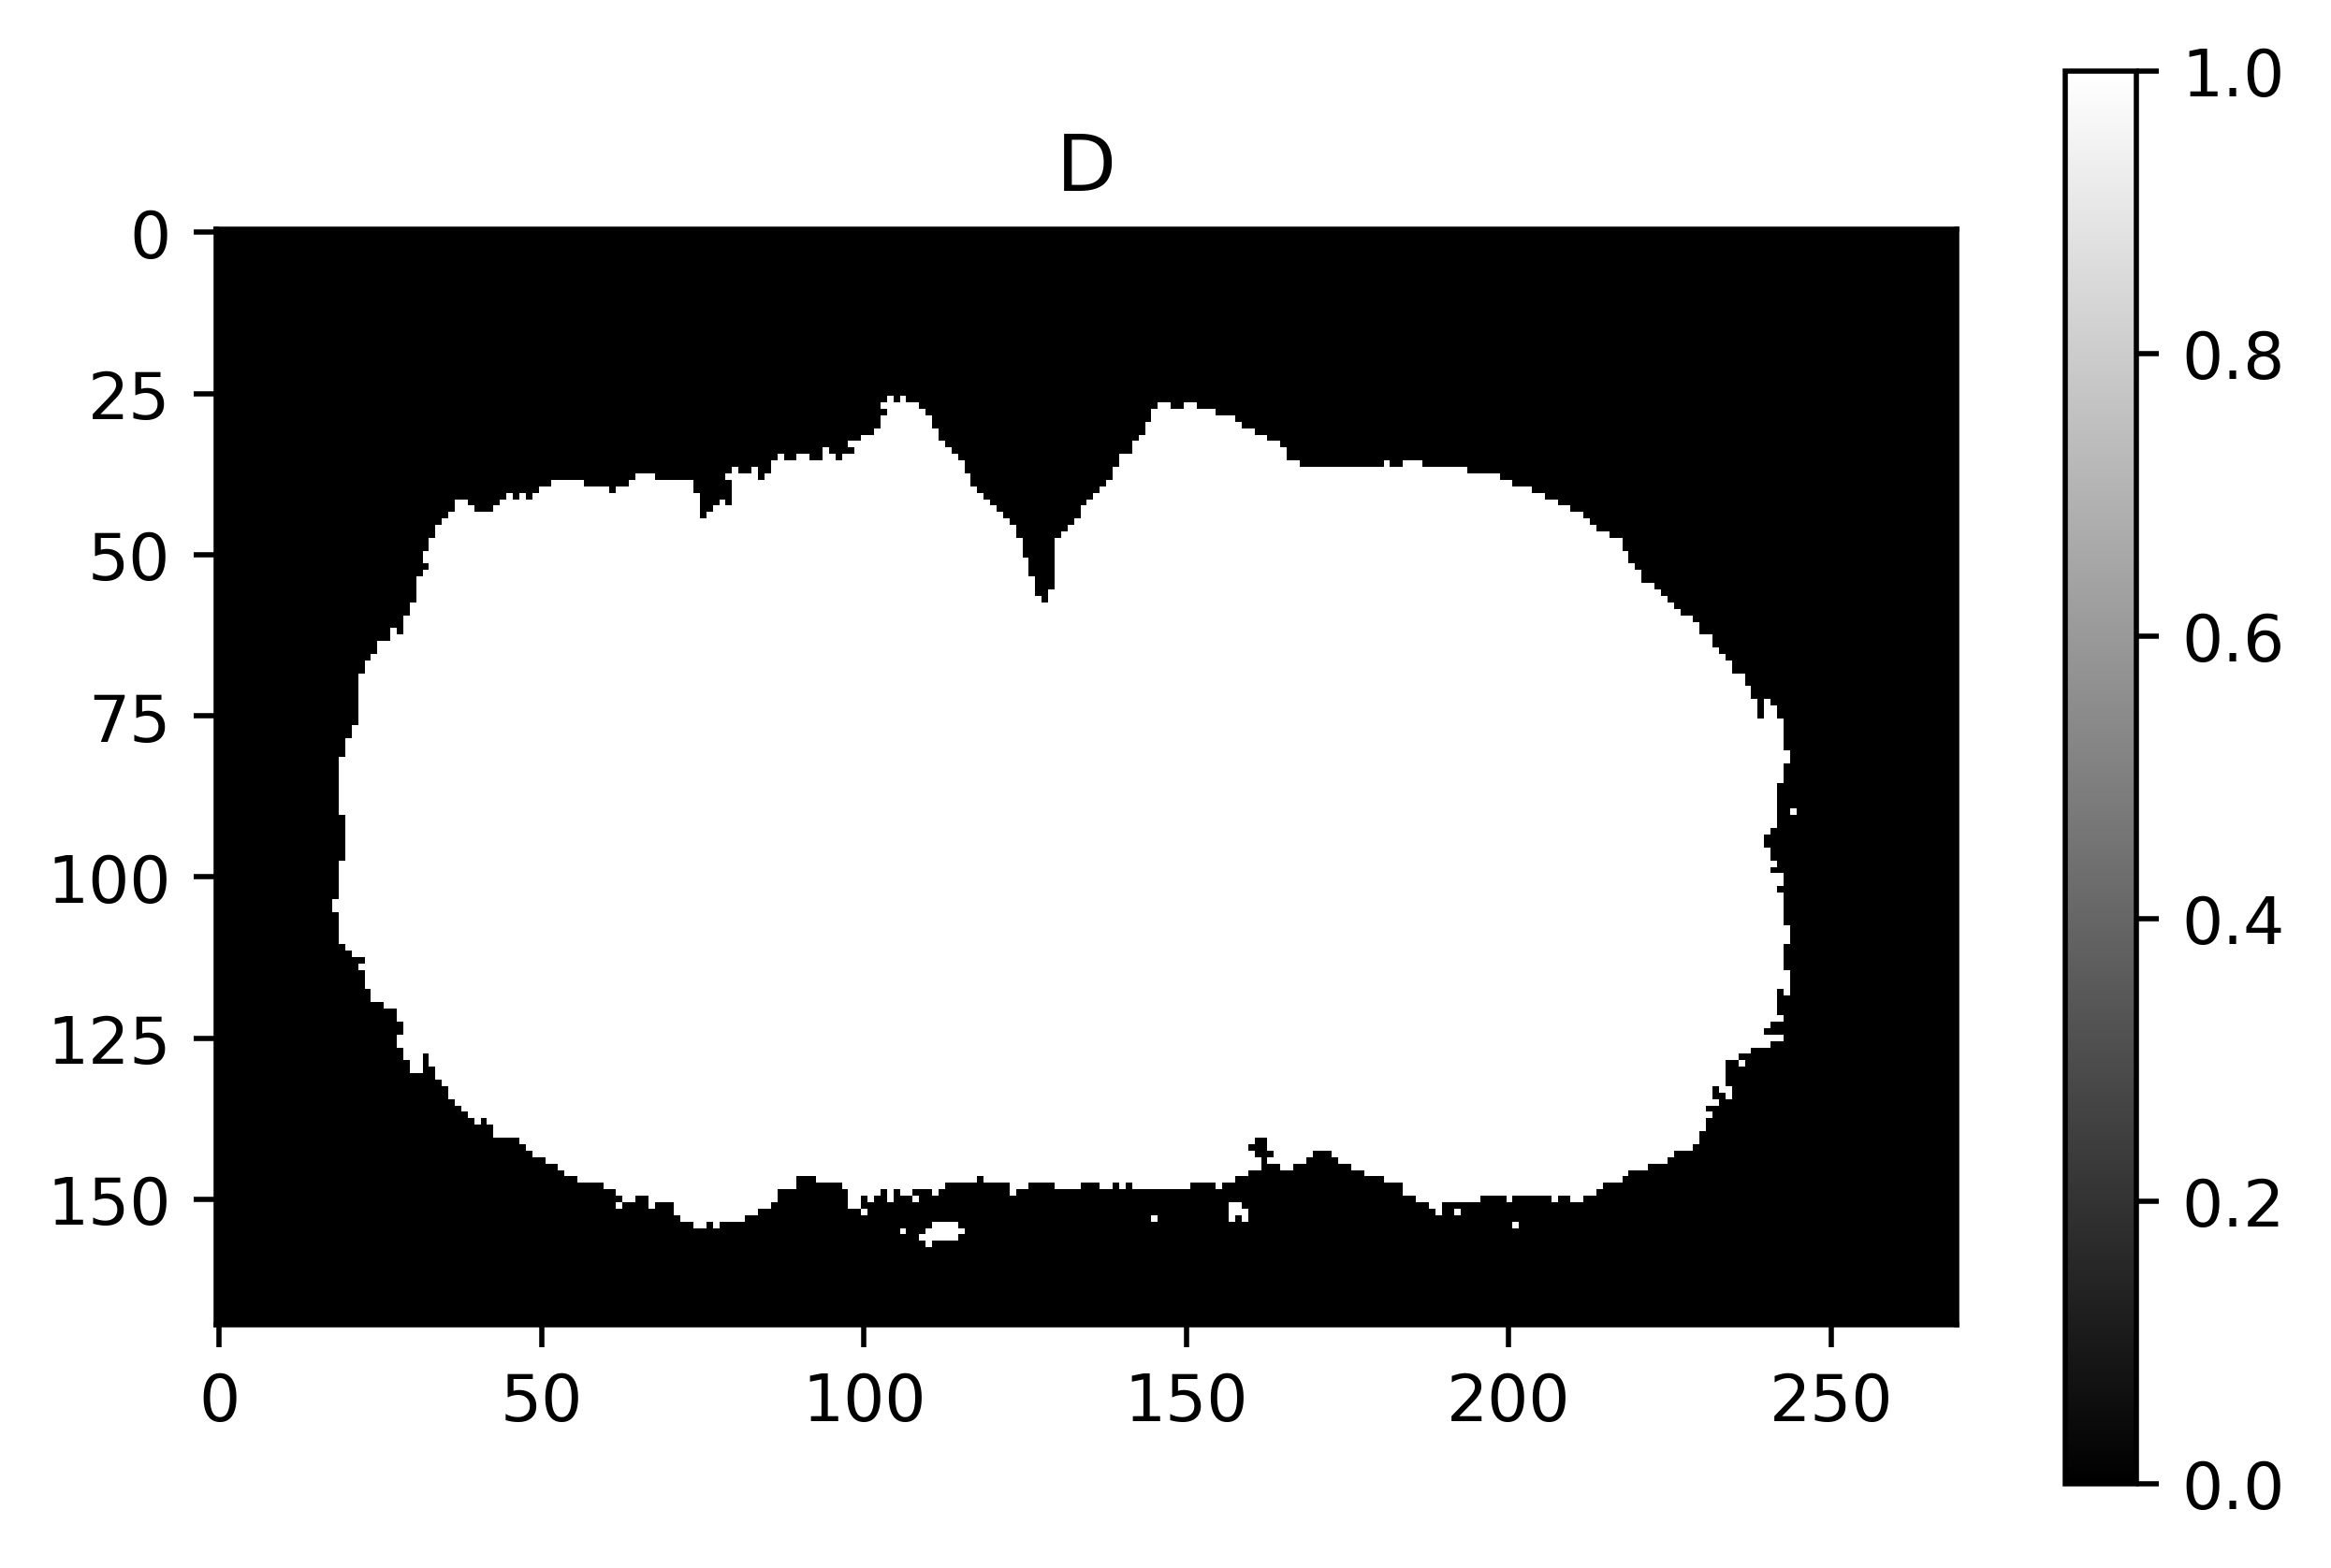

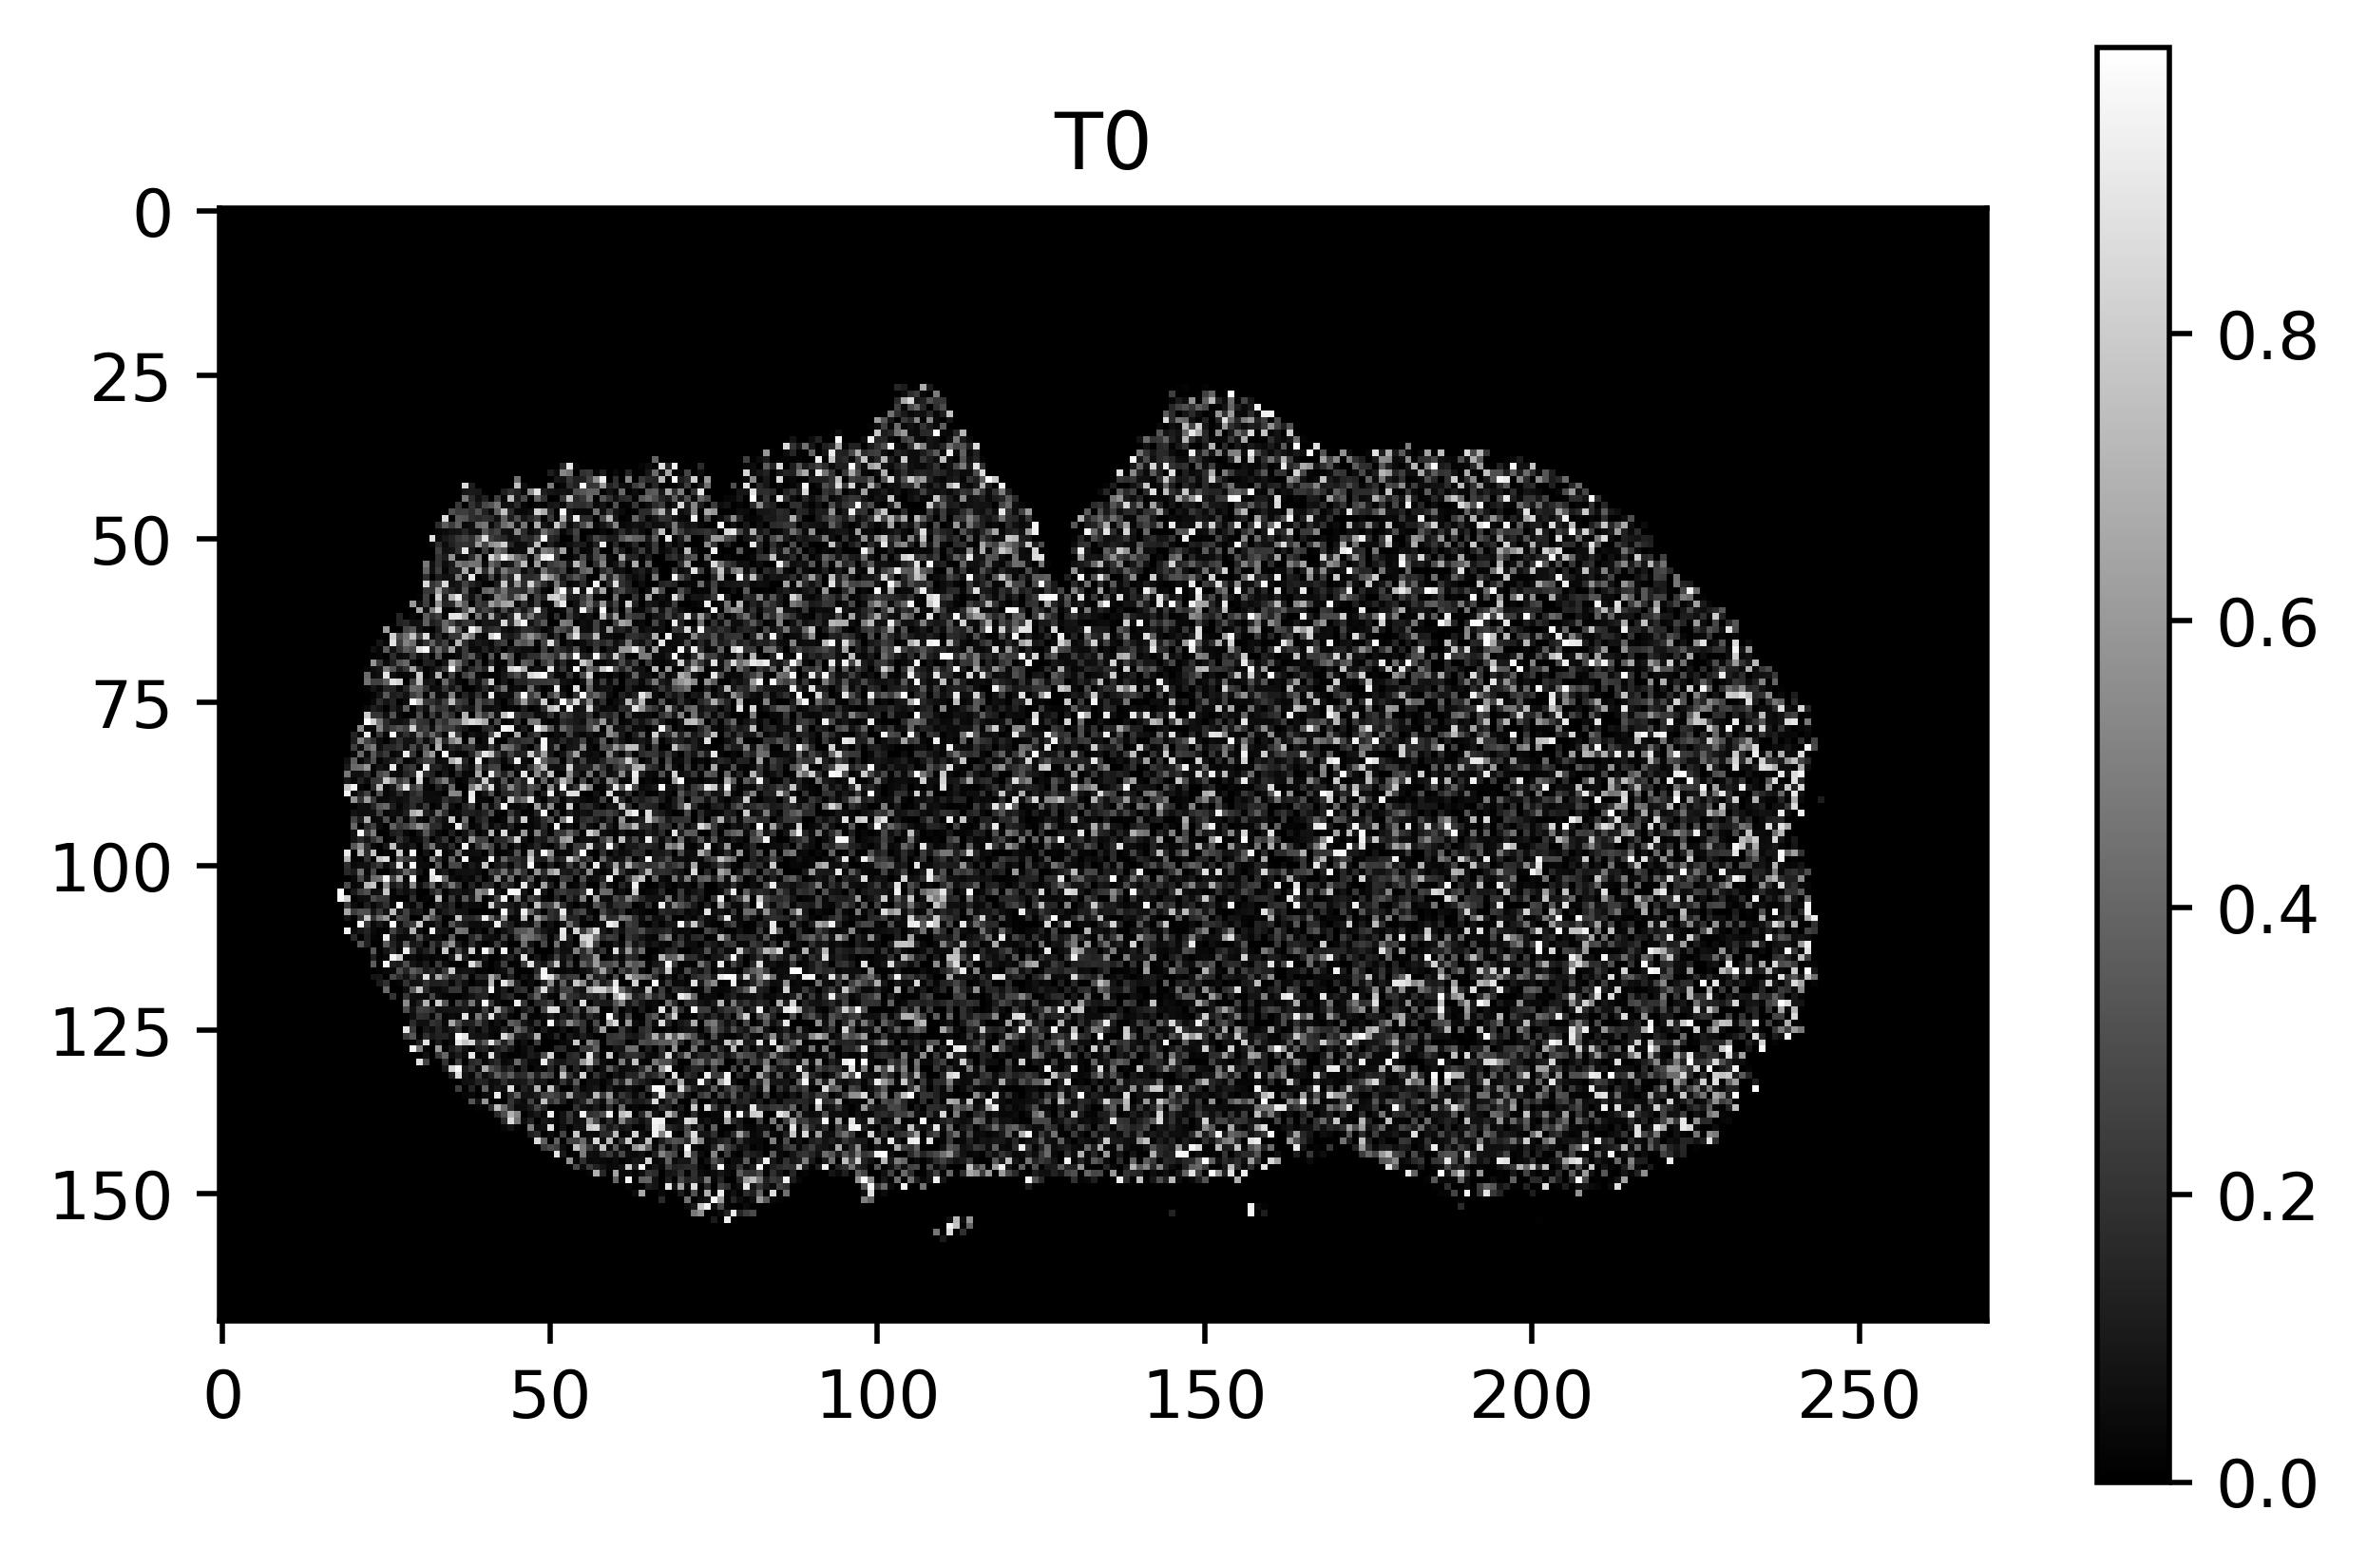

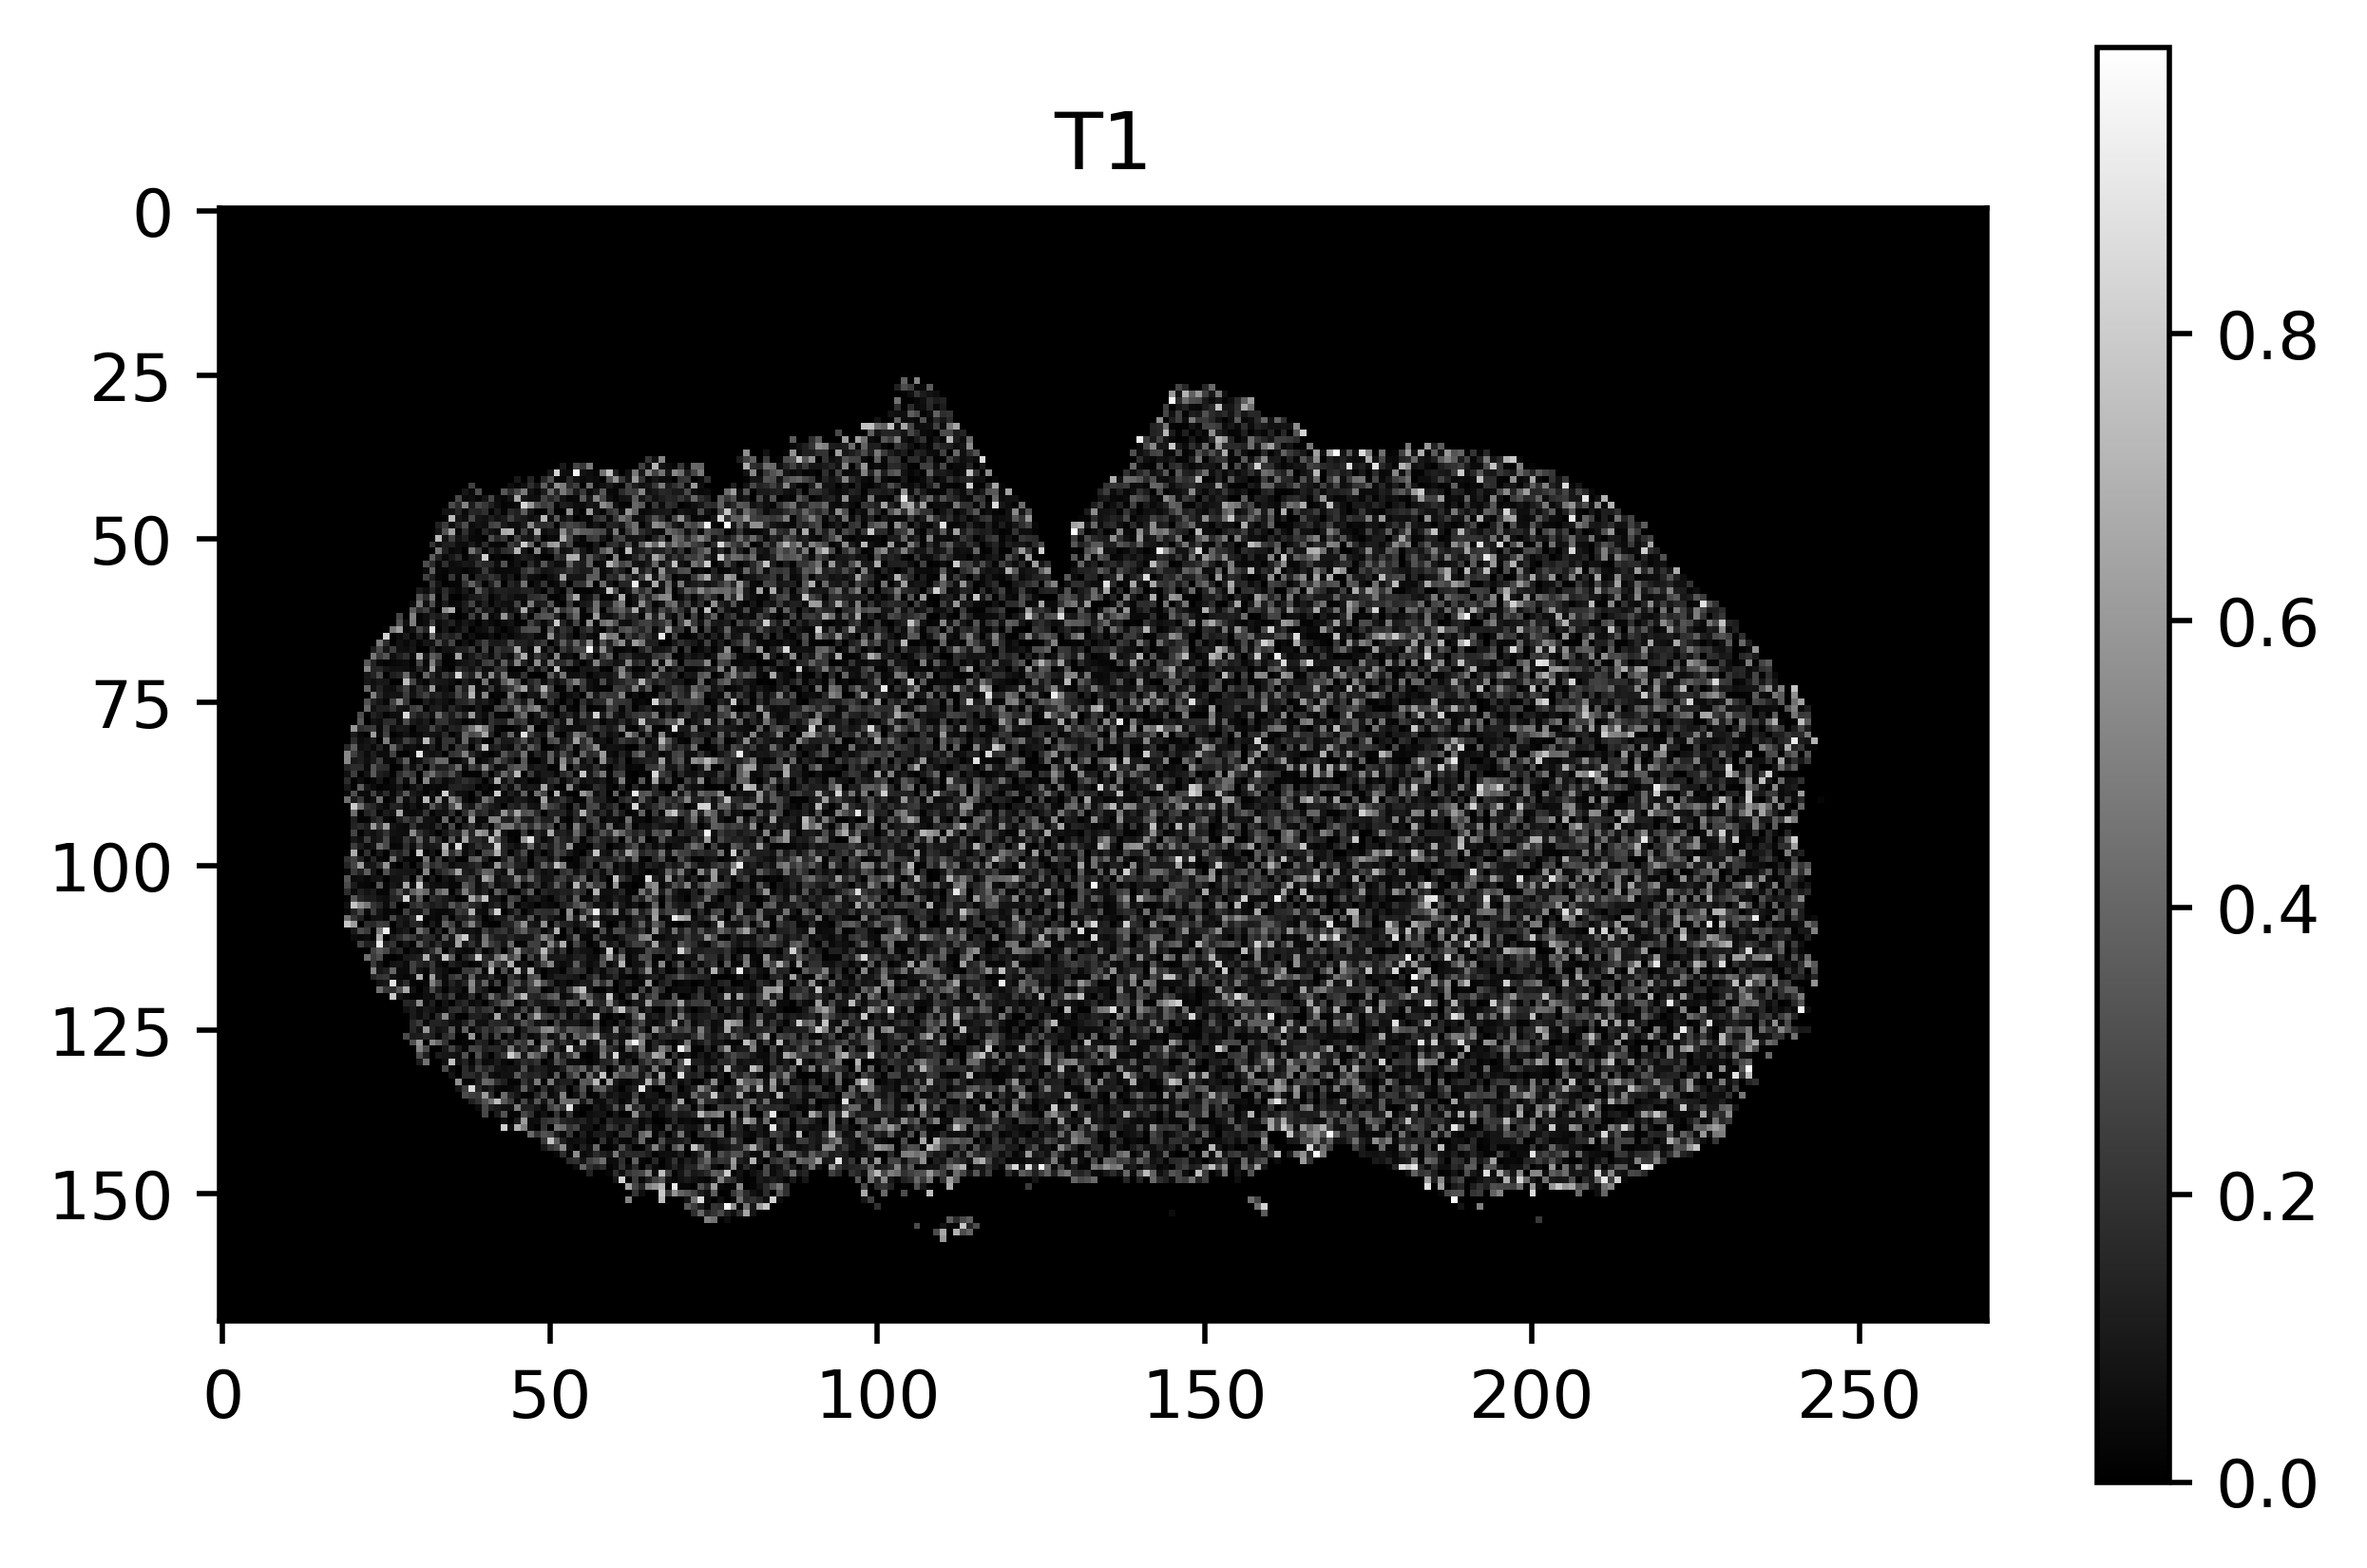

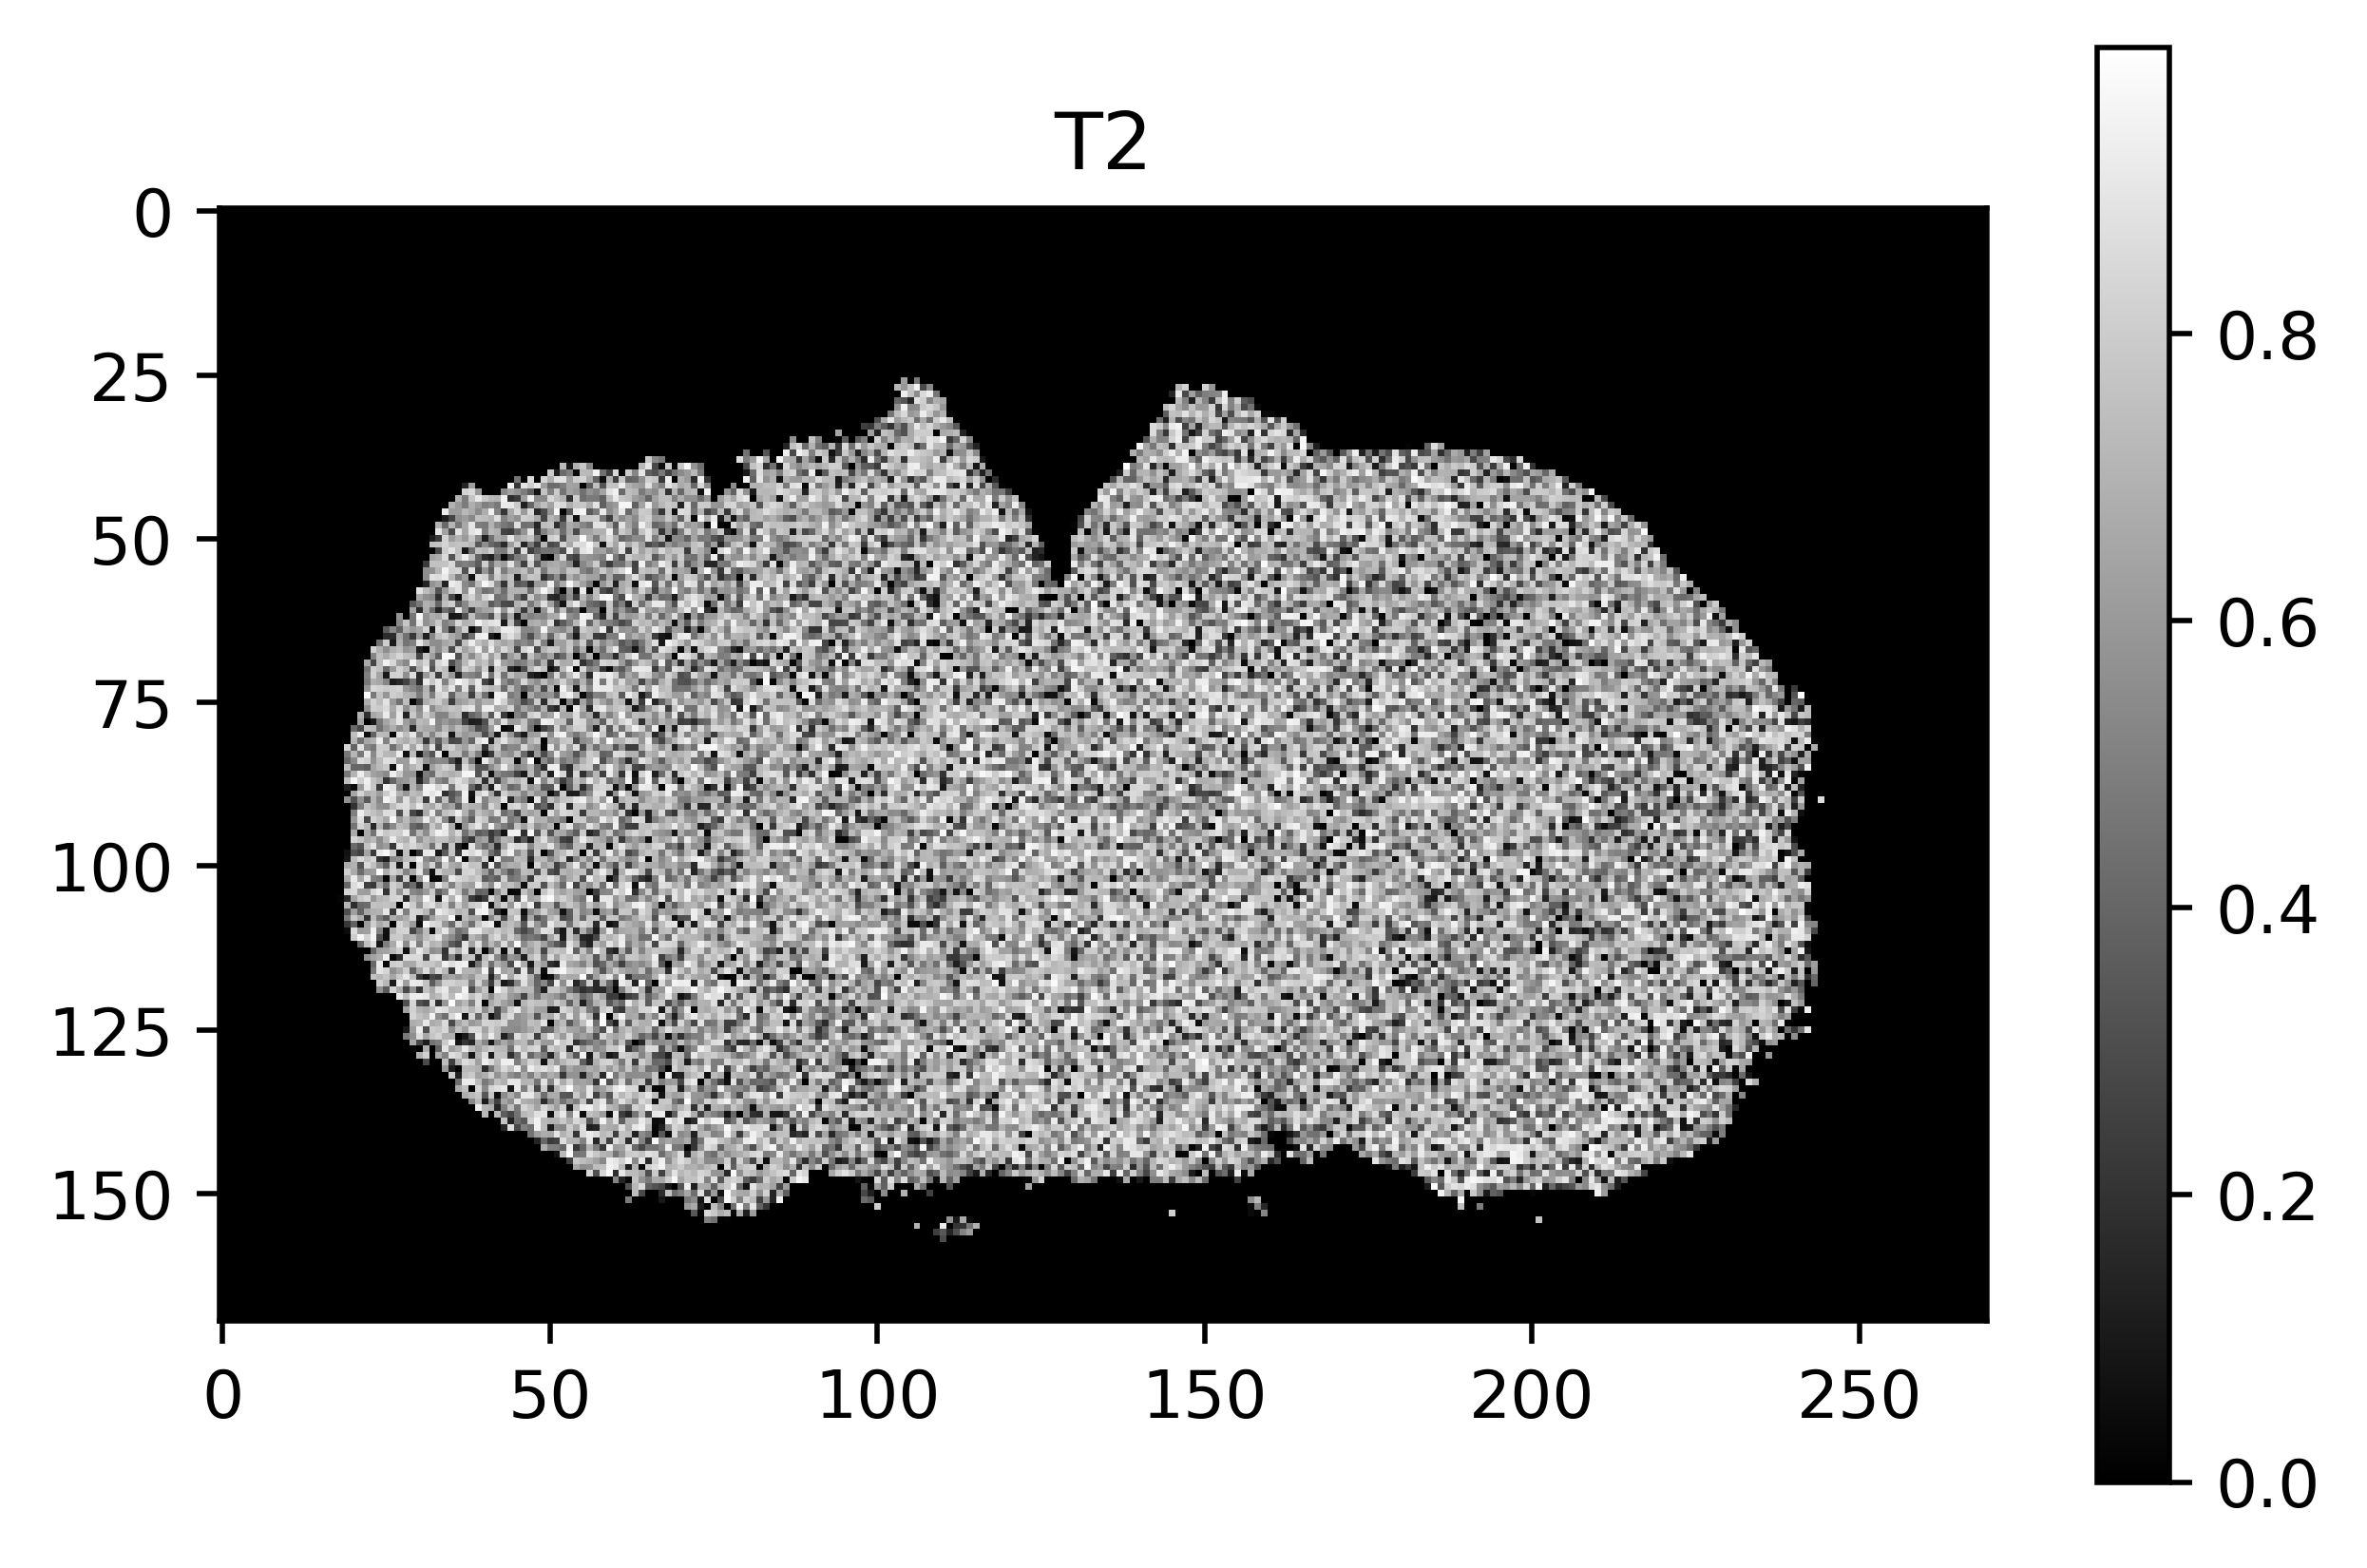

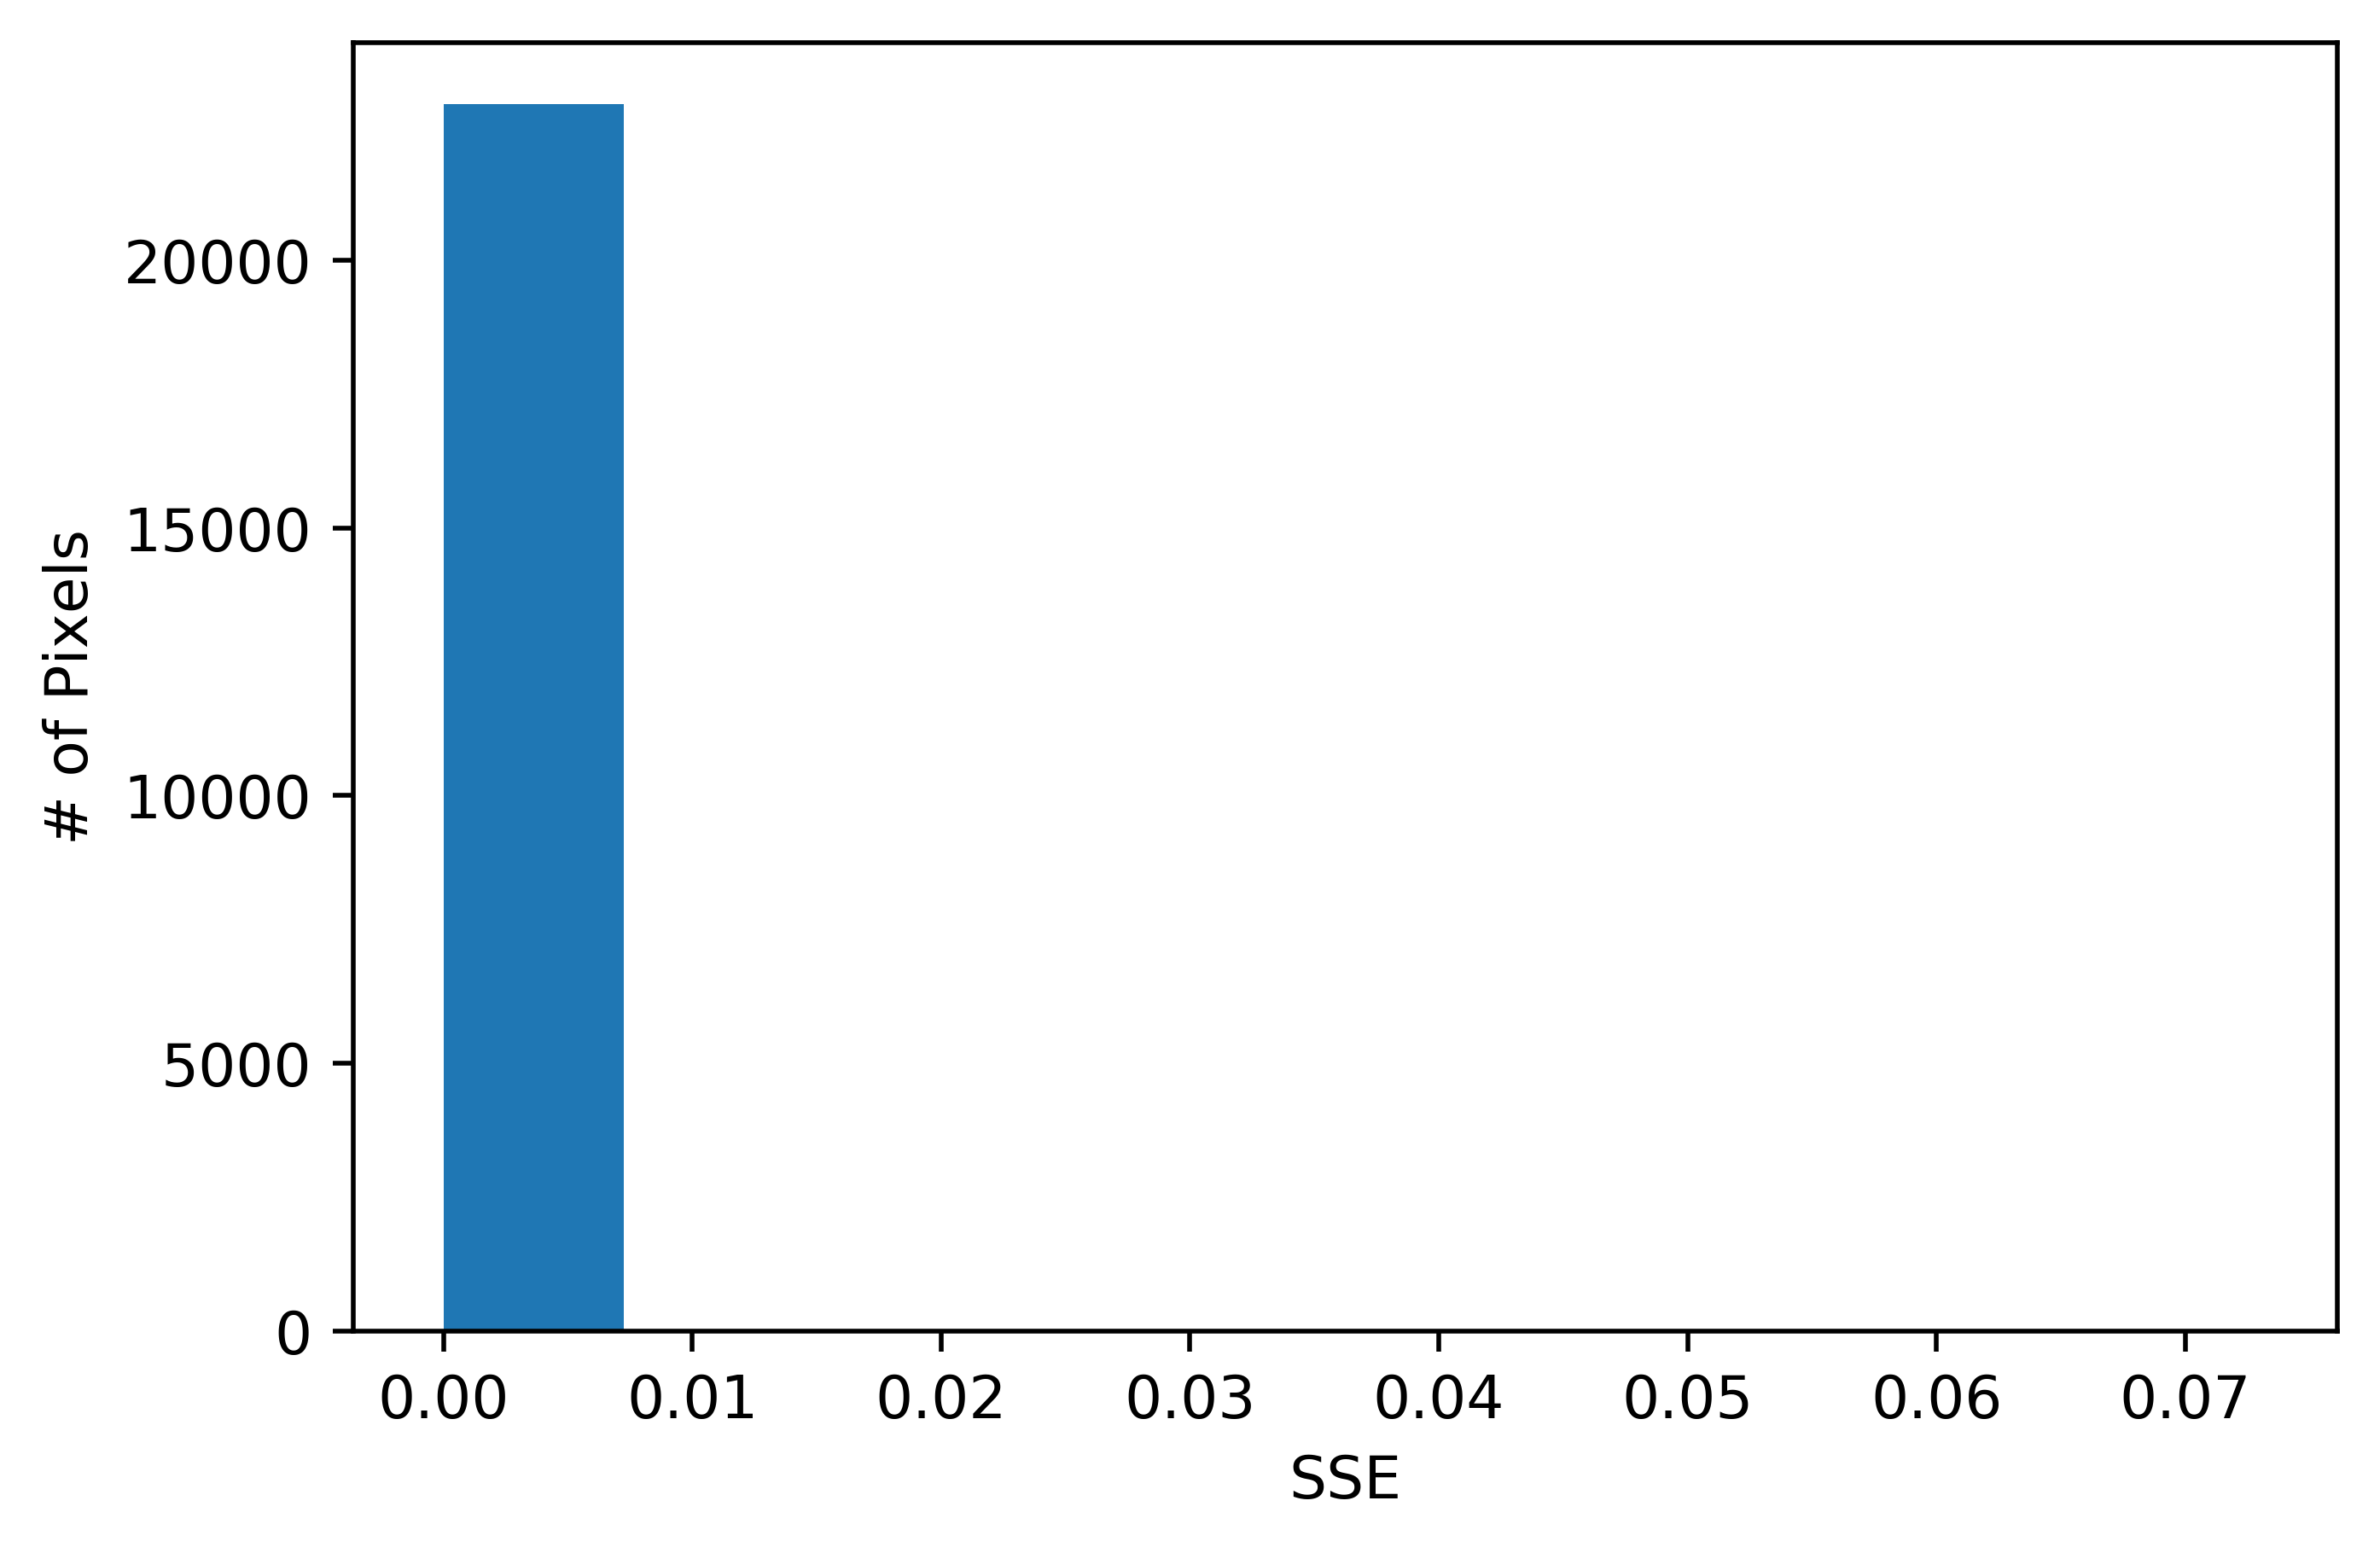

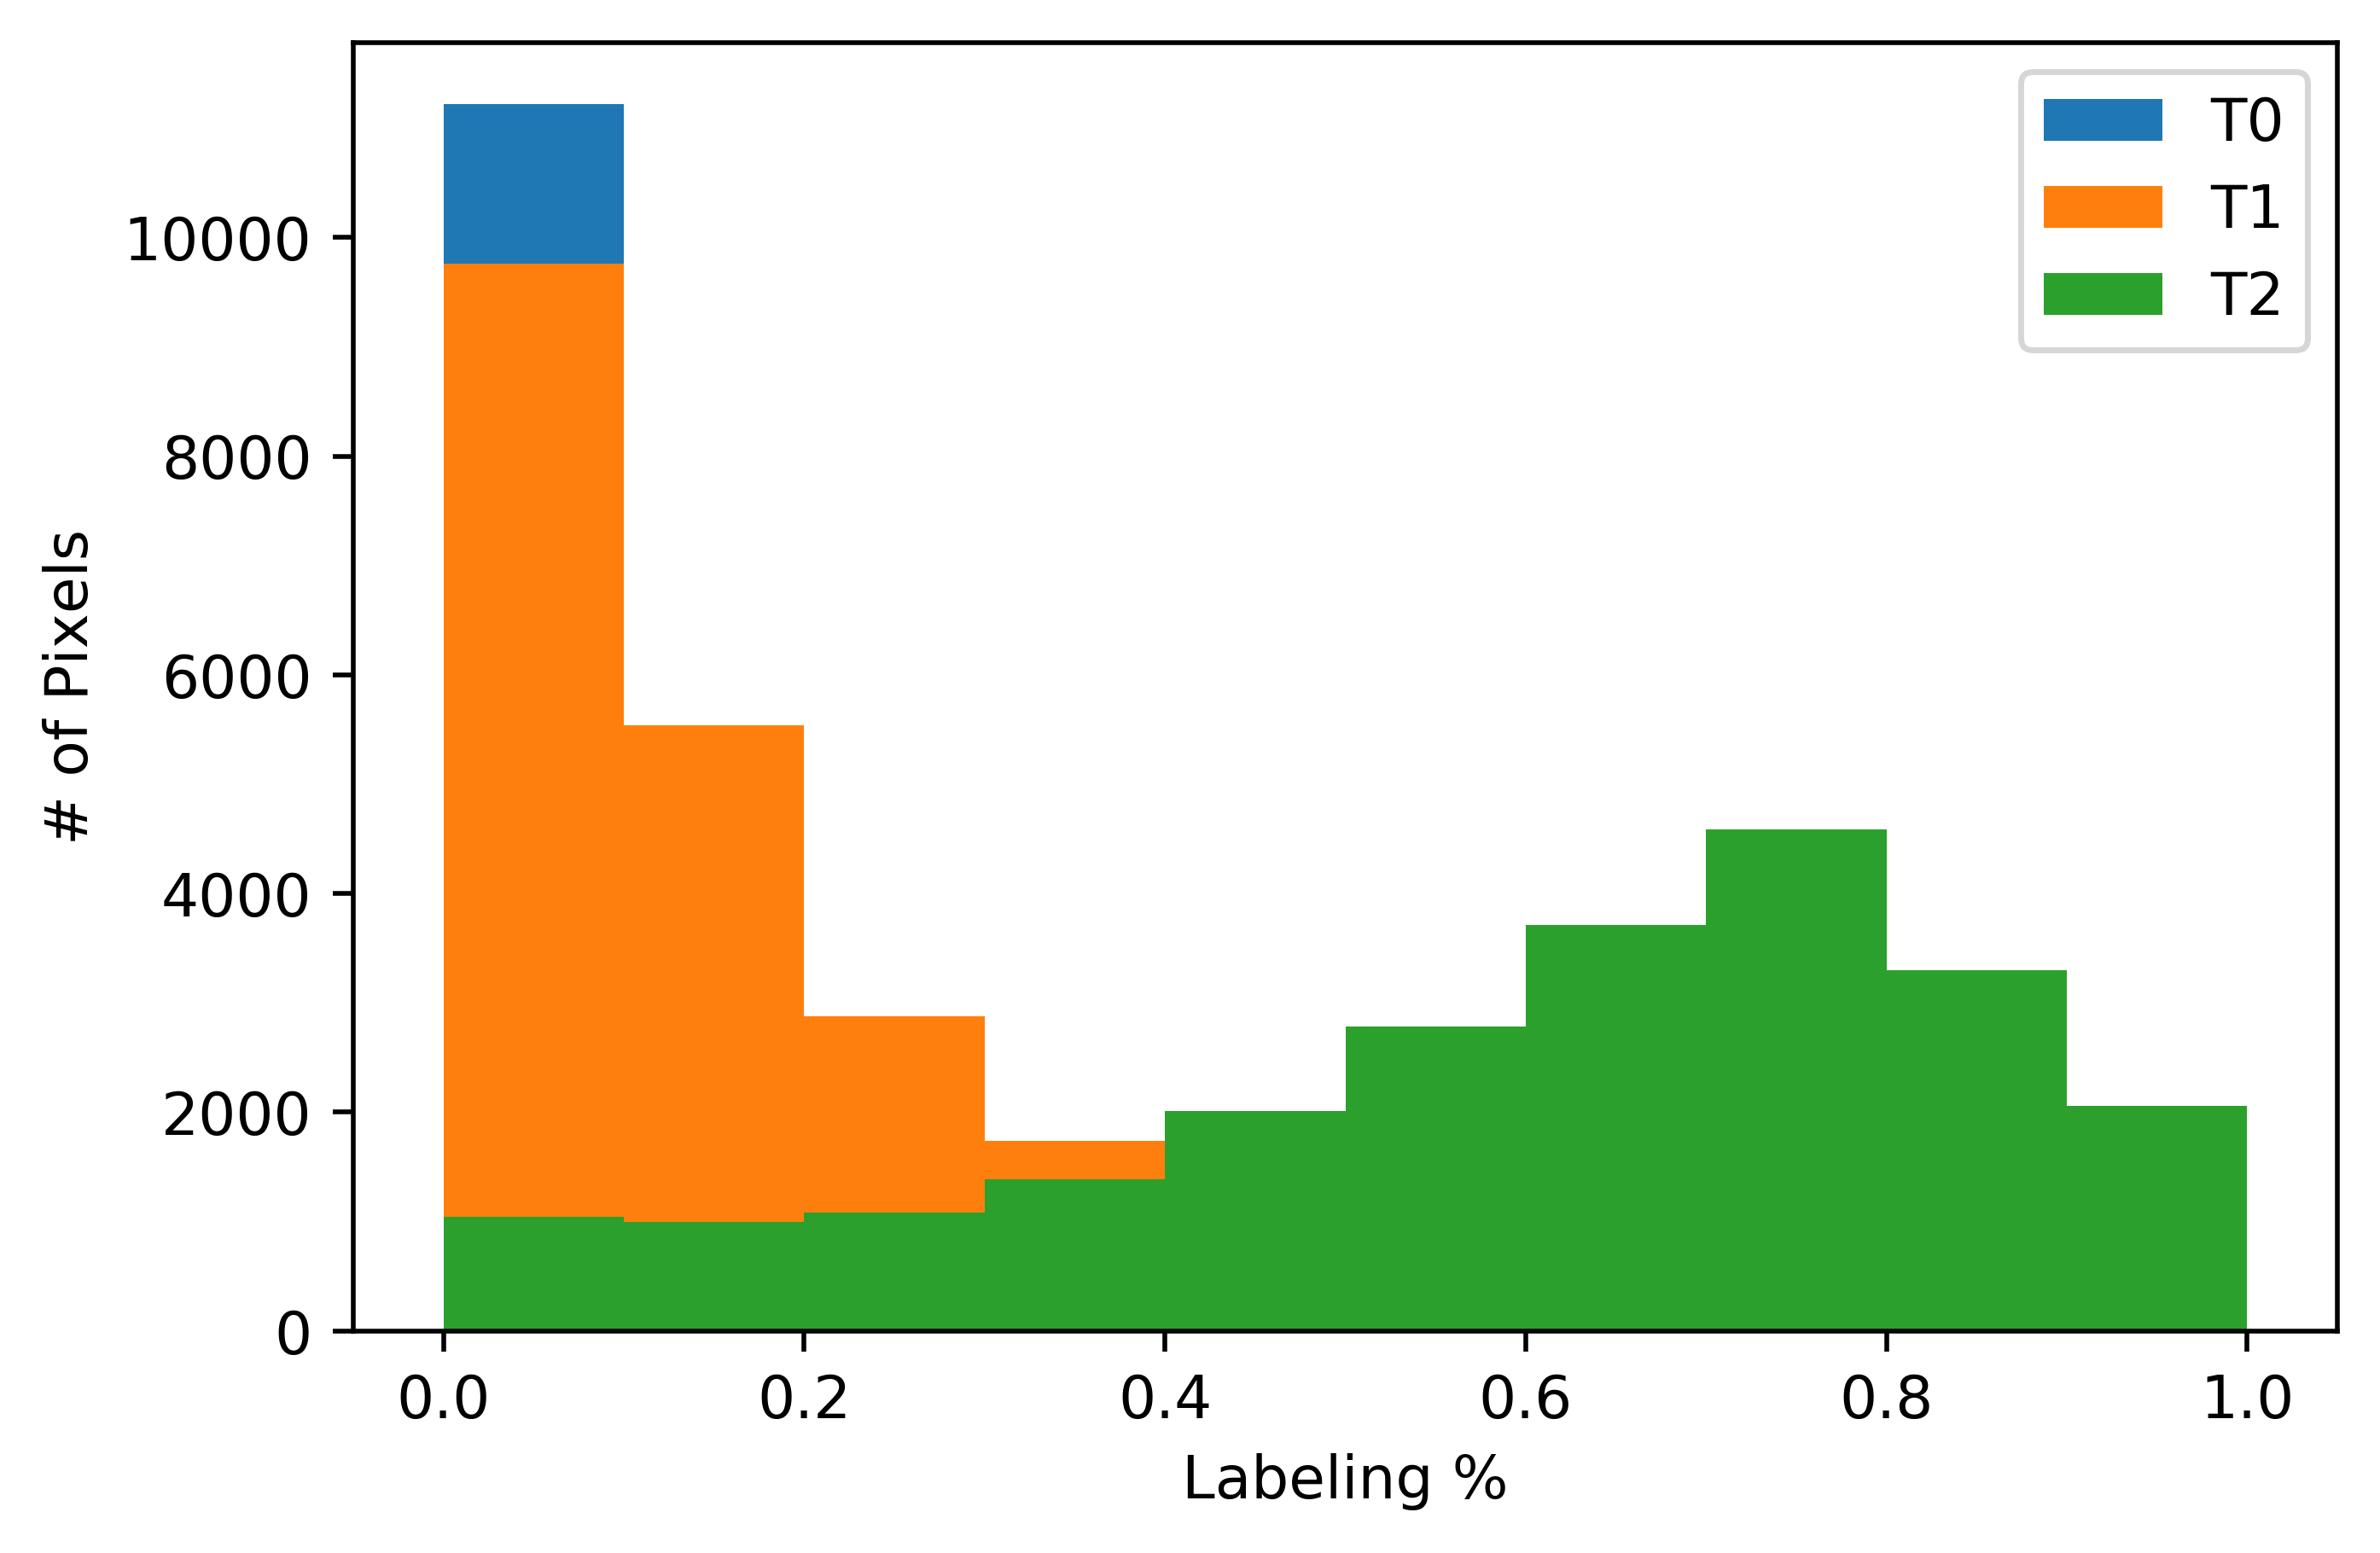

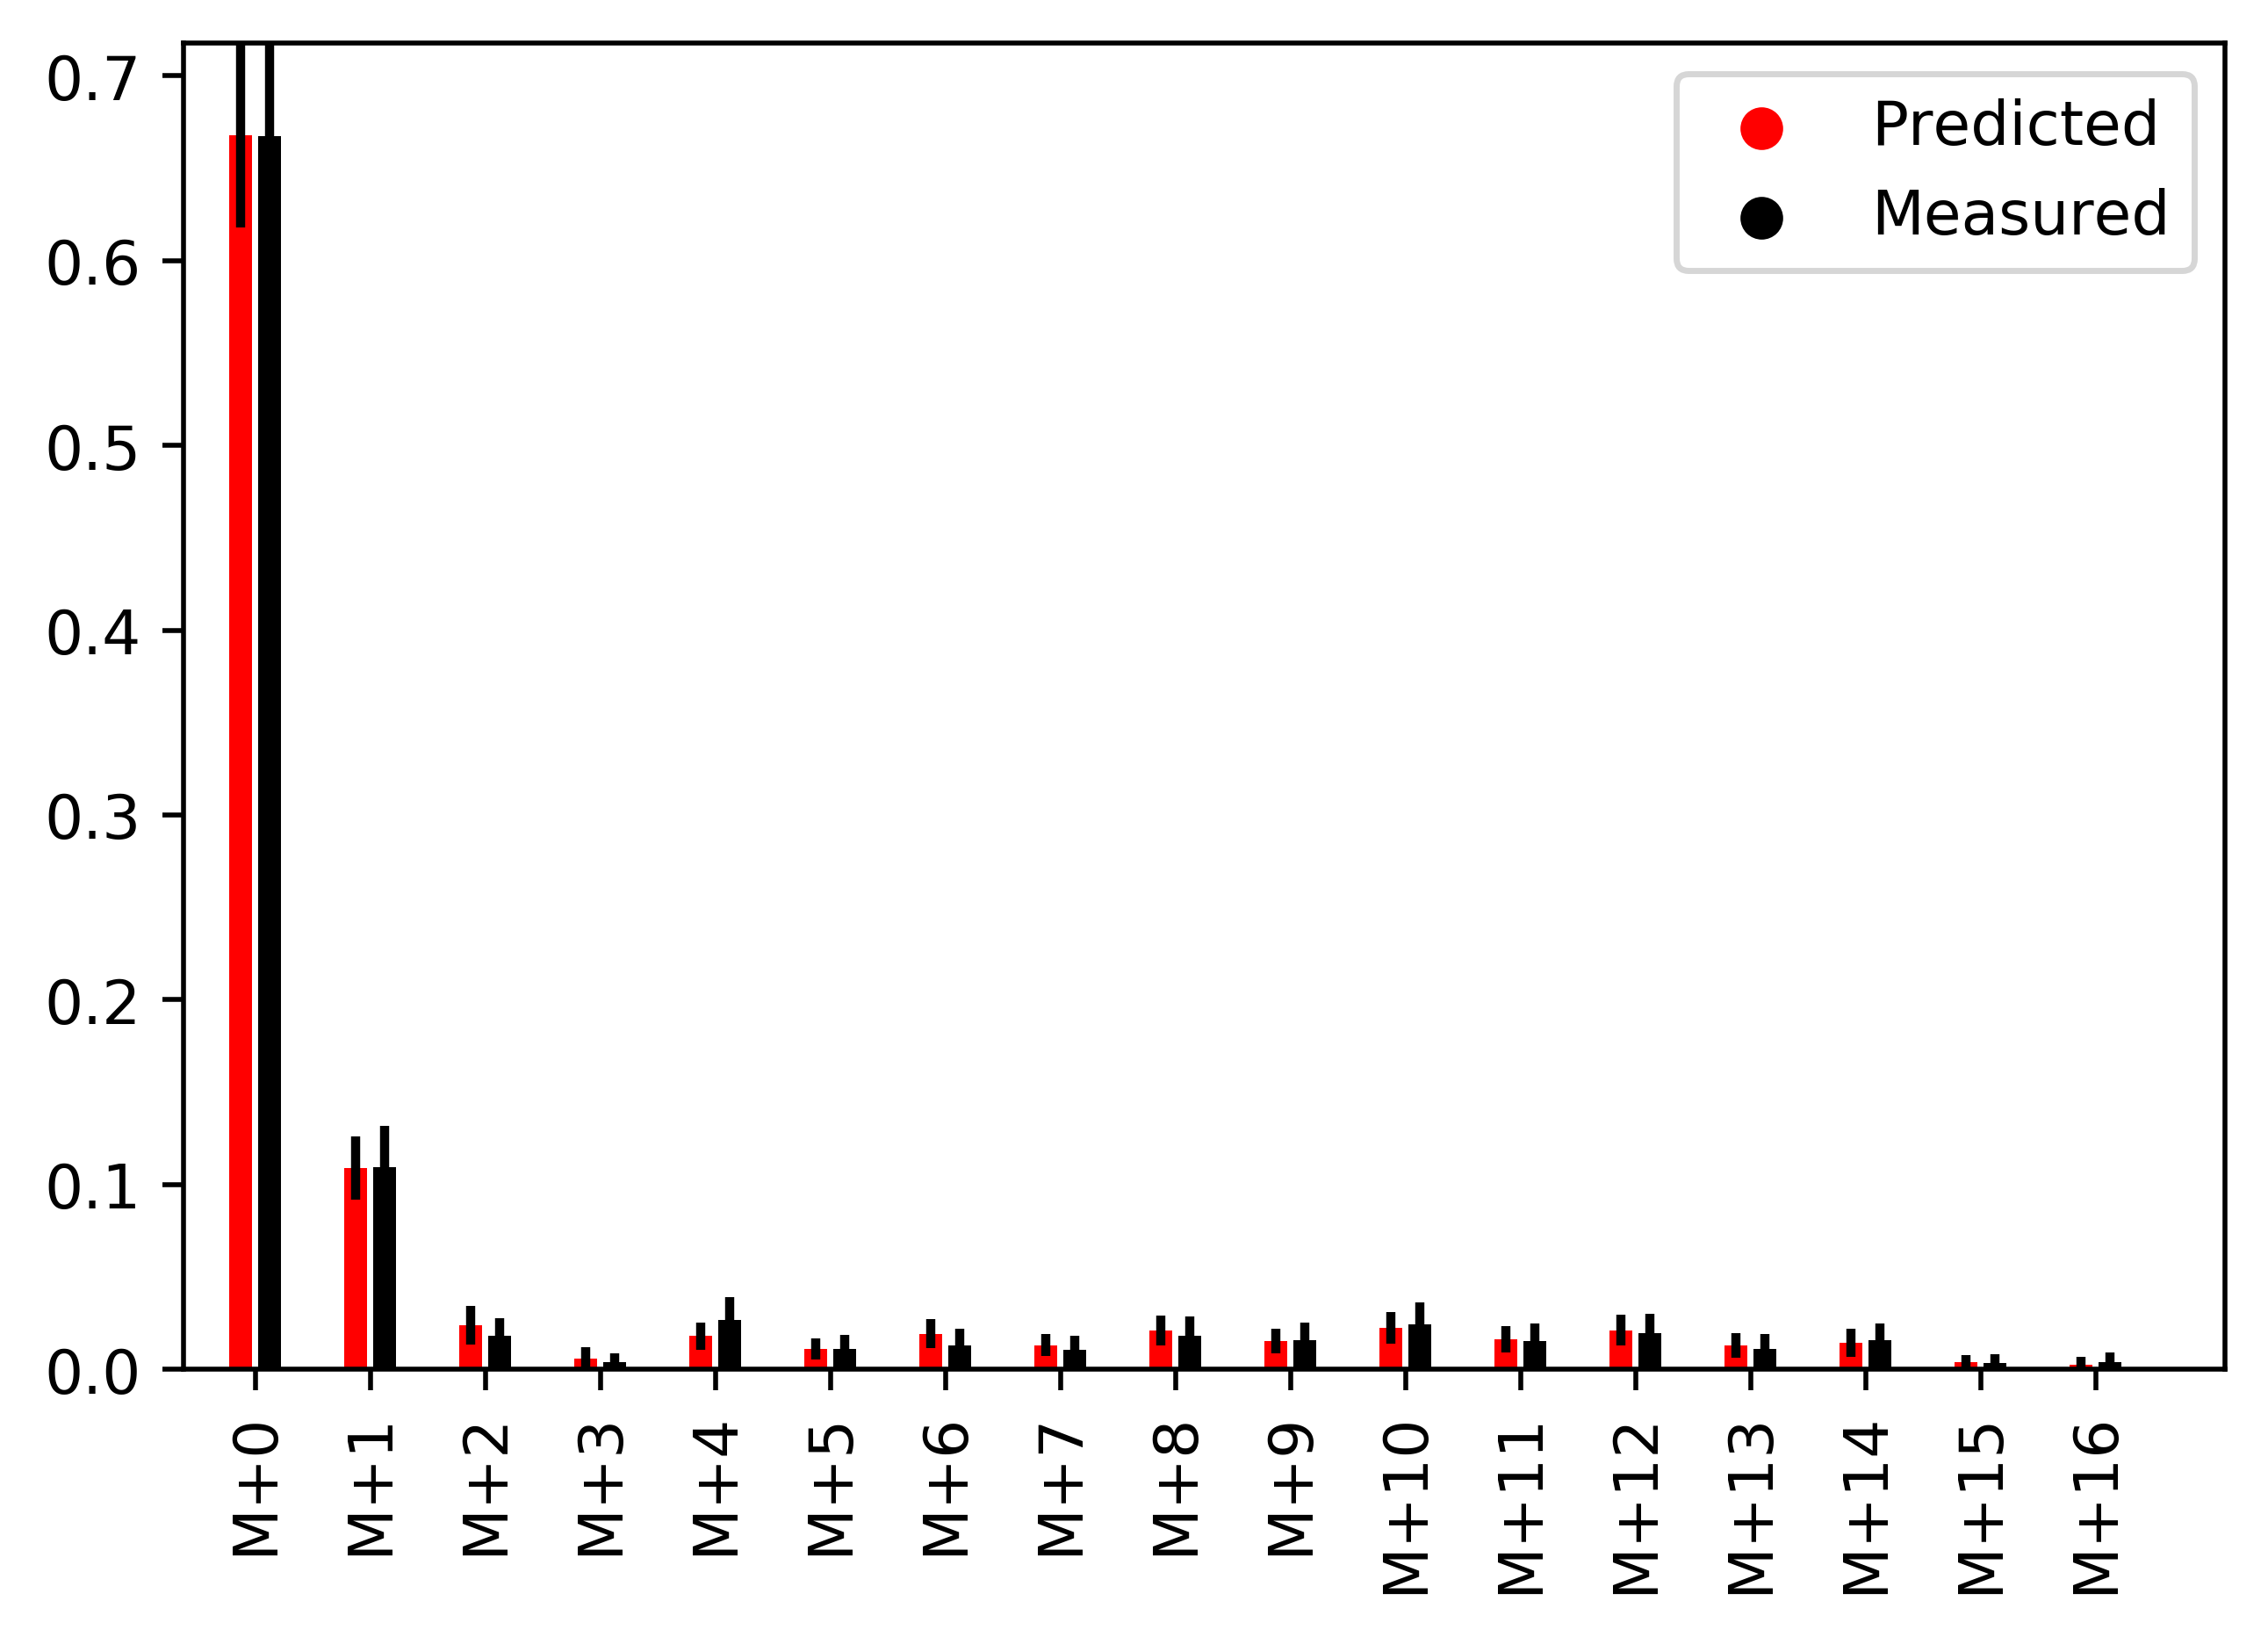

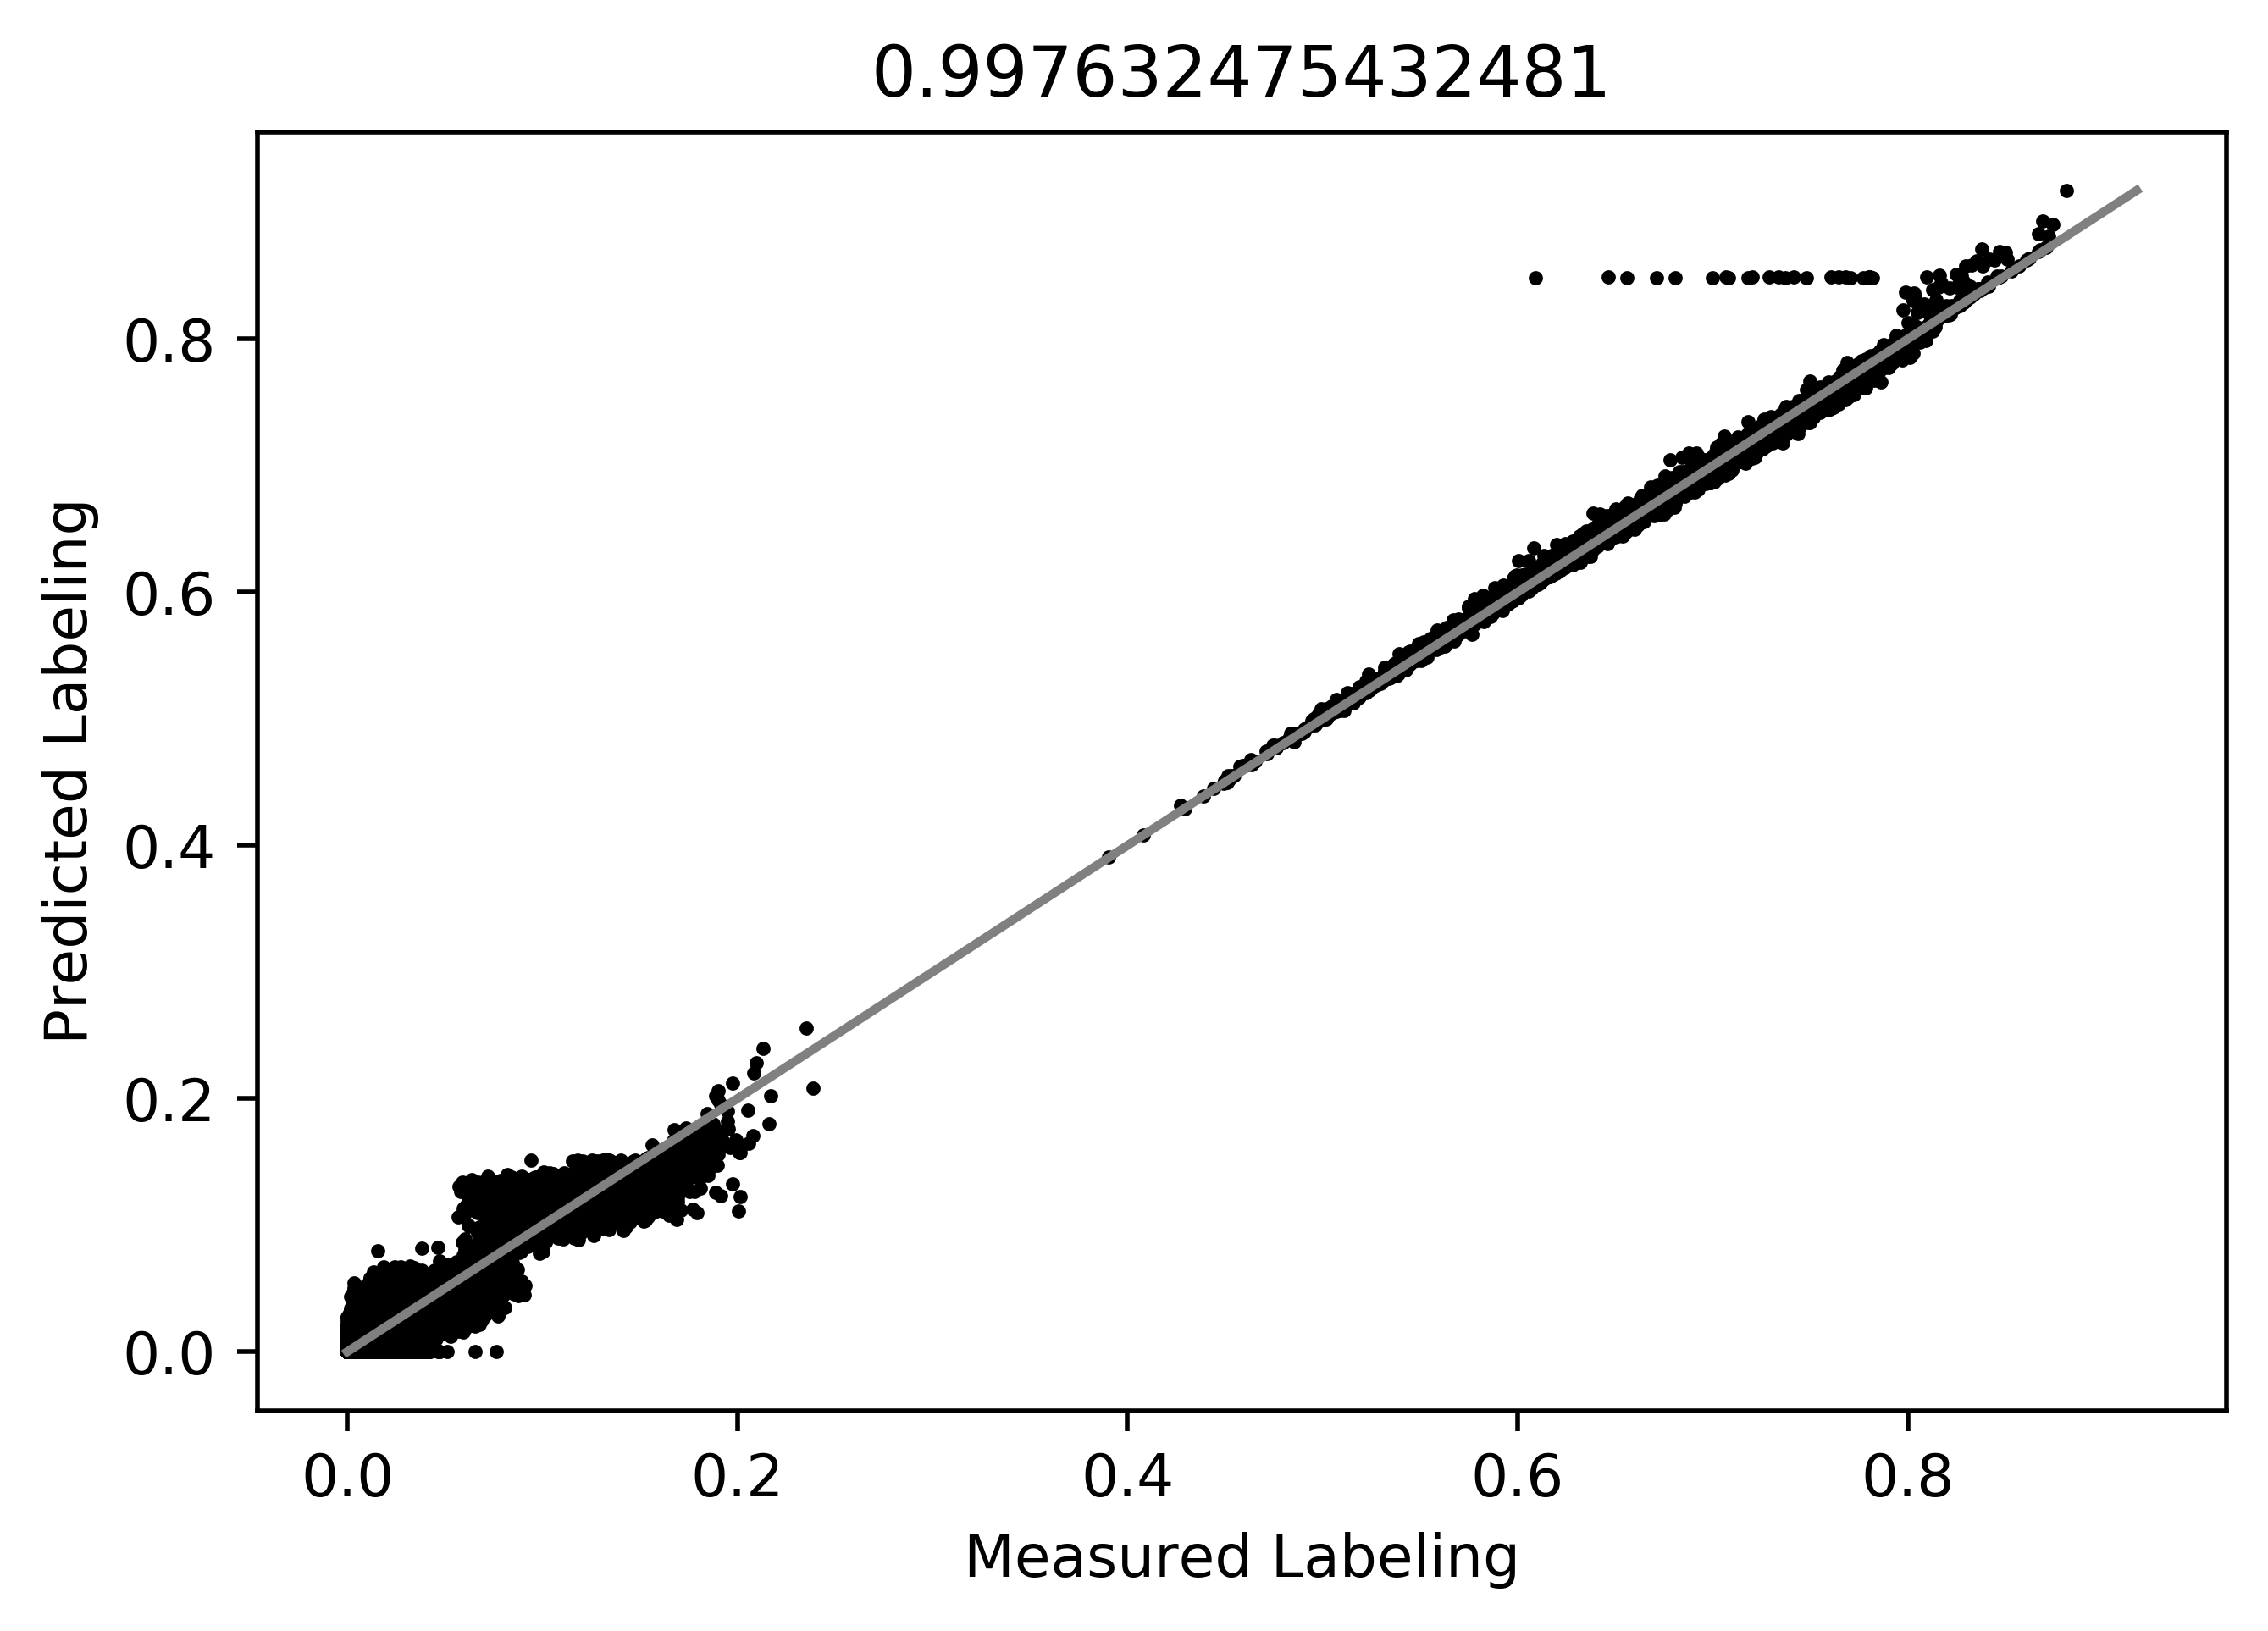

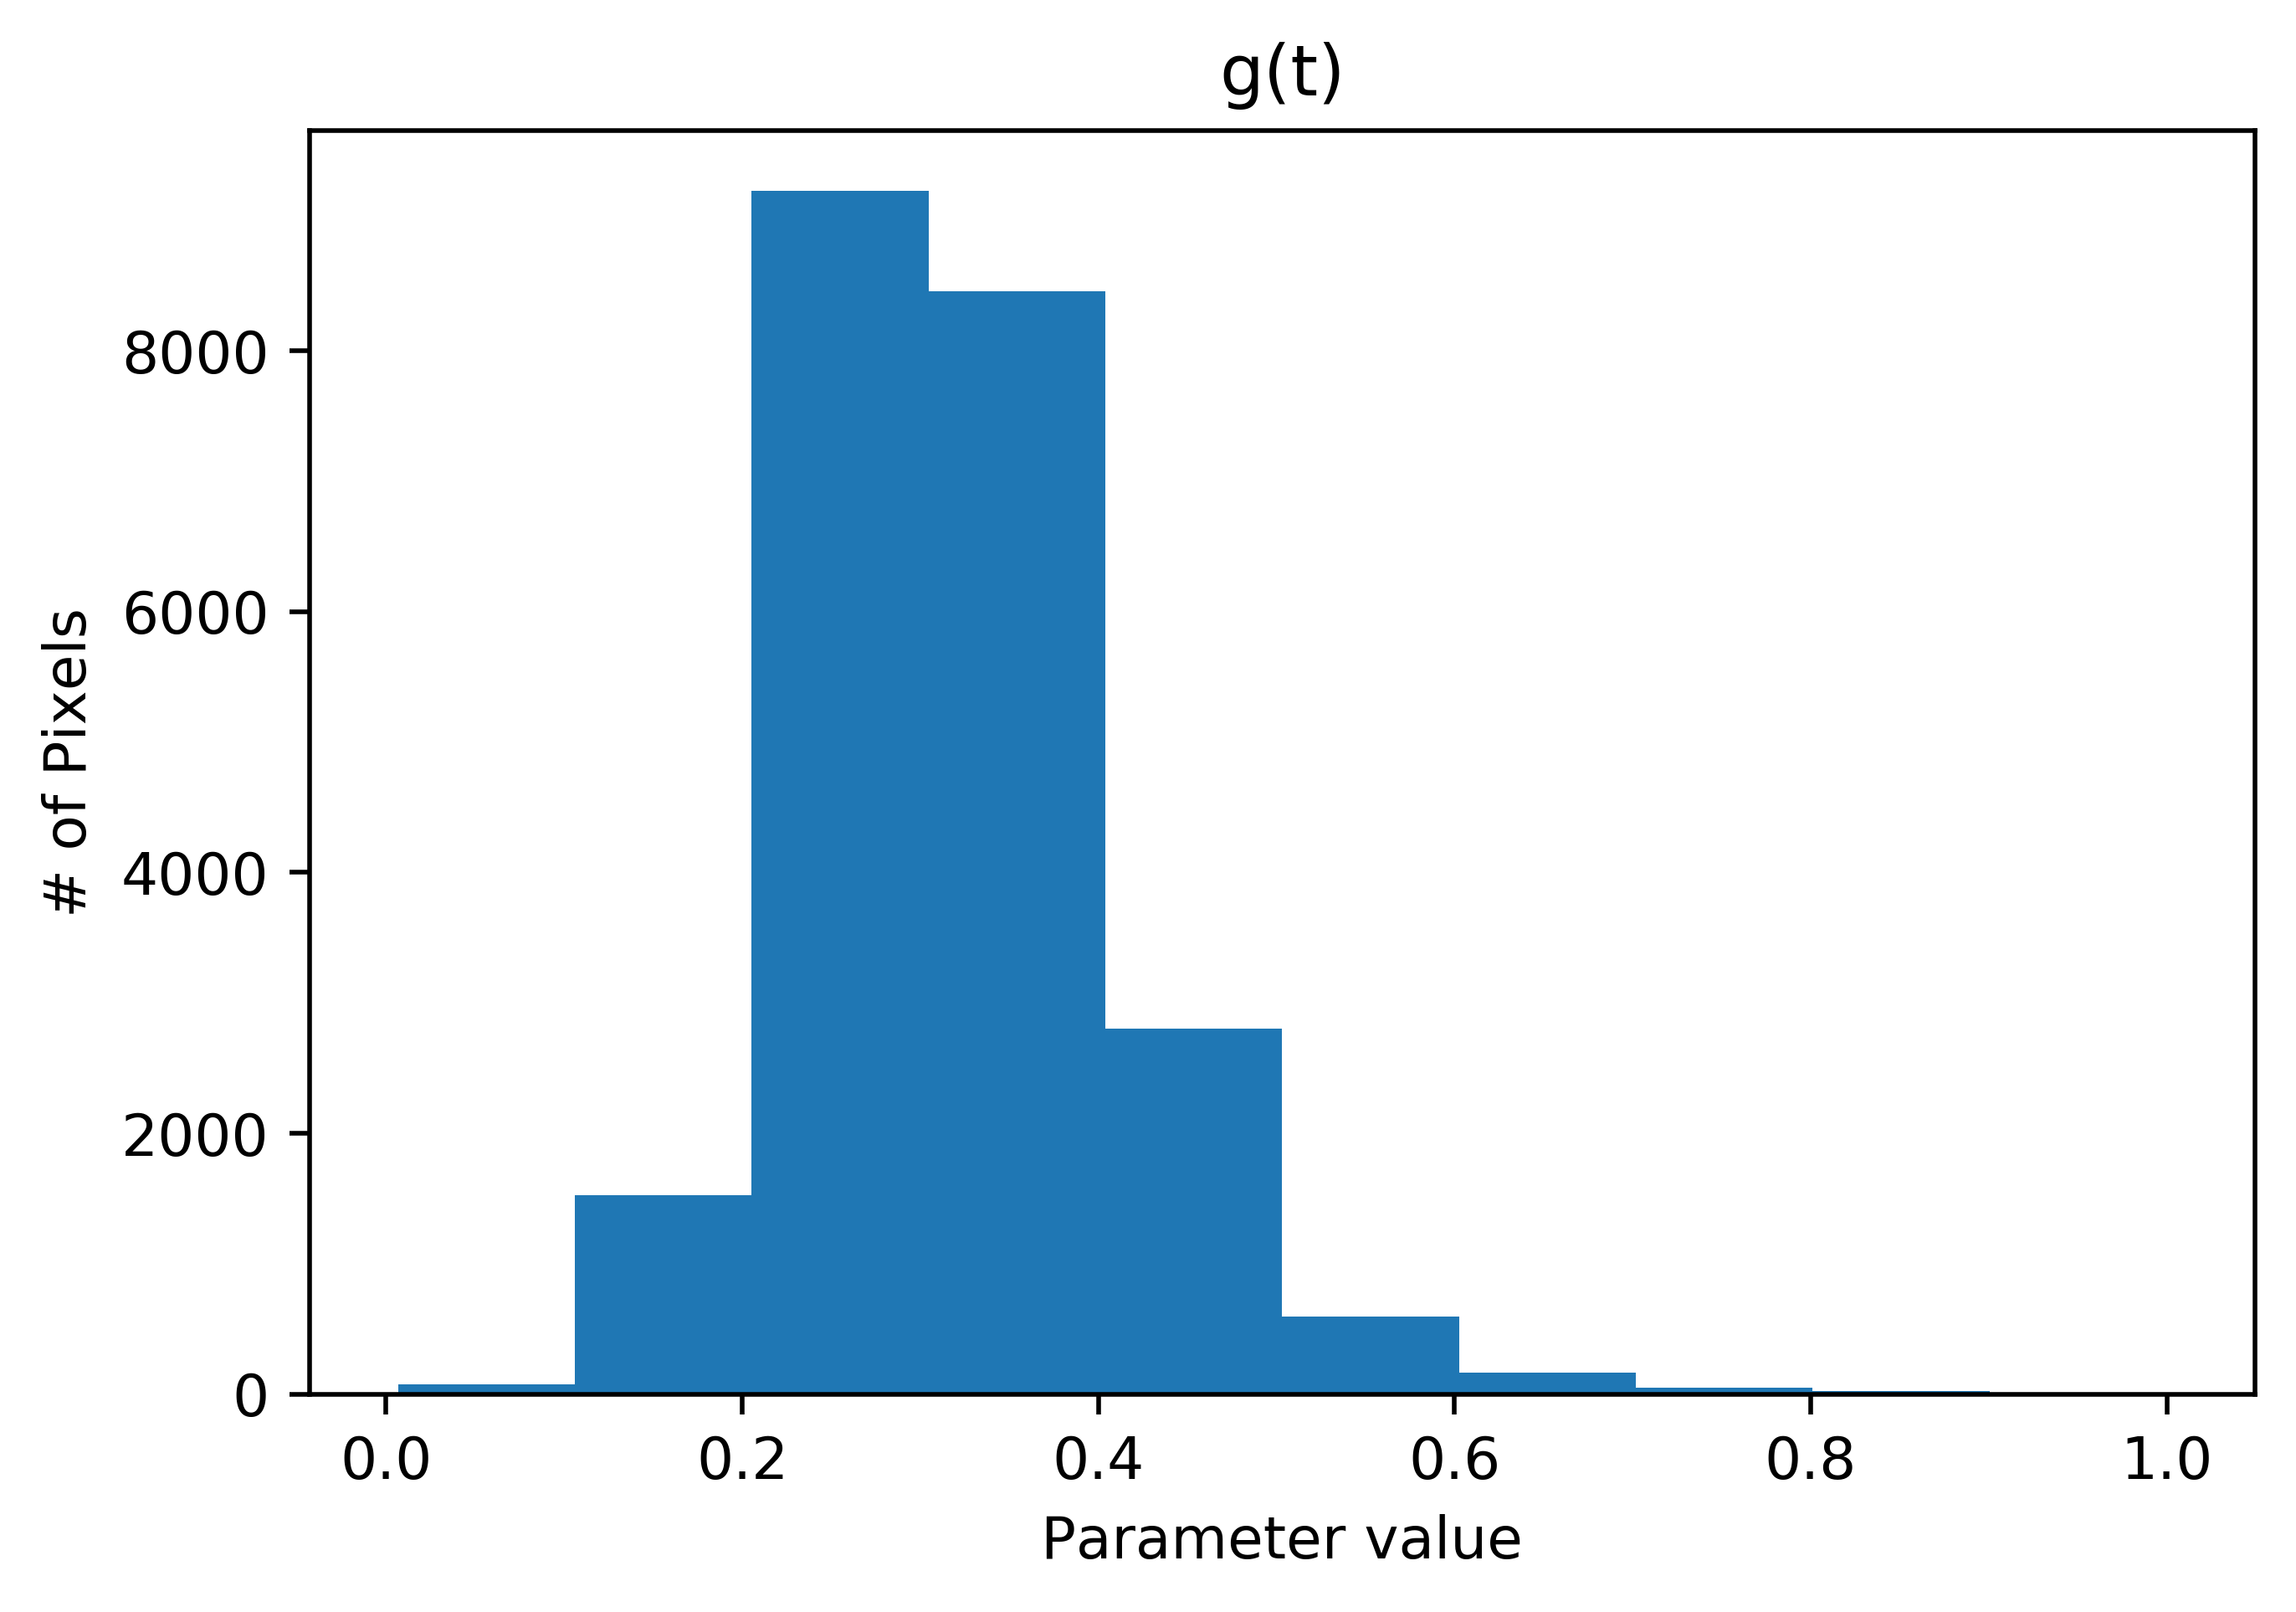

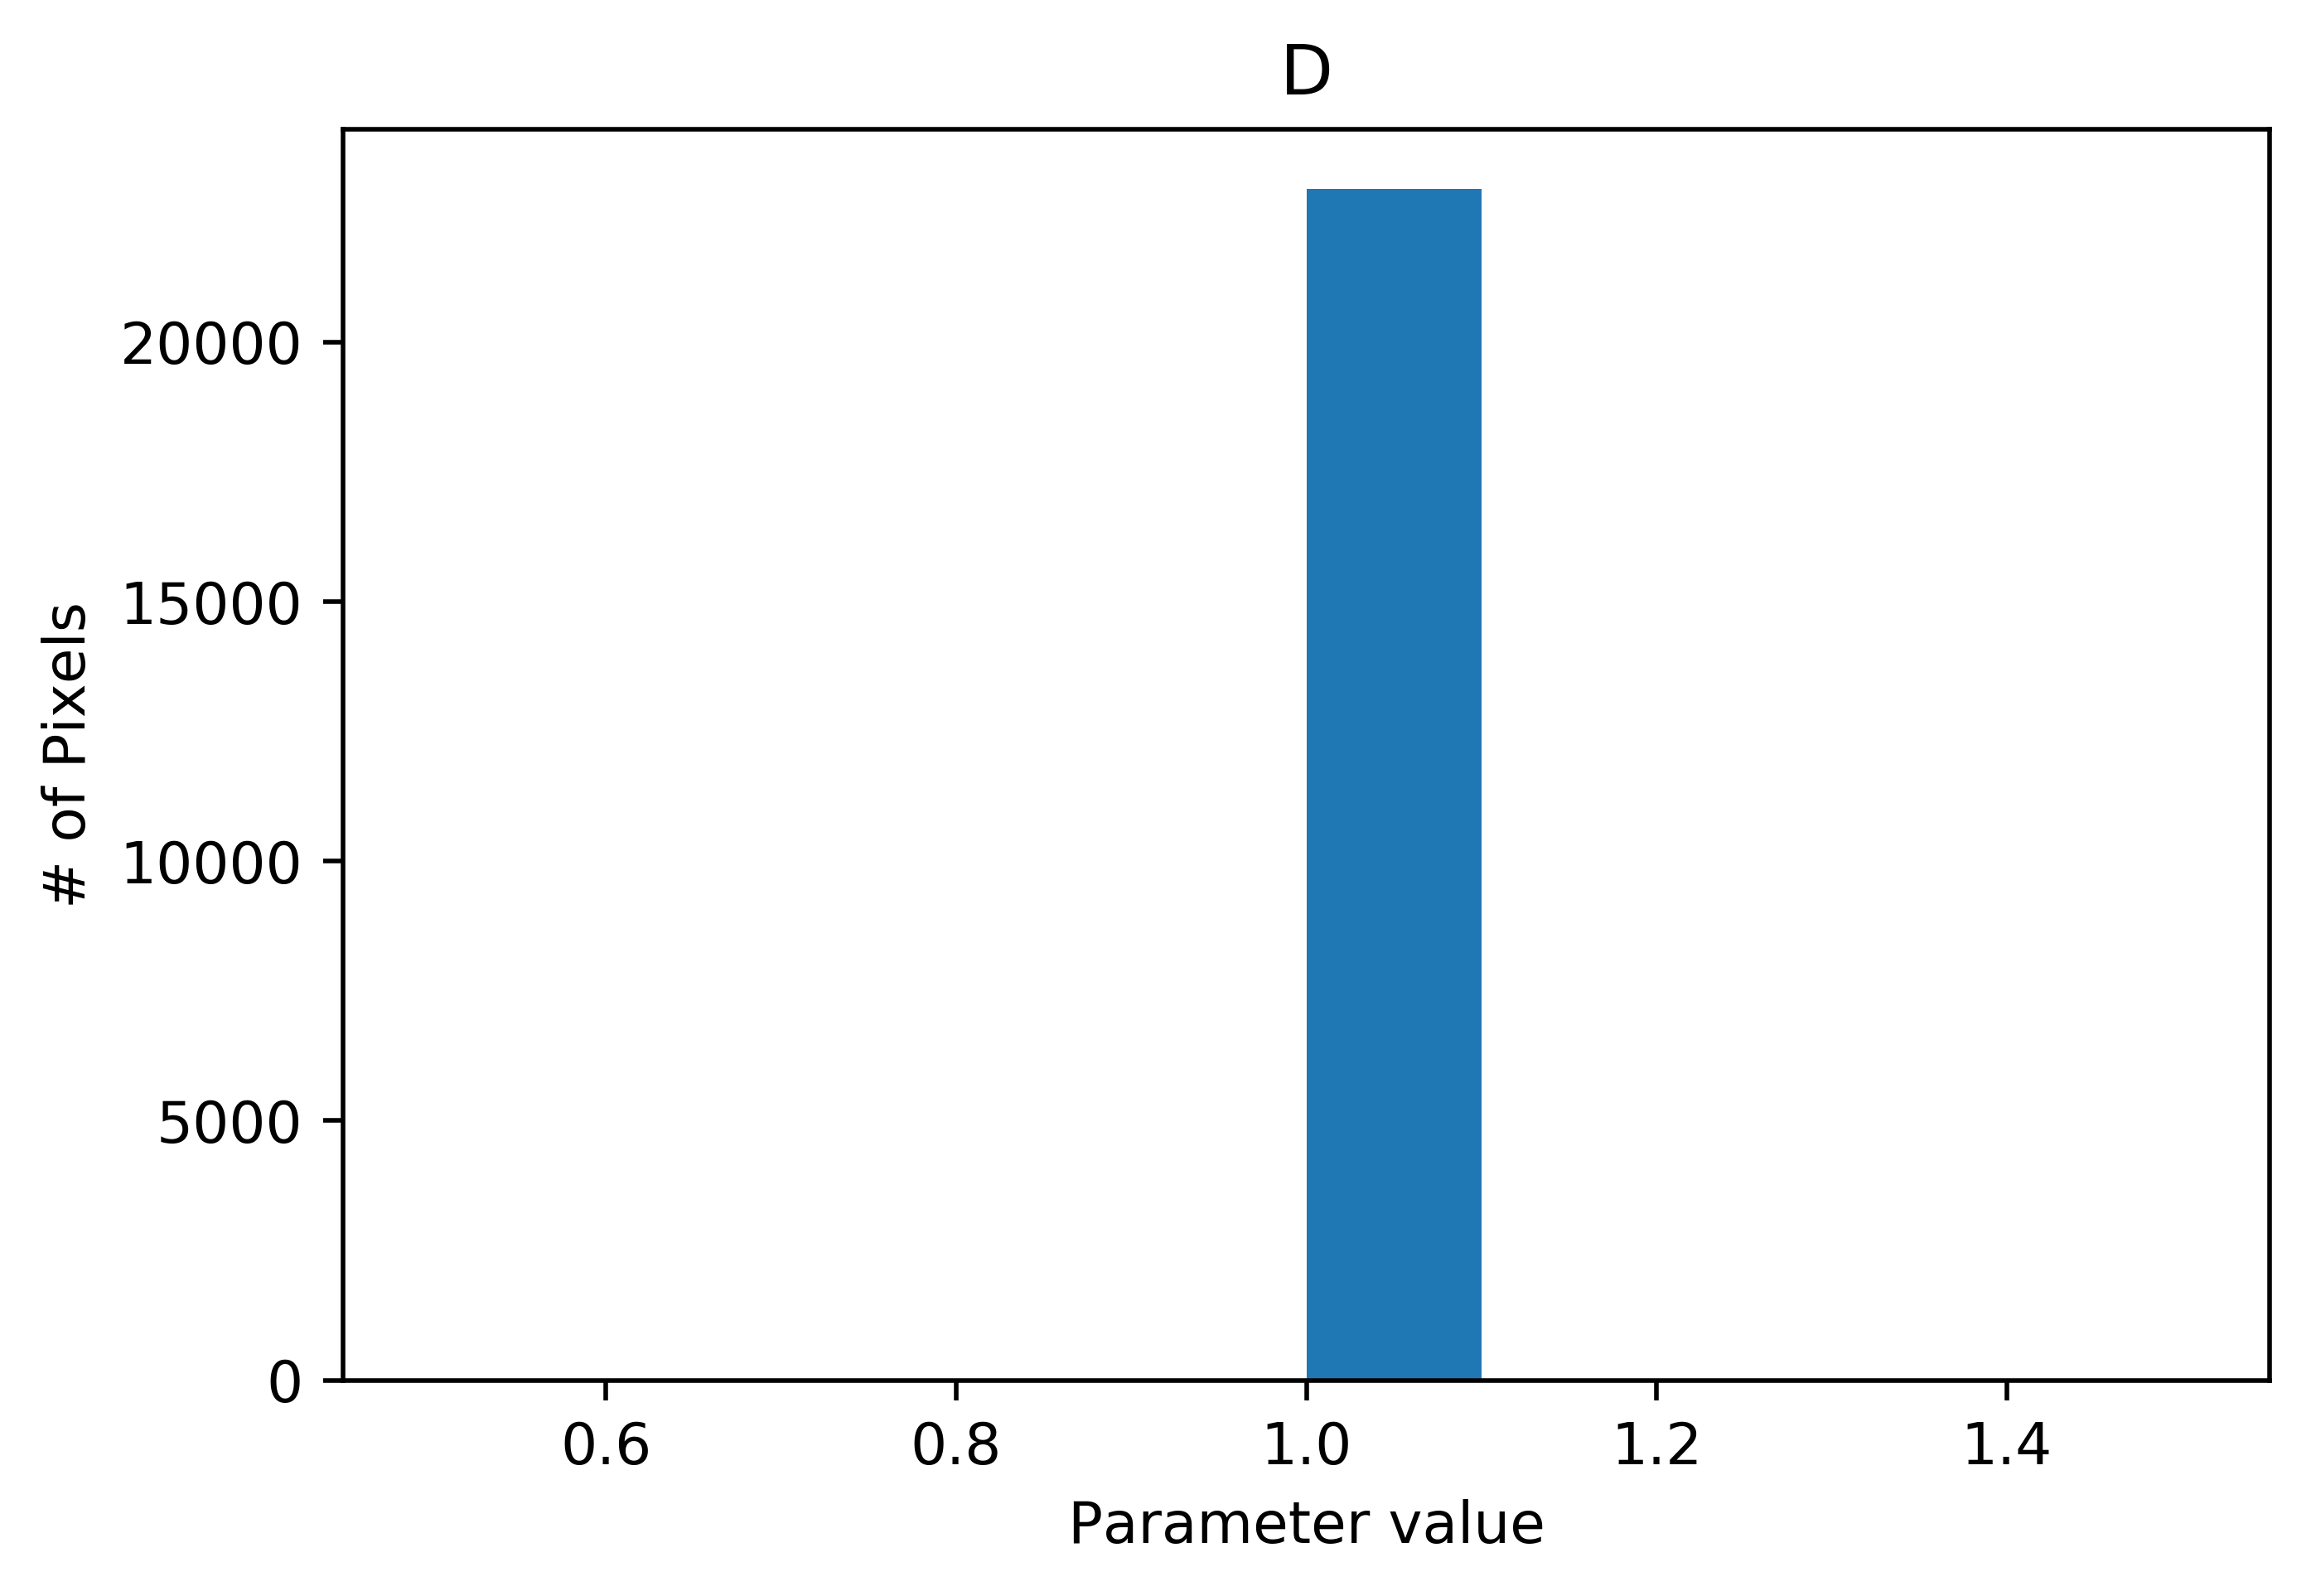

In [18]:
#show and save images
plt.imshow(fluxImageG,cmap=colormap)
im = Image.fromarray(fluxImageG)
plt.colorbar()
plt.title("g")
plt.figure()
plt.imshow(fluxImageD,cmap=colormap)
plt.title("D")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT0,cmap=colormap)
plt.title("T0")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT1,cmap=colormap)
plt.title("T1")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT2,cmap=colormap)
plt.title("T2")
plt.colorbar()

#plot histogram of sum of squared errors
plt.figure()
plt.hist(errs)
plt.xlabel("SSE")
plt.ylabel("# of Pixels")

#output found tracer labeling
plt.figure()
T_founds = np.array([t/np.sum(t) for t in T_founds])
T_found = np.mean(T_founds,axis=0)
print("T (mean) = ",T_found)
for t in range(len(T_found)):
    plt.hist(T_founds[:,t],label="T"+str(t))
plt.legend()
plt.xlabel("Labeling %")
plt.ylabel("# of Pixels")


plt.figure()
x_ind = 0
x_lab = []
meanPred = np.median(P_preds,axis=0)
stdPred = np.std(P_preds,axis=0)
meanTrue = np.median(P_trues,axis=0)
stdTrue = np.std(P_trues,axis=0)
maxY = np.max(np.concatenate((meanPred,meanTrue))) + np.max(np.concatenate((stdPred,stdTrue)))
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)
plt.scatter([-1],[-1],c="red",label="Predicted")
plt.scatter([-1],[-1],c="black",label="Measured")
plt.legend()
plt.ylim((0,maxY))
plt.xlim((-2,x_ind+1))

plt.figure()

plt.scatter(np.array(P_trues).flatten(),np.array(P_preds).flatten(),color="black",s=2)
plt.ylabel("Predicted Labeling")
plt.xlabel("Measured Labeling")
plt.title(r2_score(np.array(P_trues).flatten(),np.array(P_preds).flatten()))
plt.plot([0,np.max(np.concatenate((P_trues,P_preds)))],[0,np.max(np.concatenate((P_trues,P_preds)))],color="grey")


plt.figure()
plt.hist(fluxImageG[fluxImageG > 0].flatten())
plt.title("g(t)")
plt.xlabel("Parameter value")
plt.ylabel("# of Pixels")

plt.figure()
plt.hist(fluxImageD[fluxImageD > 0].flatten())
plt.title("D")
plt.xlabel("Parameter value")
plt.ylabel("# of Pixels")




In [9]:
offset = int((convSquarePost-1)/2)

fluxImageGFilt = helper.convolveLayer(offset,height,width,fluxImageG,imageBoundary,filt)
fluxImageDFilt = helper.convolveLayer(offset,height,width,fluxImageD,imageBoundary,filt)
fluxImageT0Filt = helper.convolveLayer(offset,height,width,fluxImageT0,imageBoundary,filt)
fluxImageT1Filt = helper.convolveLayer(offset,height,width,fluxImageT1,imageBoundary,filt)
fluxImageT2Filt = helper.convolveLayer(offset,height,width,fluxImageT2,imageBoundary,filt)

T (mean) =  [0.14234287 0.11199575 0.74566138]


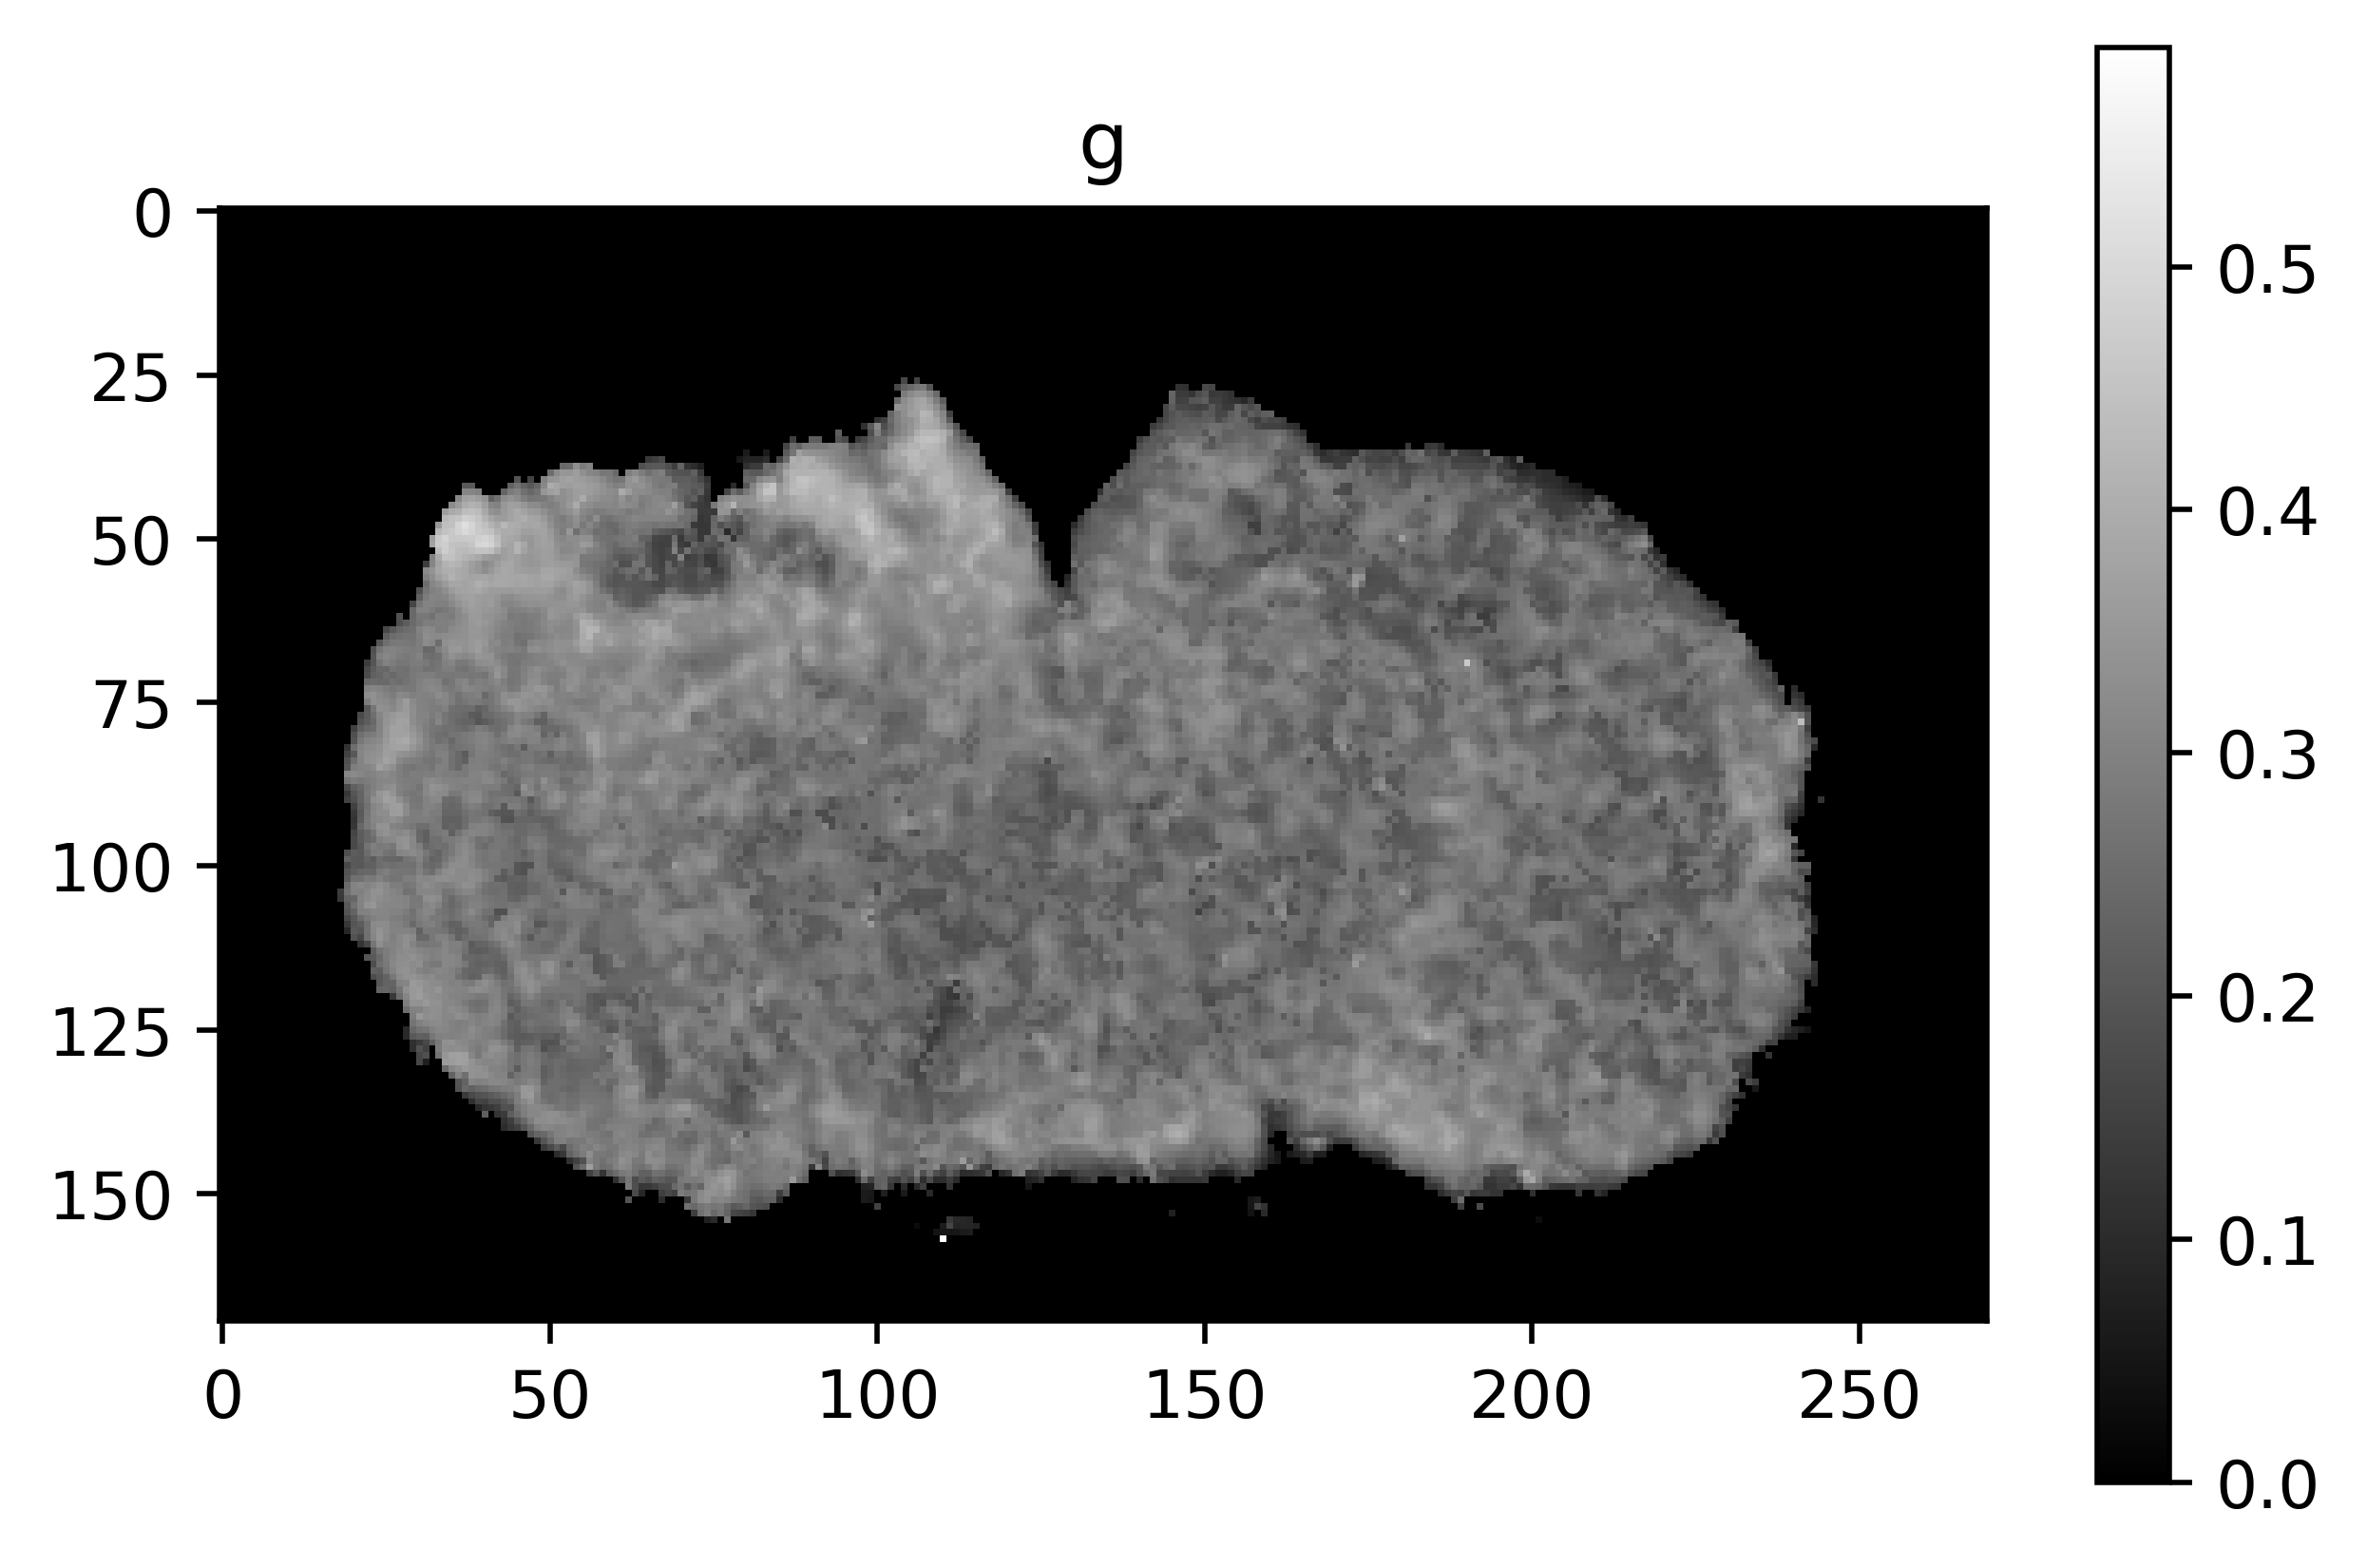

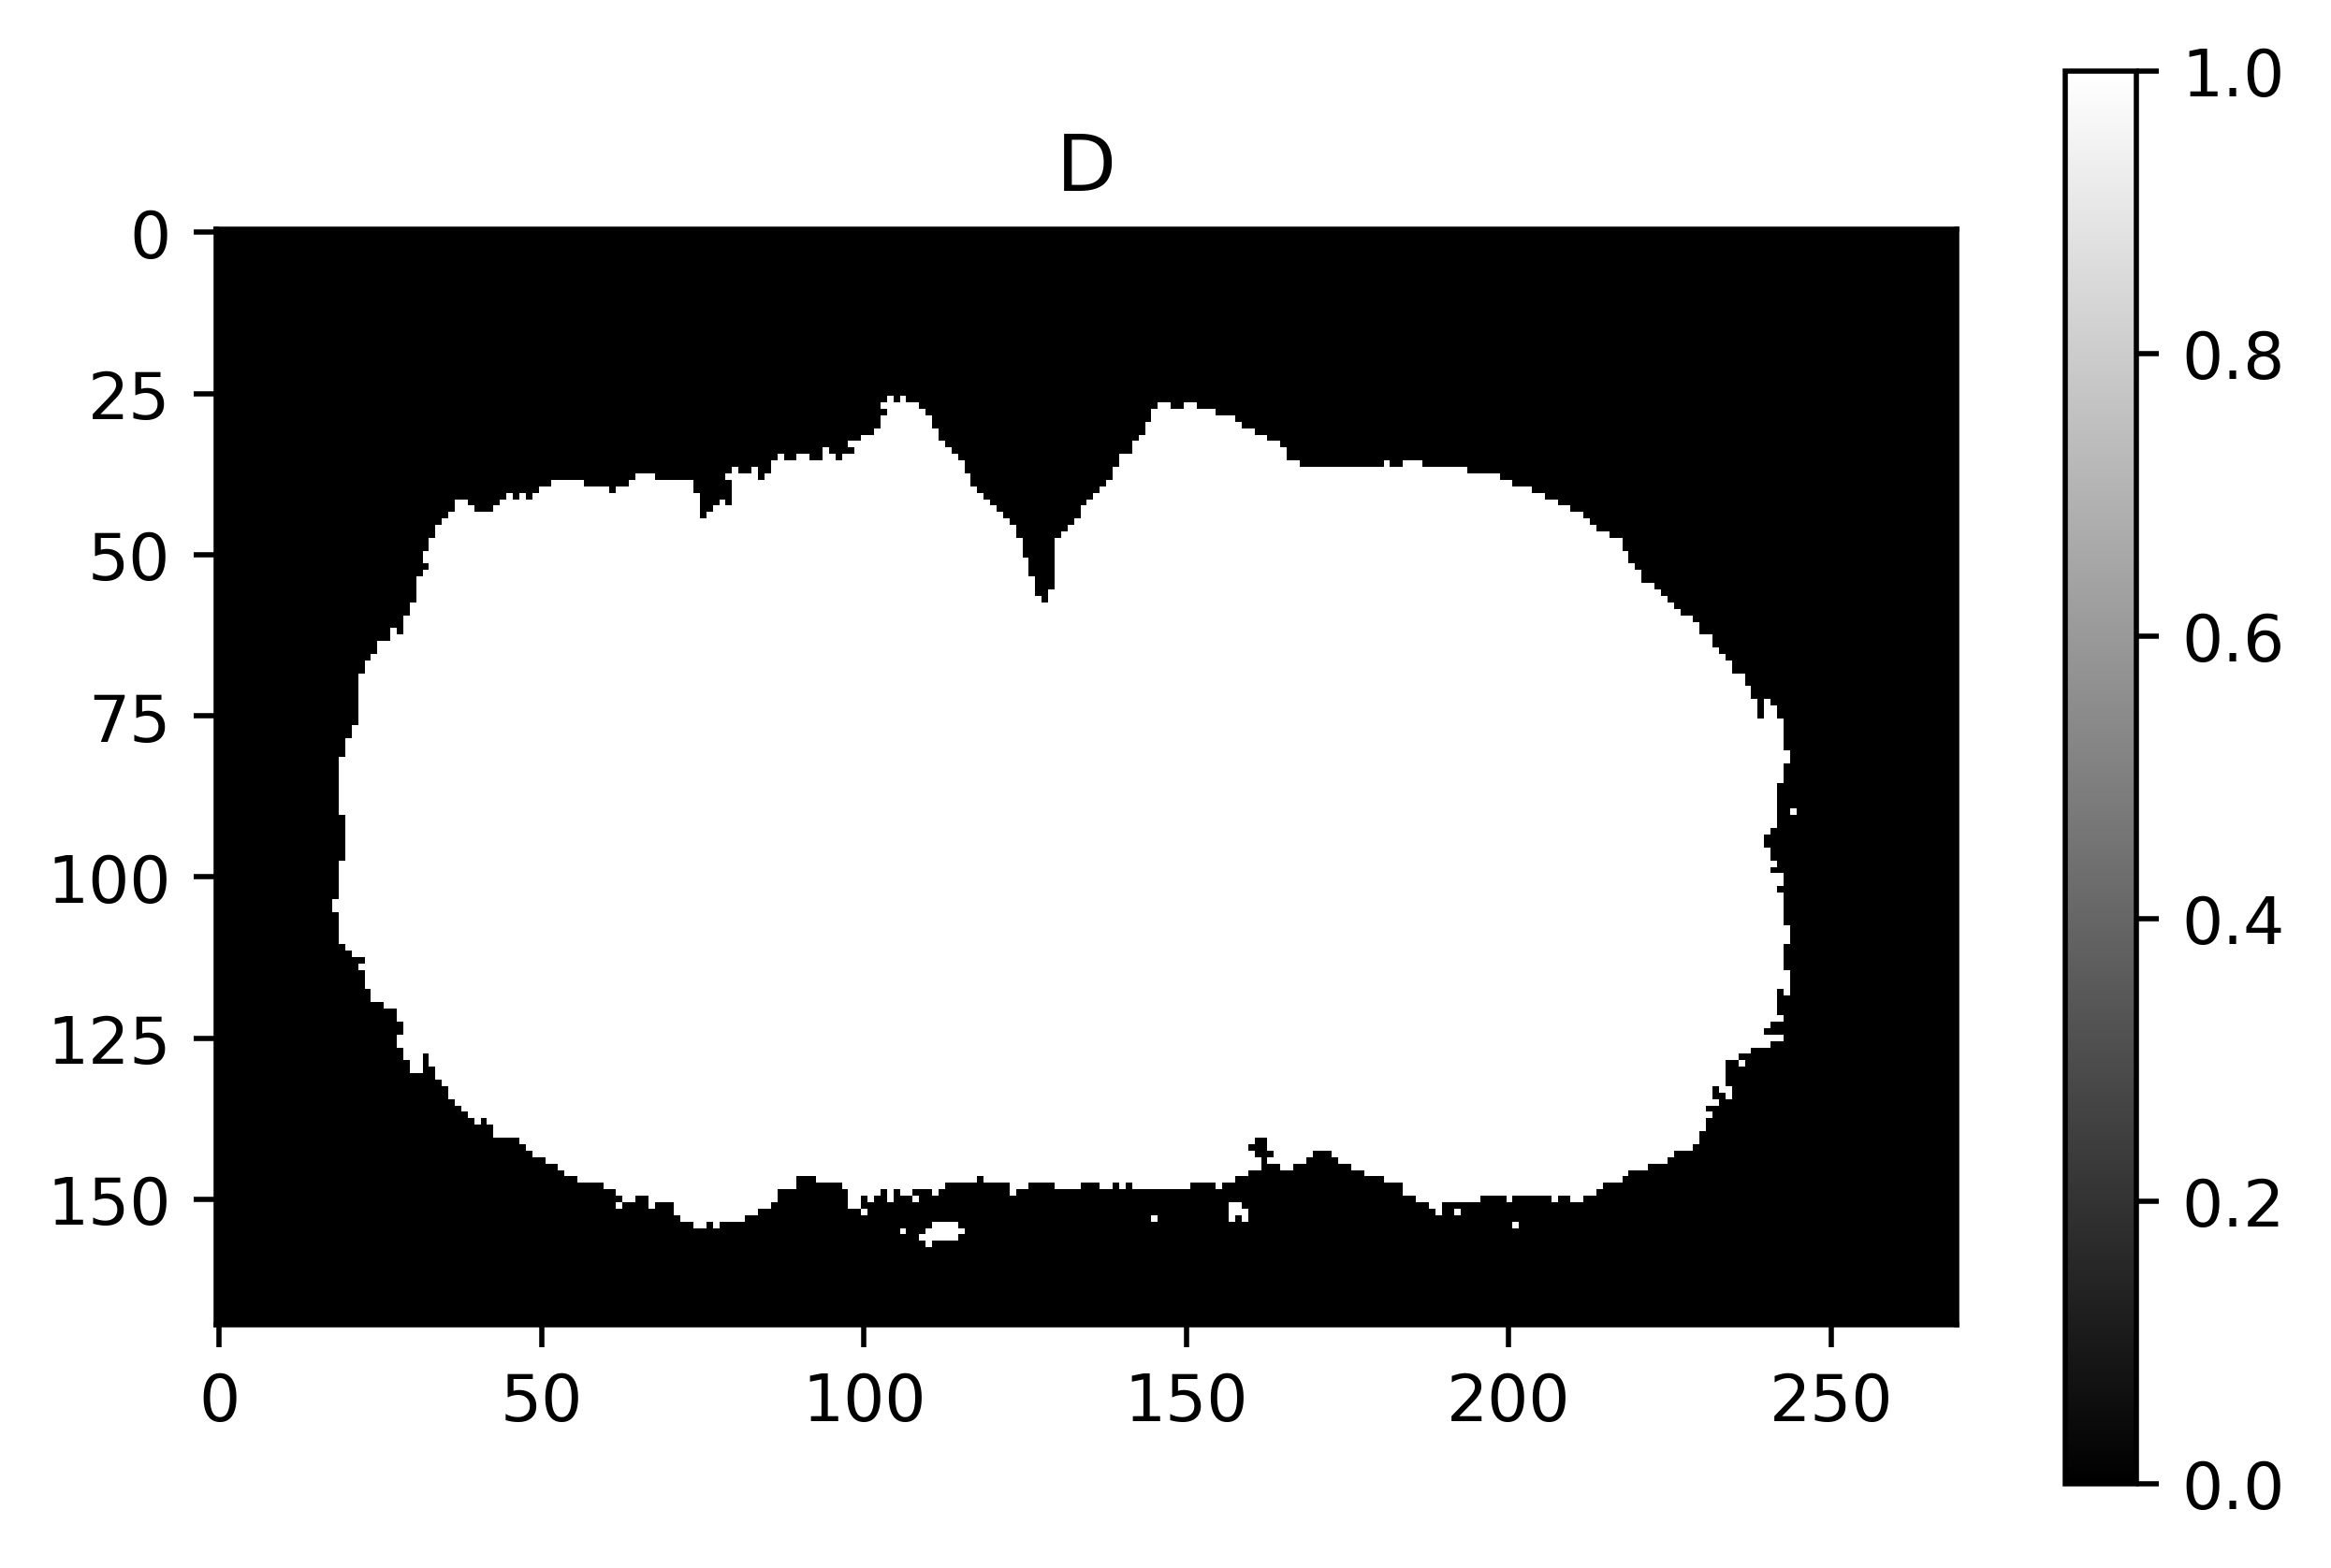

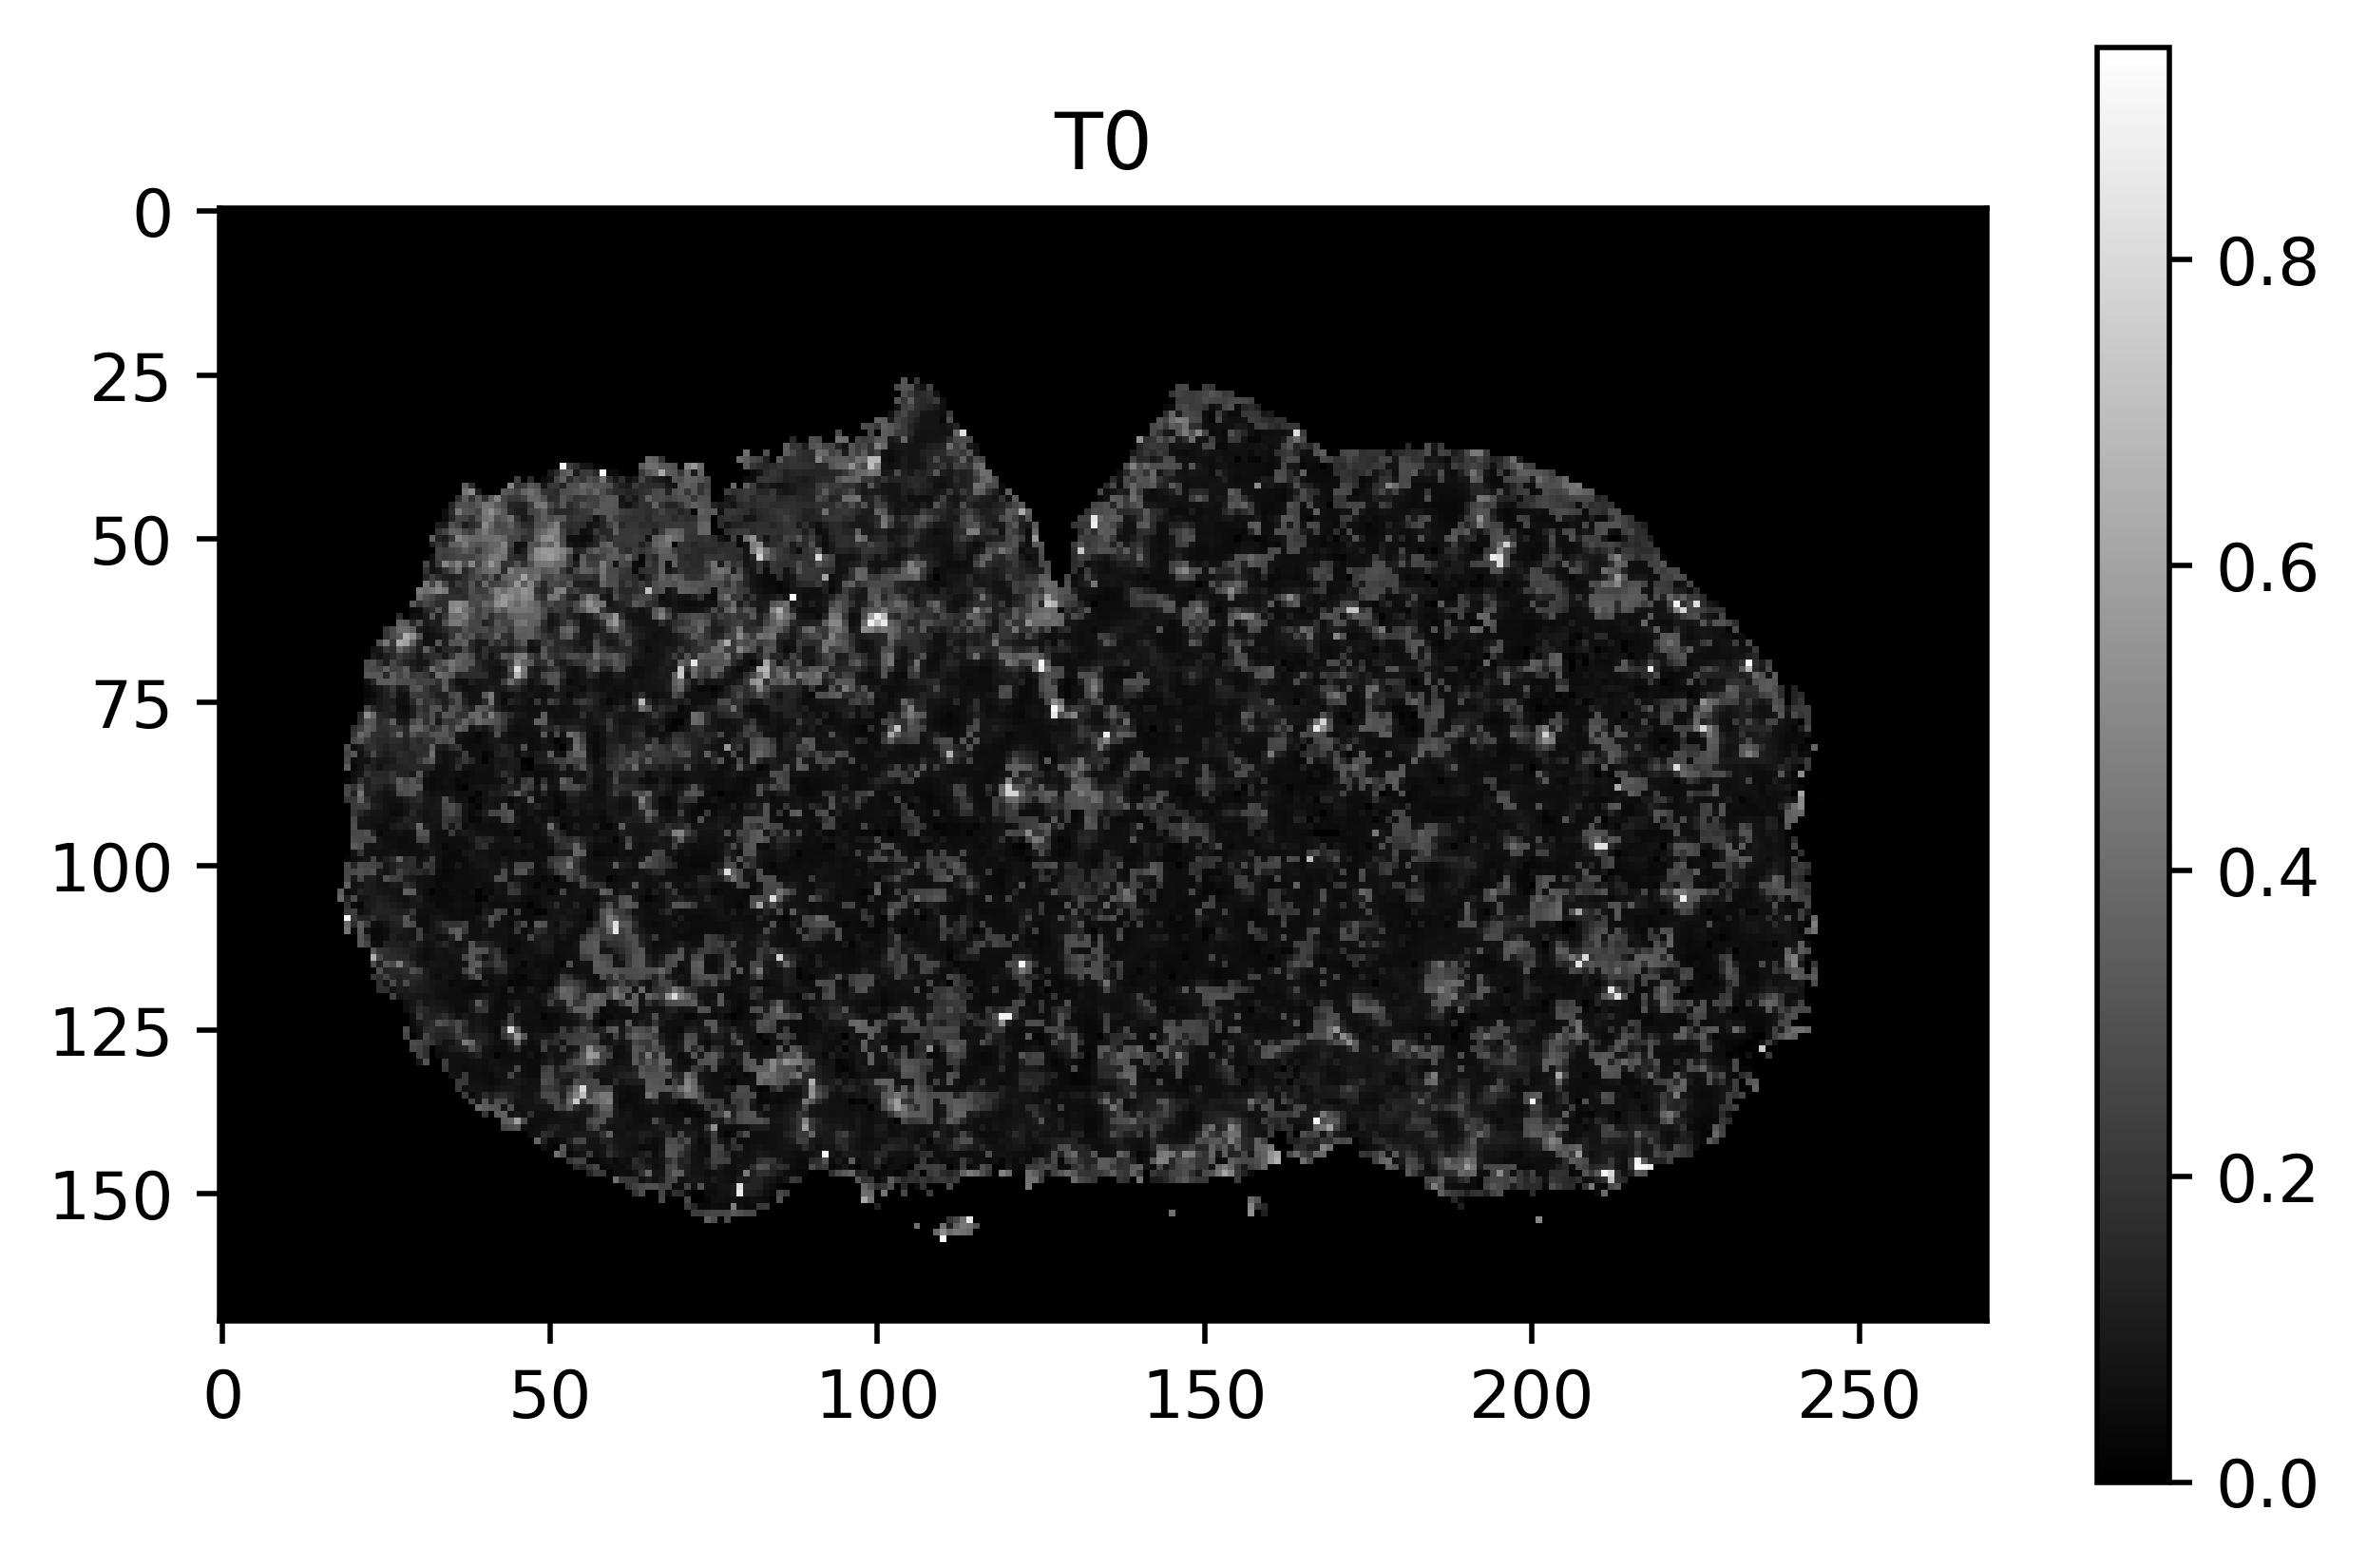

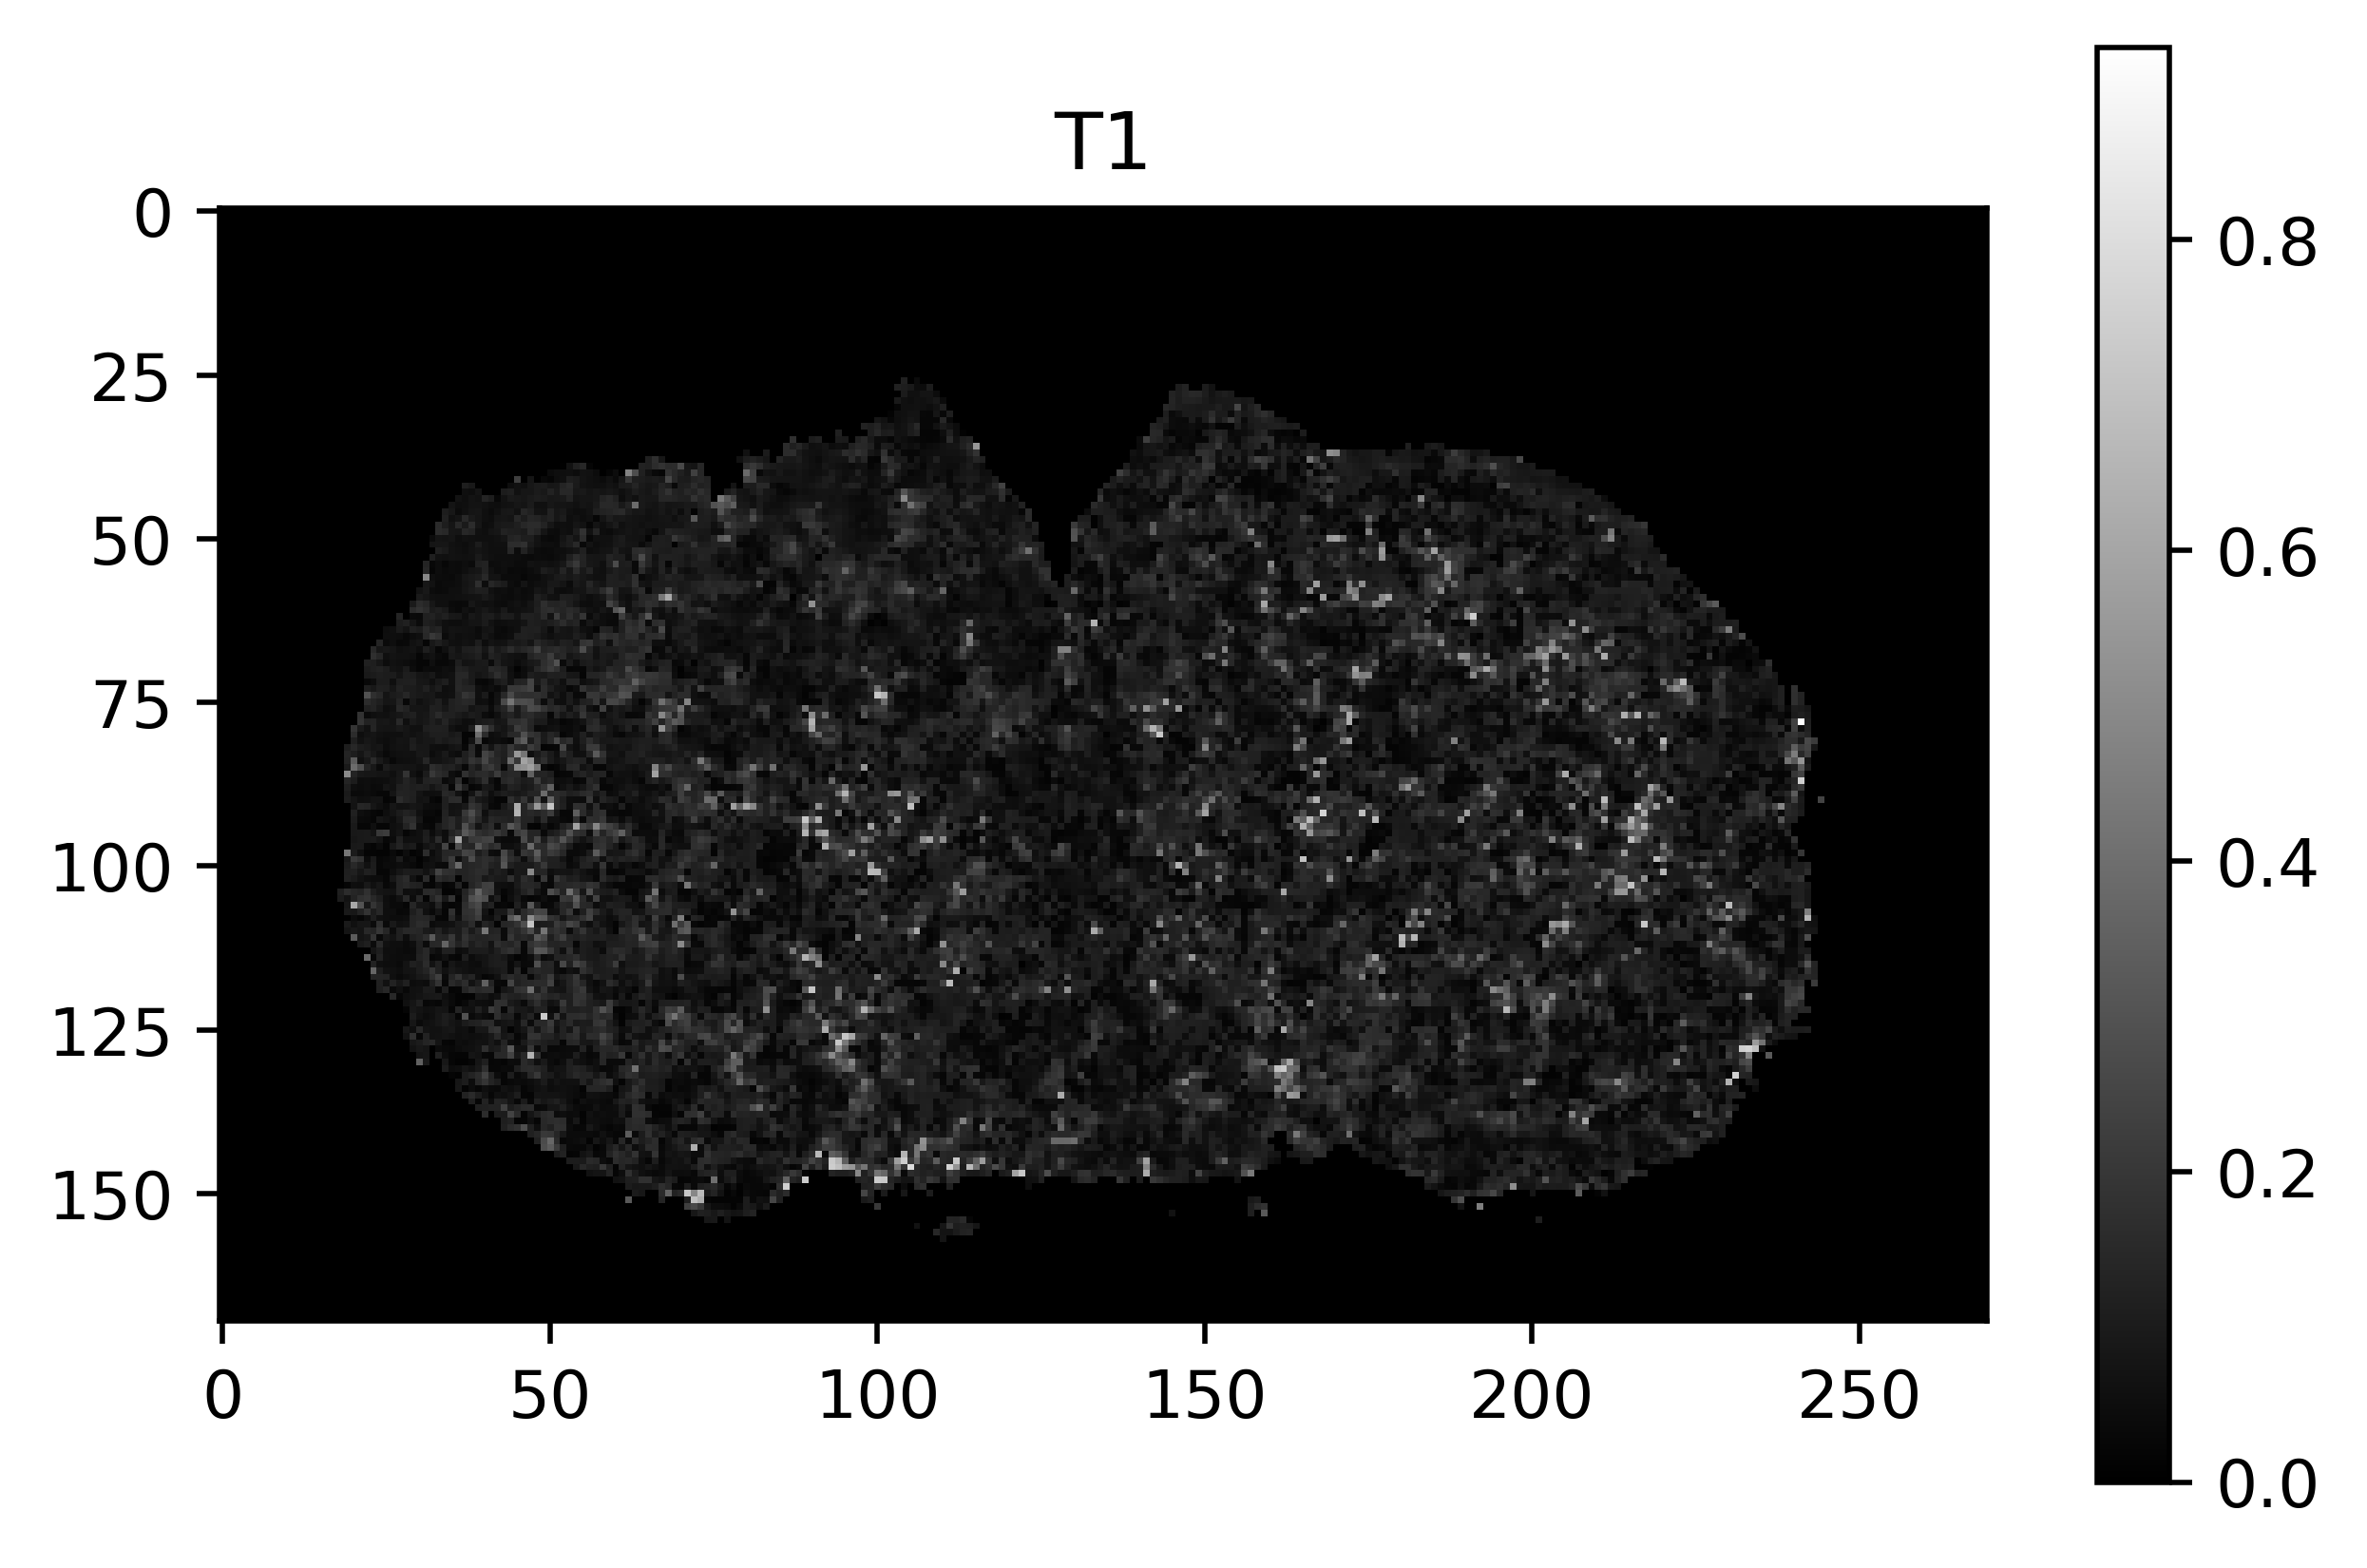

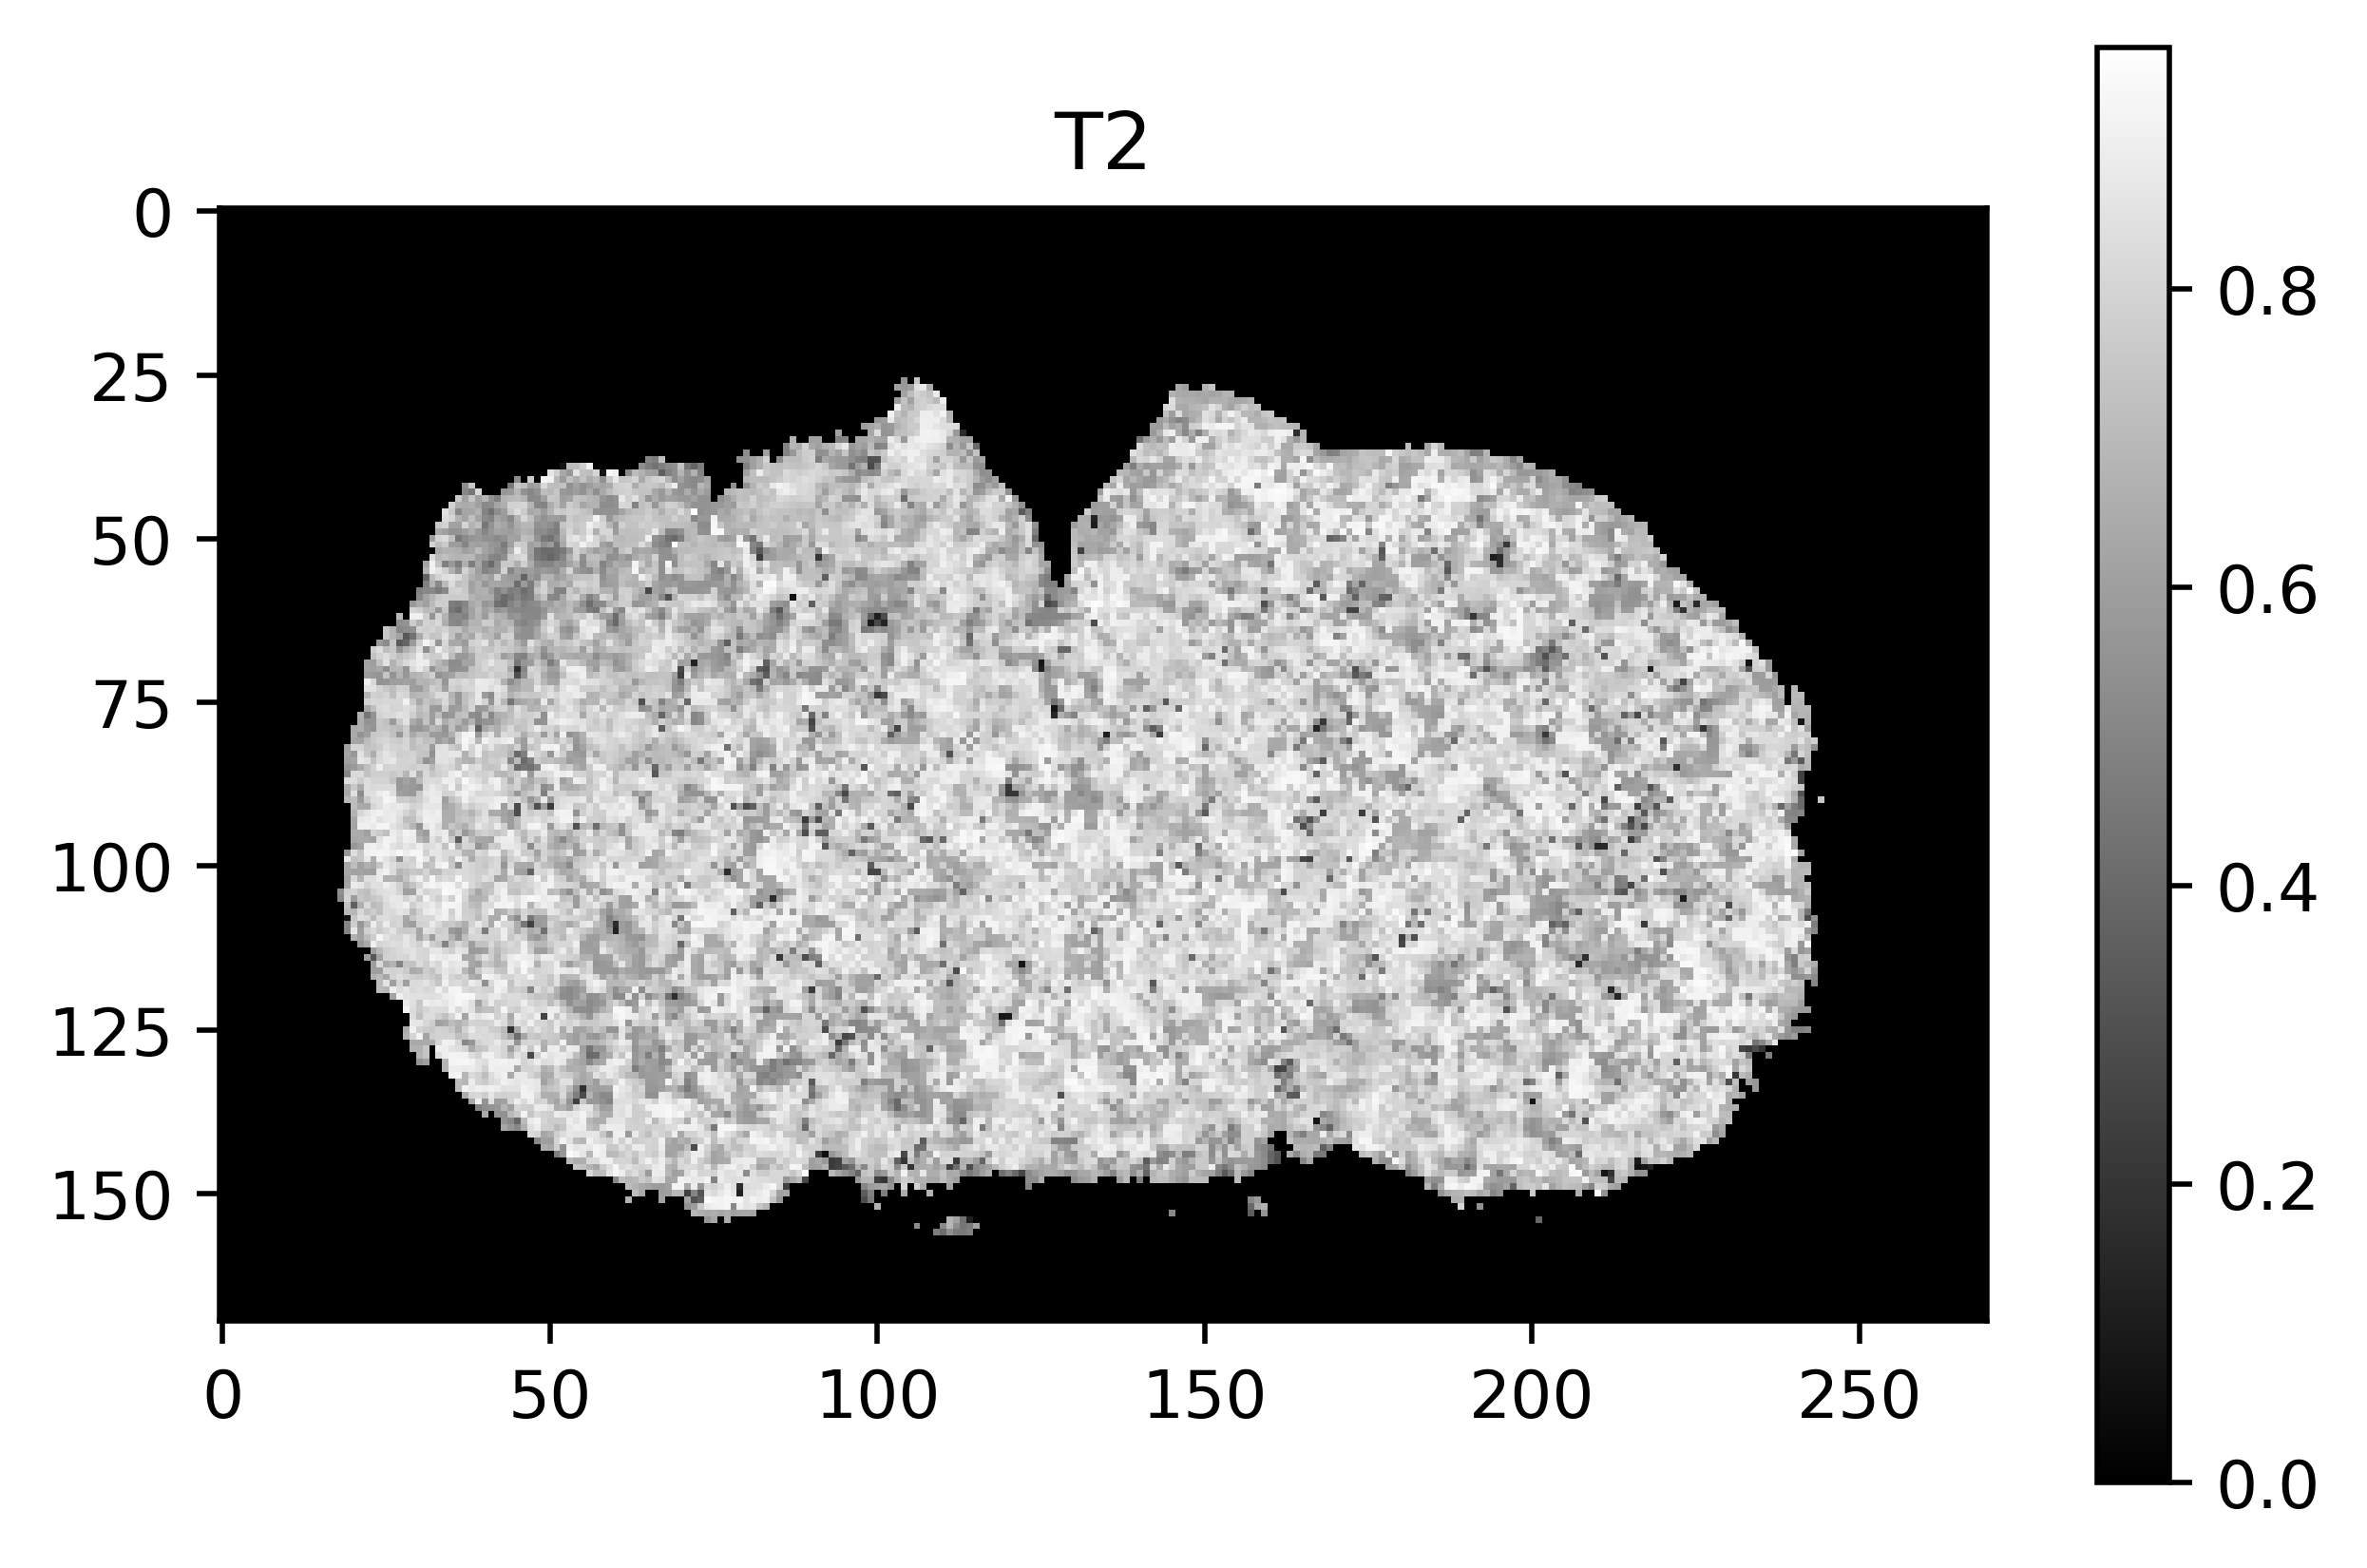

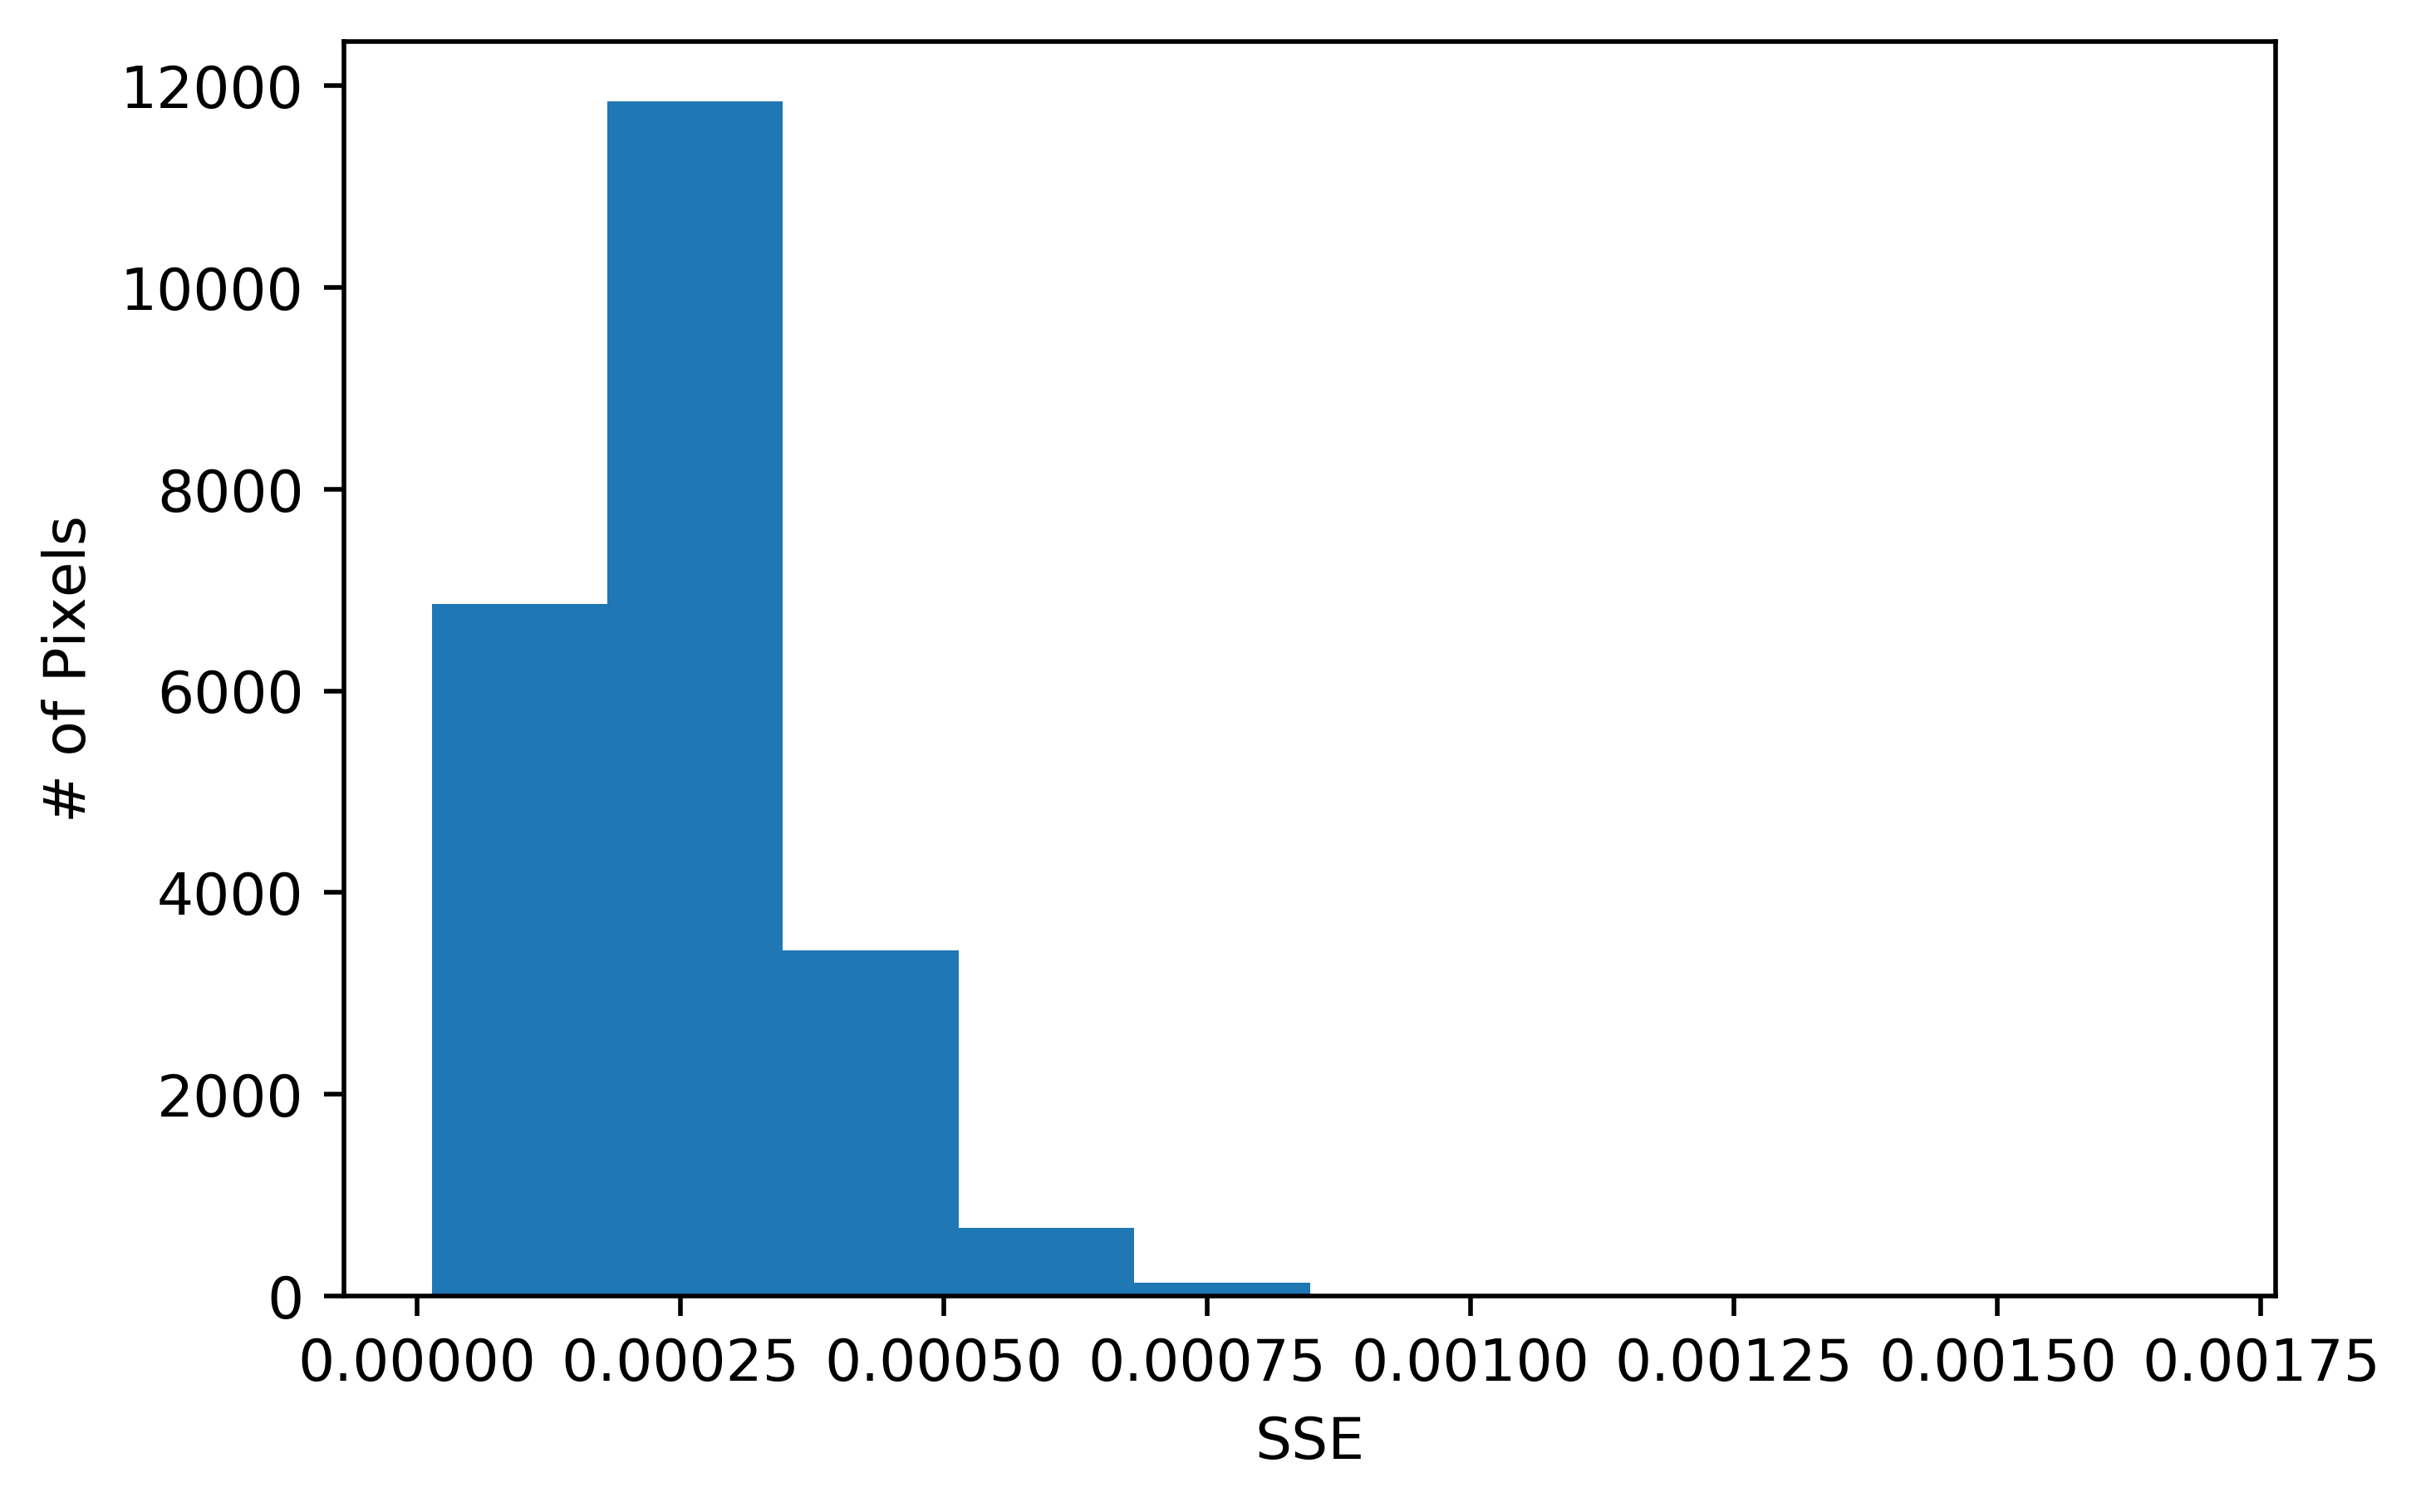

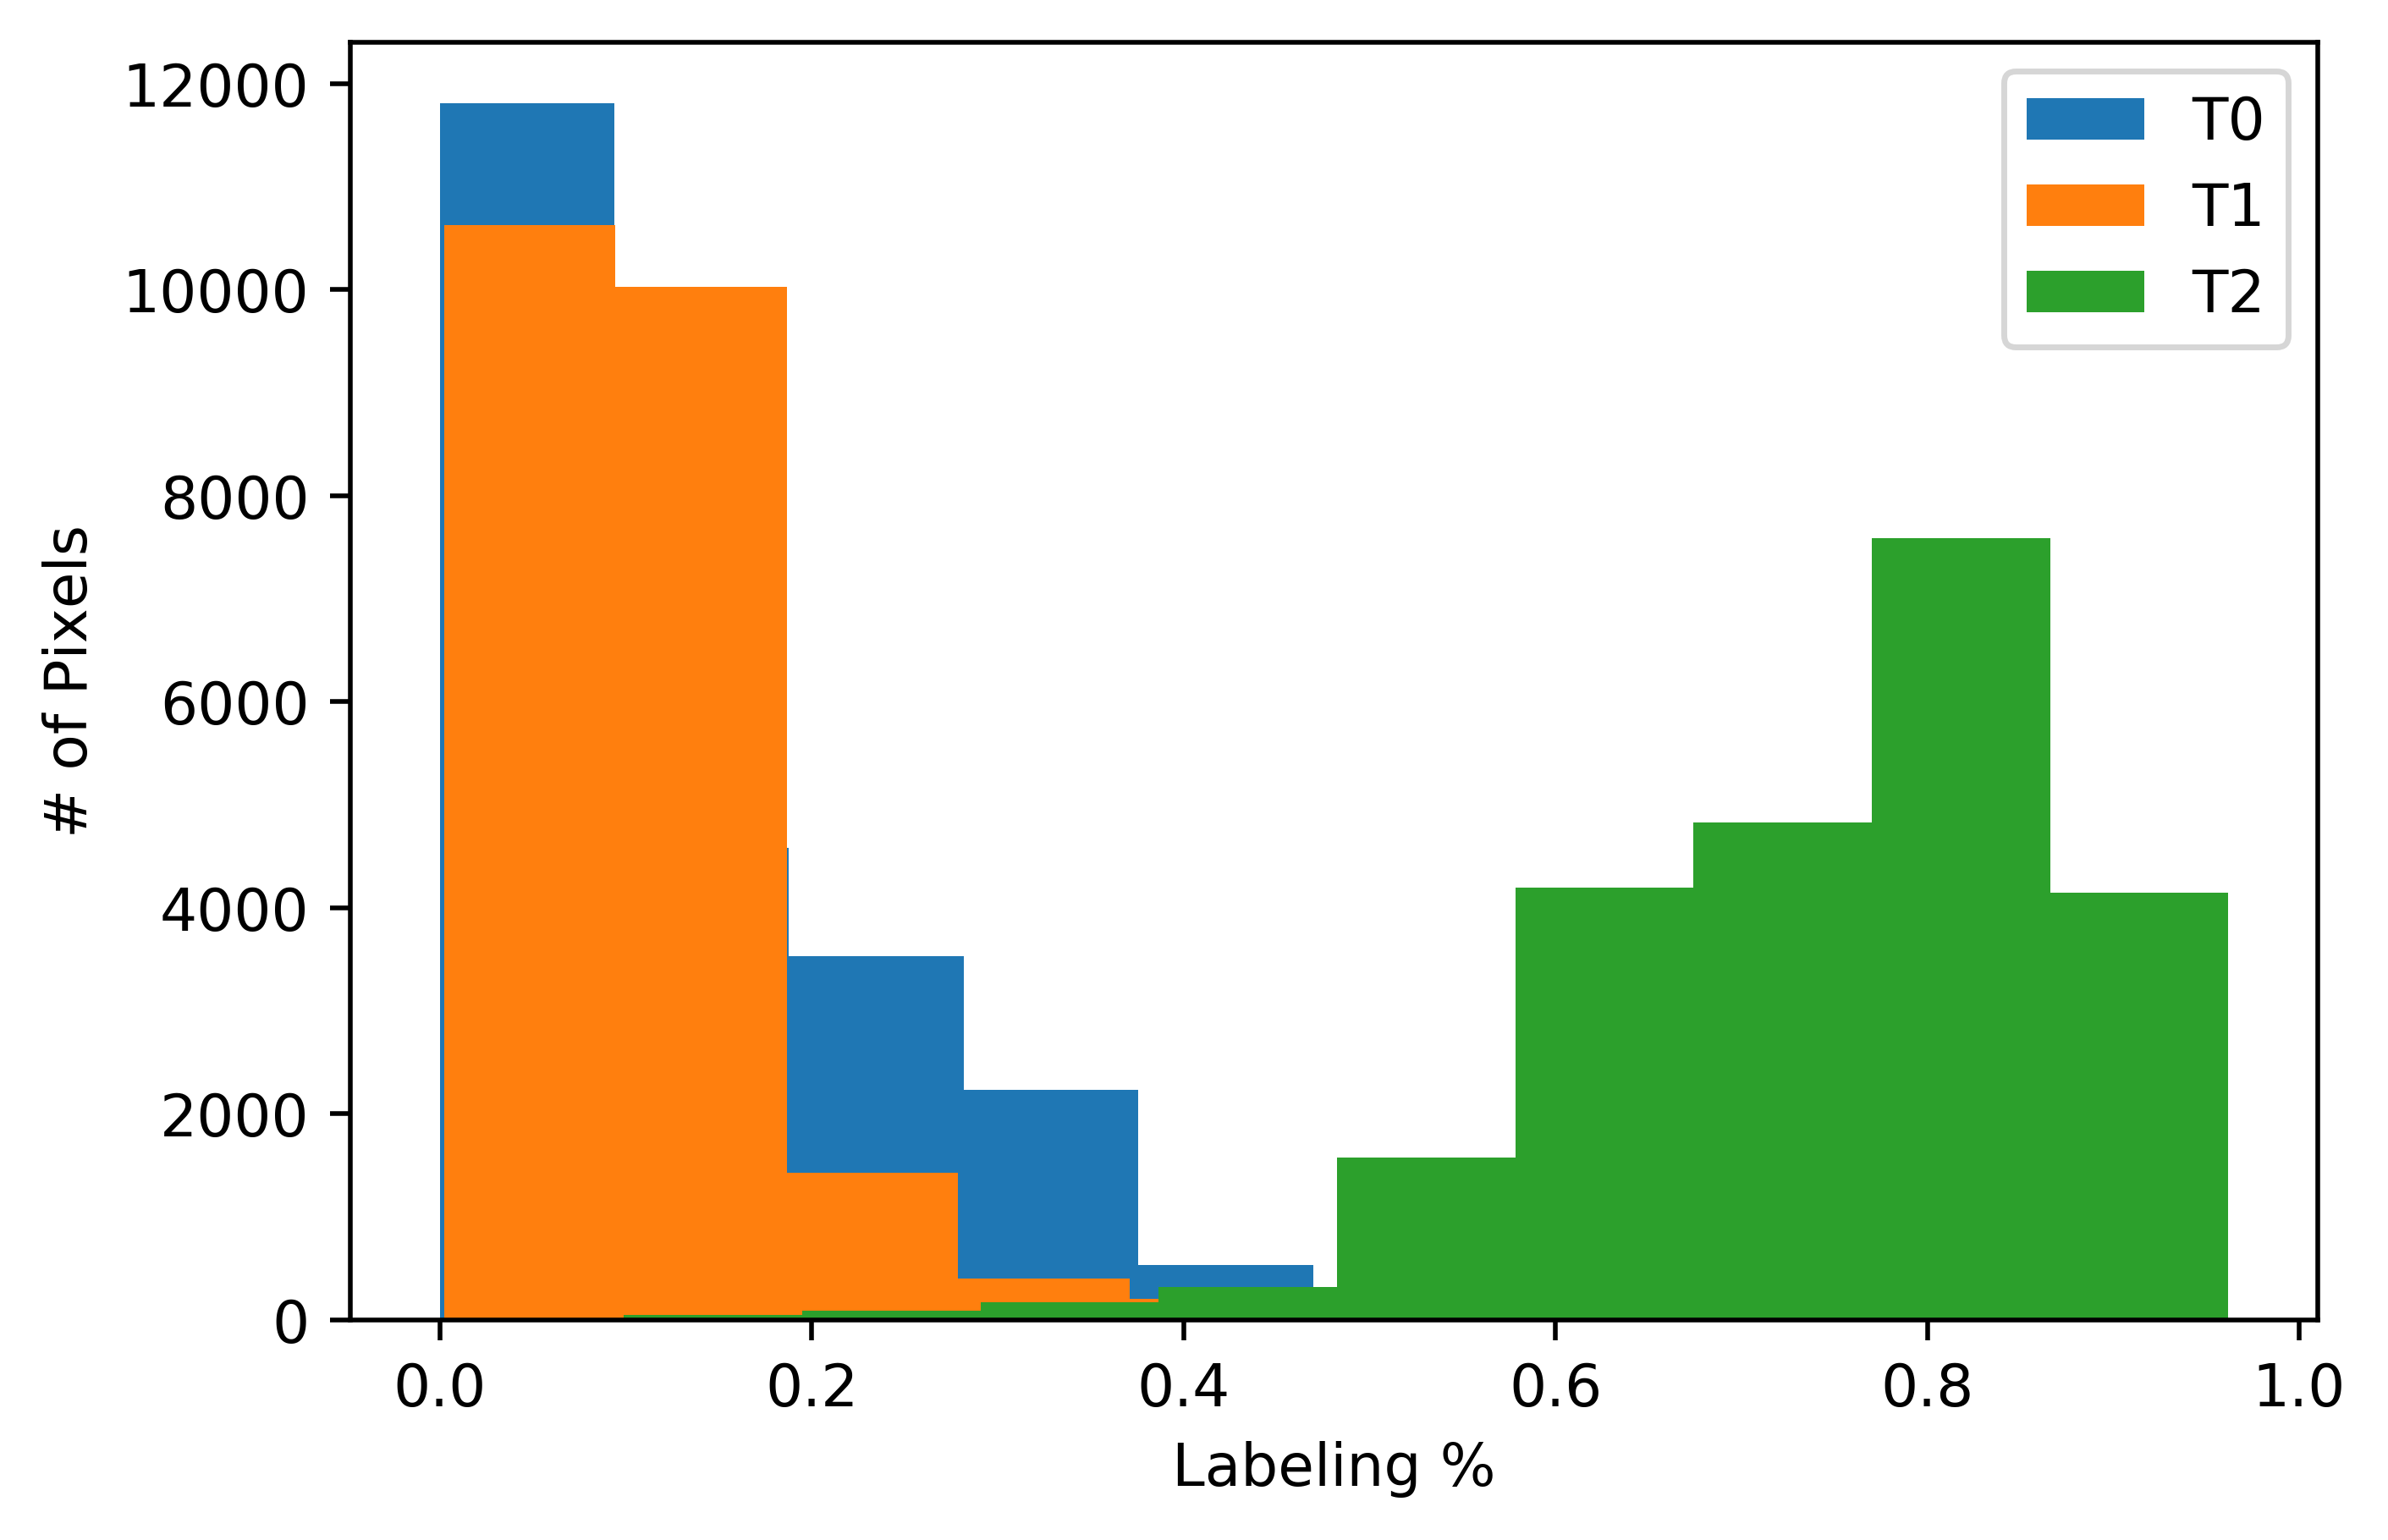

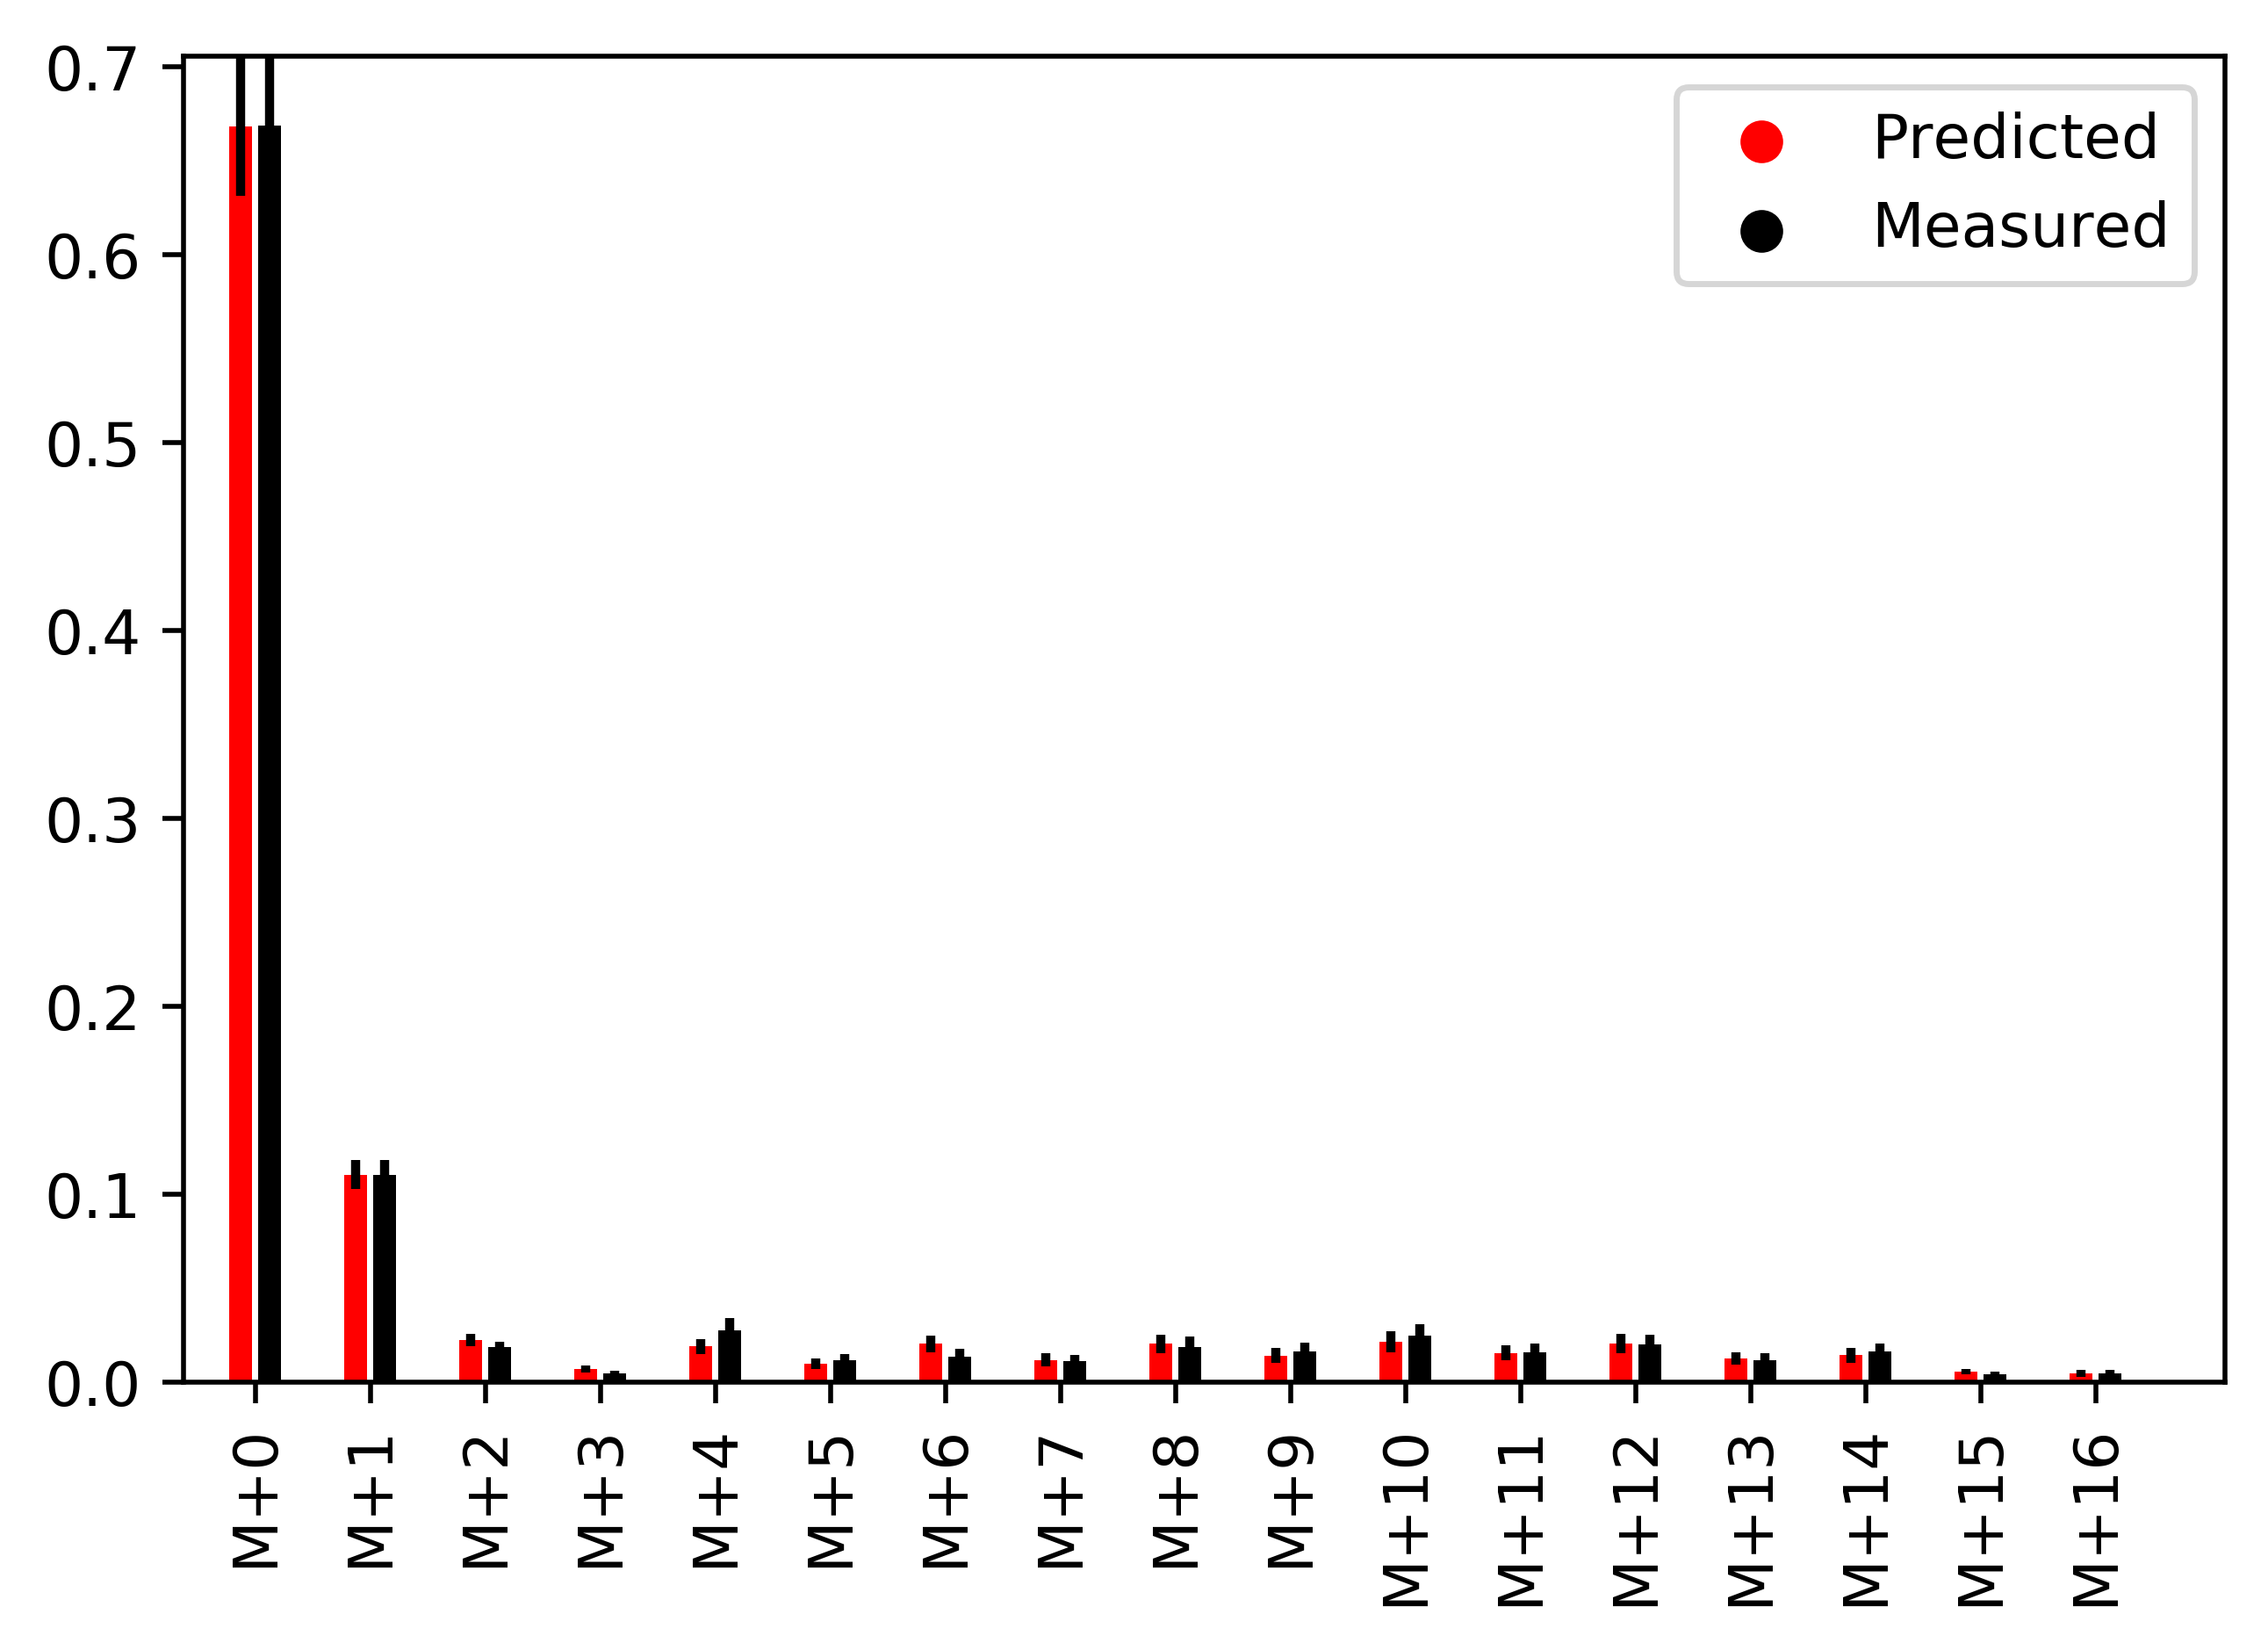

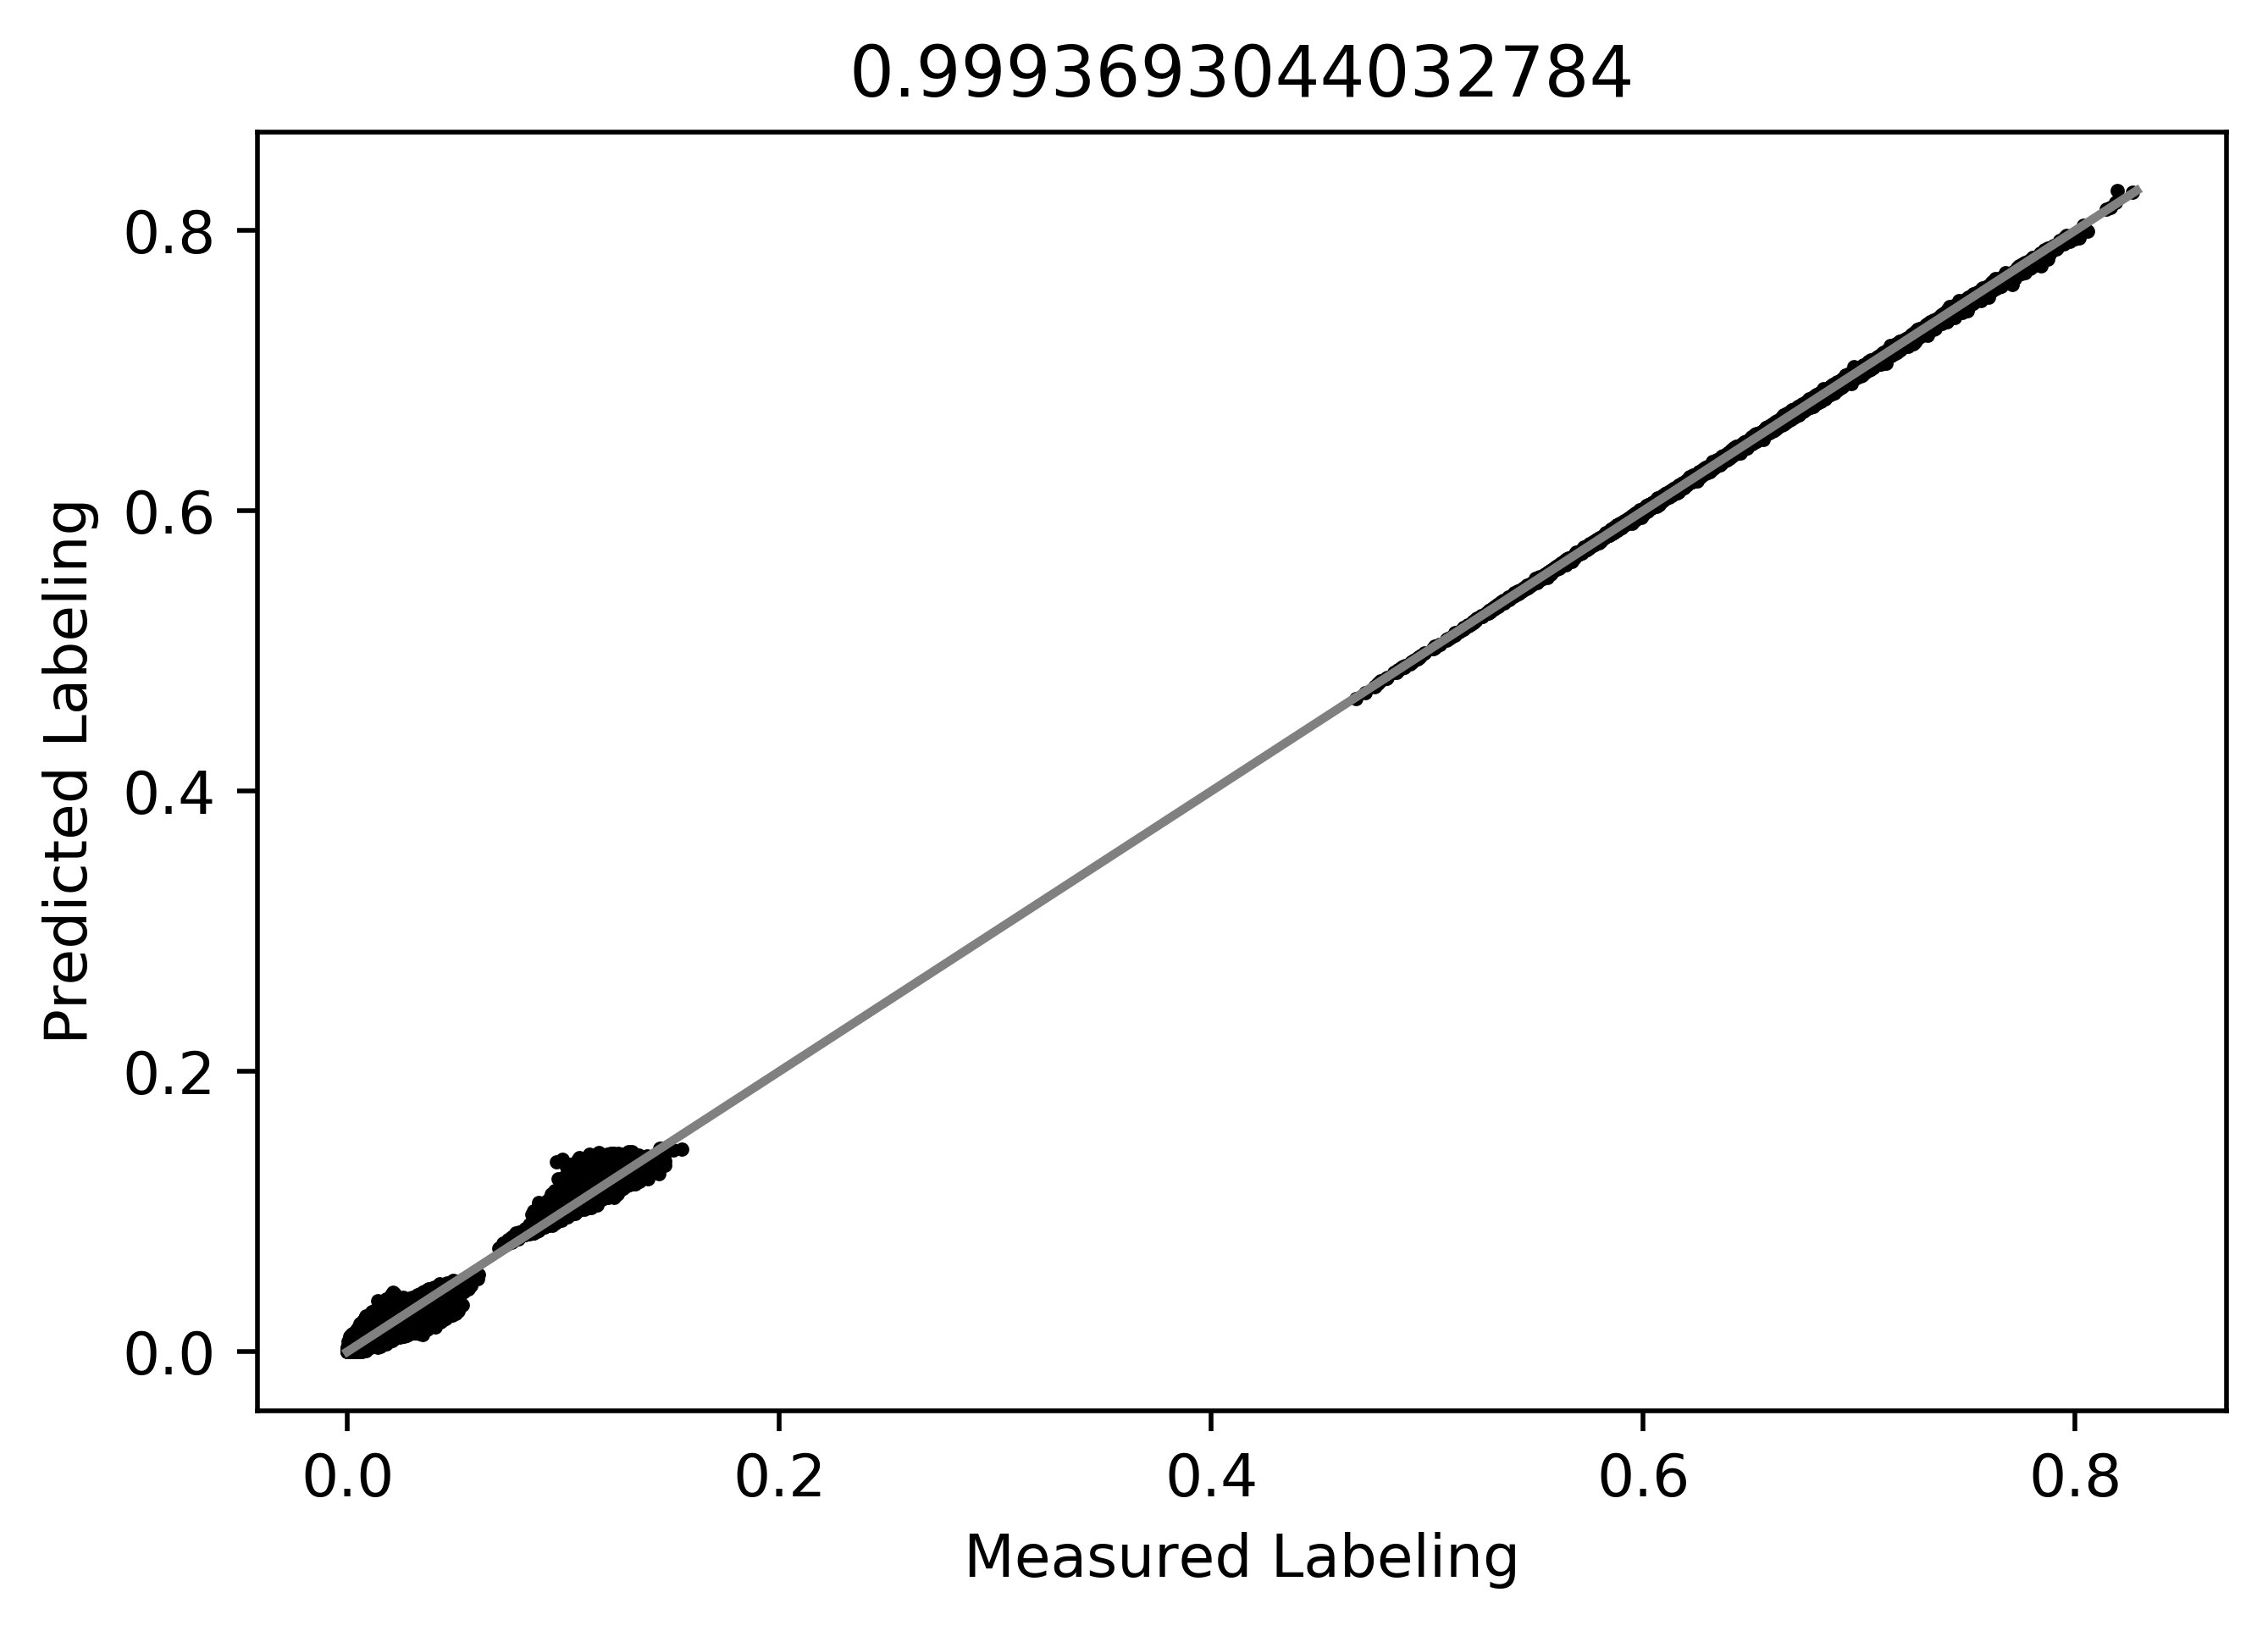

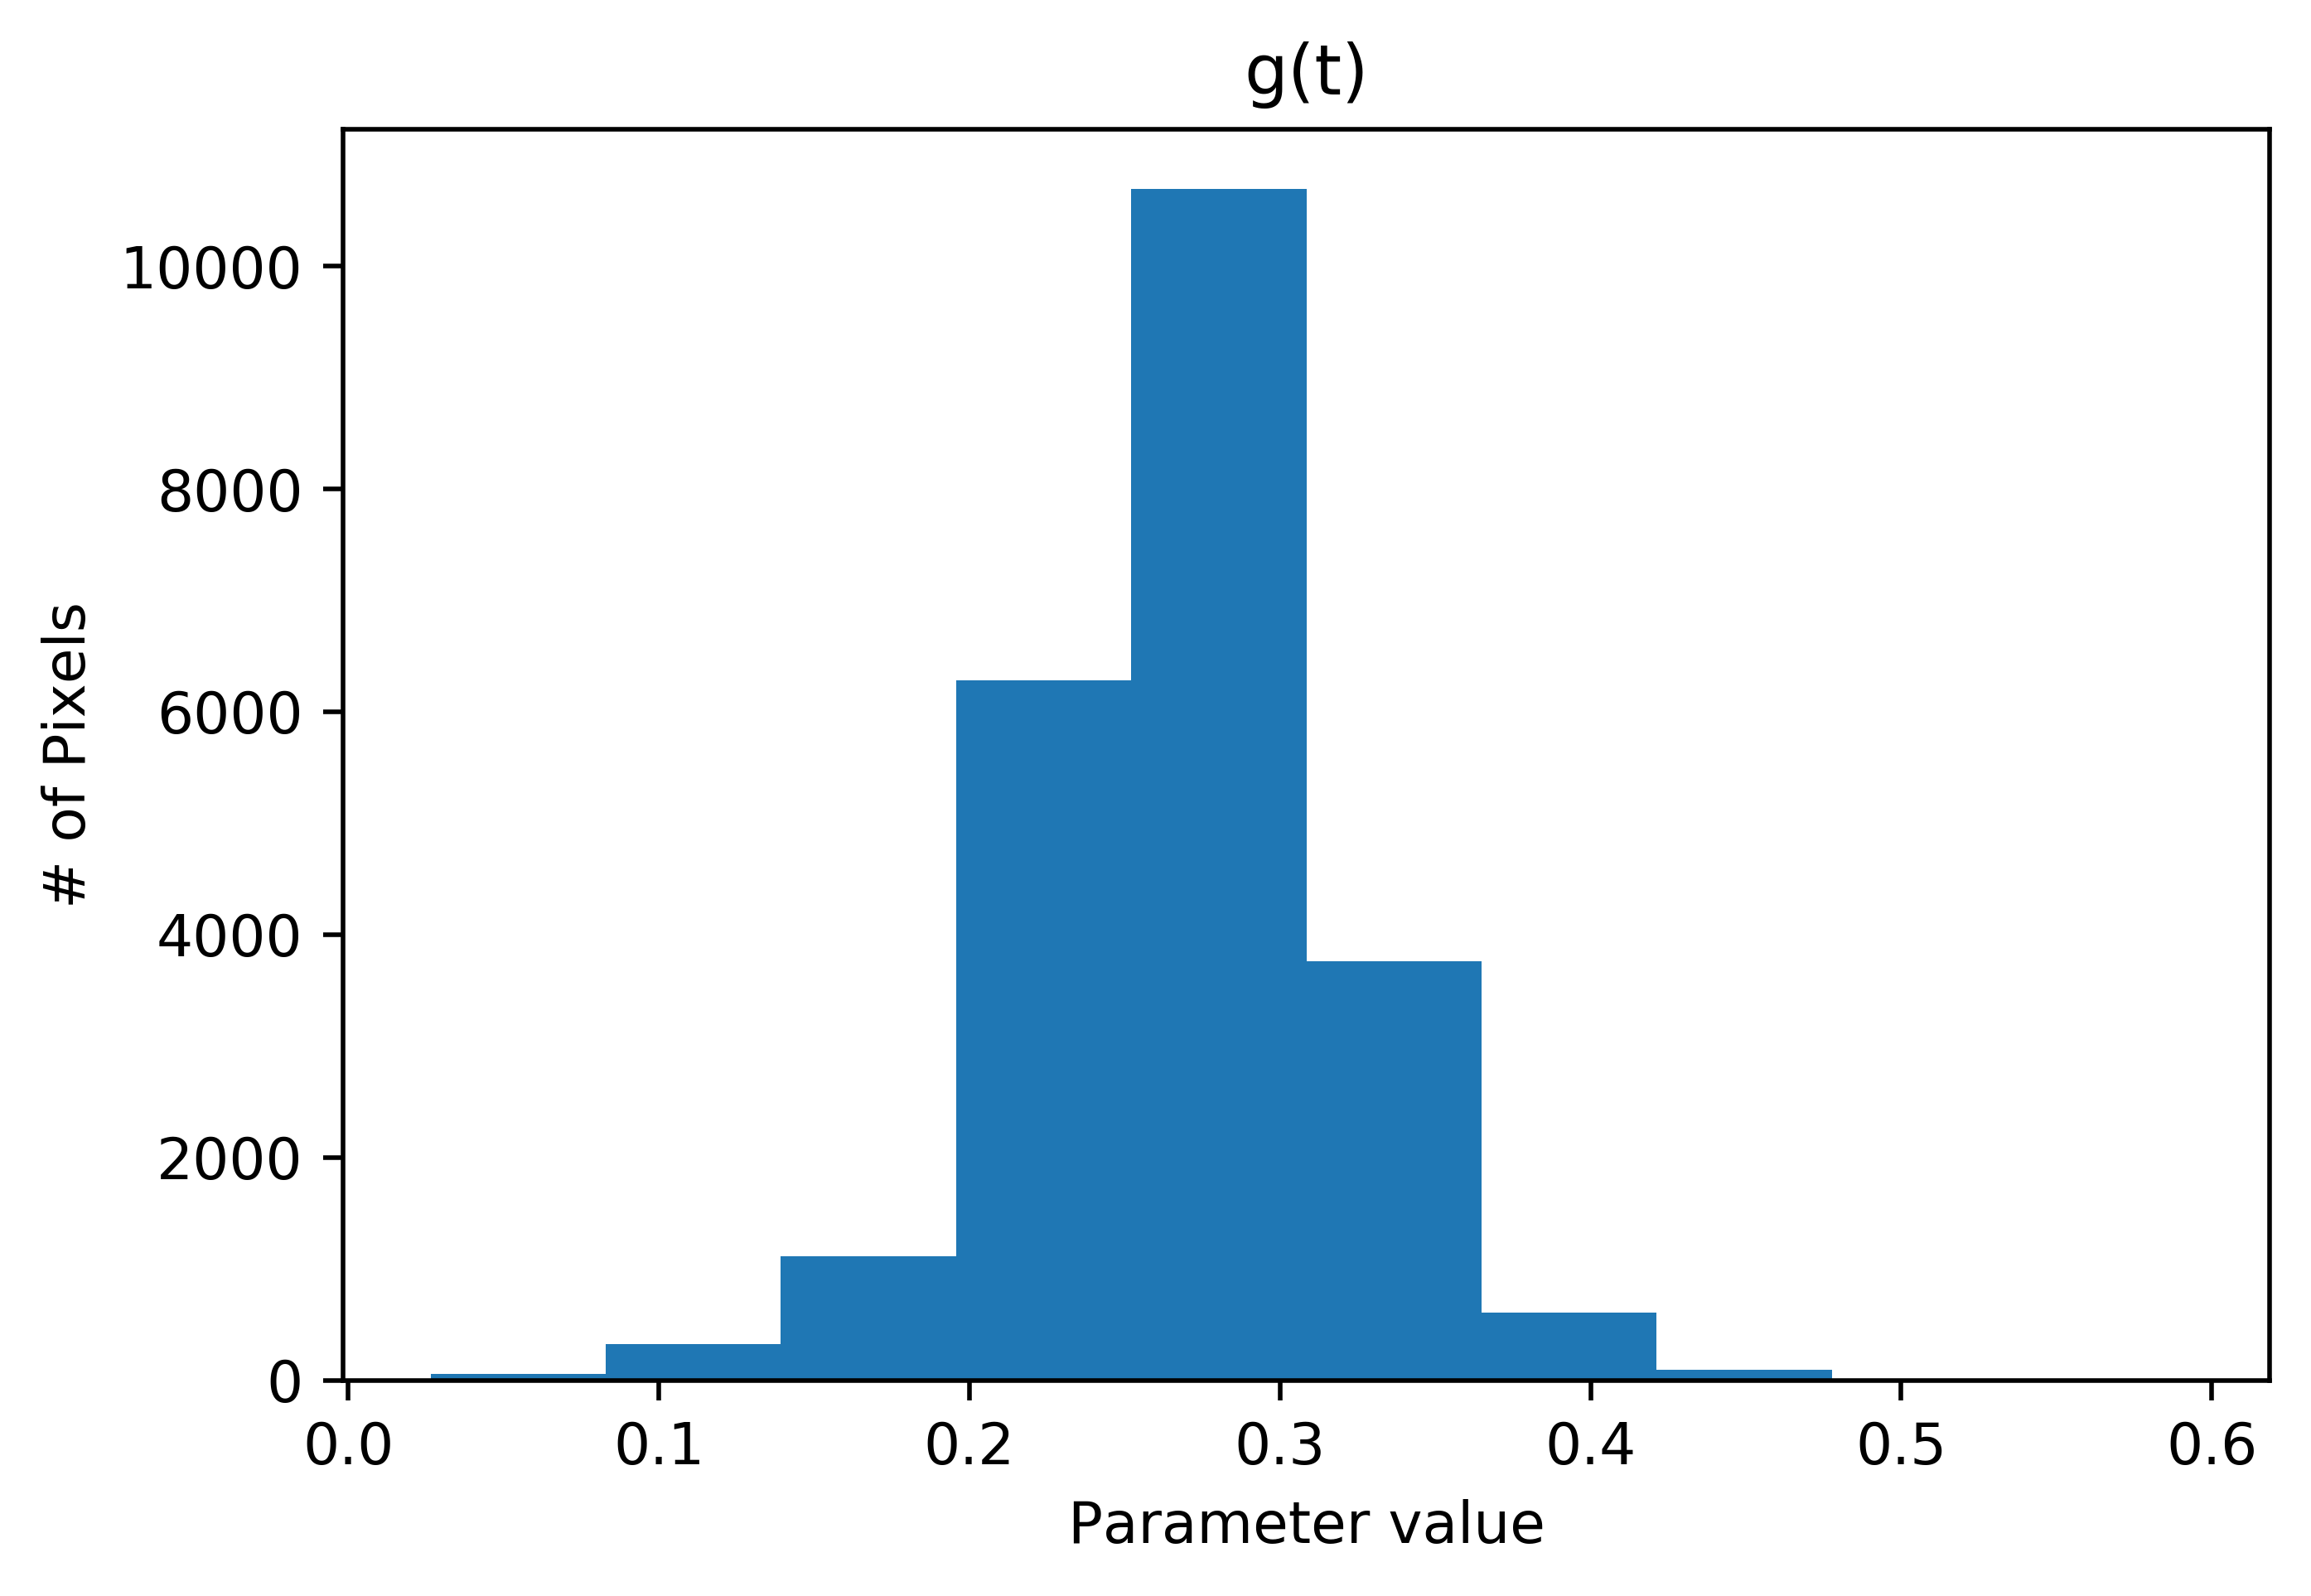

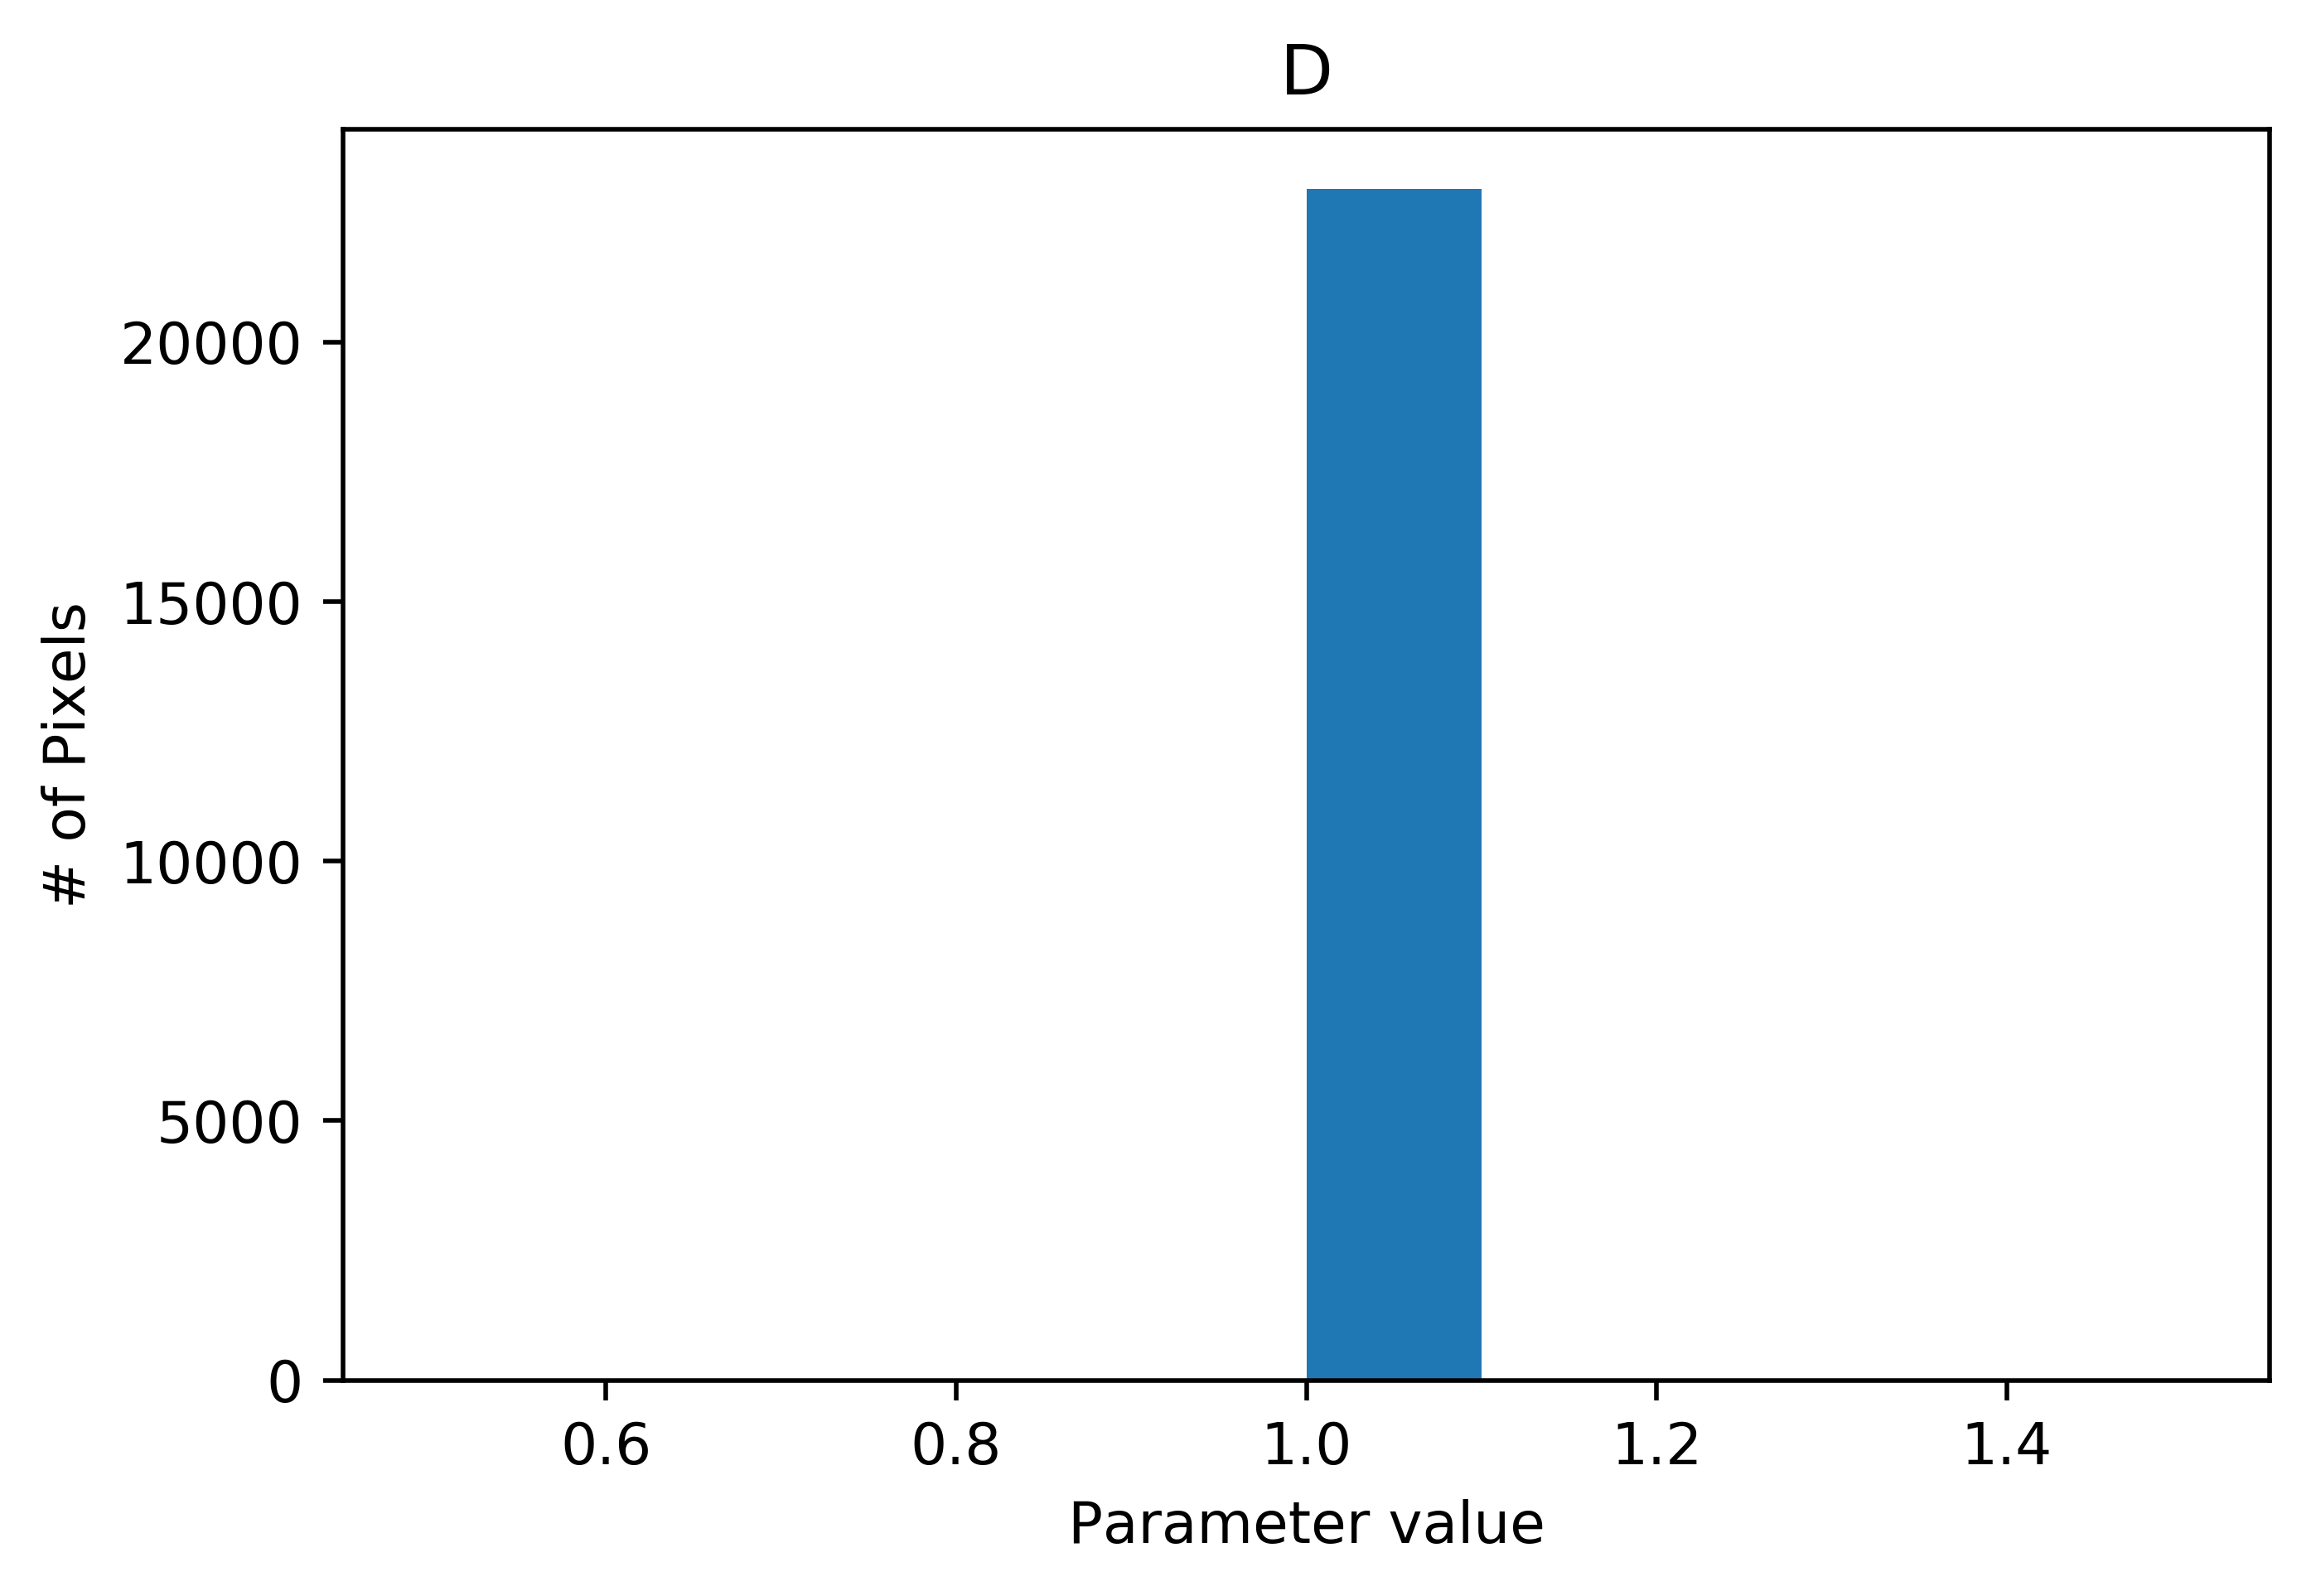

In [10]:
myzip = zipfile.ZipFile(filename.replace(".txt","_results_nonSS_full.zip"),"w")

#show and save images
plt.imshow(fluxImageGFilt,cmap=colormap)
im = Image.fromarray(fluxImageGFilt)
im.save(filename.replace(".txt","") + "_" + formula + "_g_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_g_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + formula + "_g_" + '.tif')
plt.colorbar()
plt.title("g")
plt.figure()
plt.imshow(fluxImageDFilt,cmap=colormap)
im = Image.fromarray(fluxImageDFilt)
im.save(filename.replace(".txt","") + "_" + formula + "_D_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_D_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + formula + "_D_" + '.tif')
plt.title("D")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT0Filt,cmap=colormap)
im = Image.fromarray(fluxImageT0Filt)
im.save(filename.replace(".txt","") + "_" + formula + "_T0_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_T0_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + formula + "_T0_" + '.tif')
plt.title("T0")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT1,cmap=colormap)
im = Image.fromarray(fluxImageT1)
im.save(filename.replace(".txt","") + "_" + formula + "_T1_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_T1_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + formula + "_T1_" + '.tif')
plt.title("T1")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT2Filt,cmap=colormap)
im = Image.fromarray(fluxImageT2Filt)
im.save(filename.replace(".txt","") + "_" + formula + "_T2_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_T2_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + formula + "_T2_" + '.tif')
plt.title("T2")
plt.colorbar()

#plot histogram of sum of squared errors
plt.figure()
plt.hist(errs)
plt.xlabel("SSE")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_sse" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_sse" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_sse" + '.png')

#output found tracer labeling
plt.figure()
T_founds = np.array([t/np.sum(t) for t in T_founds])
T_found = np.mean(T_founds,axis=0)
print("T (mean) = ",T_found)
for t in range(len(T_found)):
    plt.hist(T_founds[:,t],label="T"+str(t))
plt.legend()
plt.xlabel("Labeling %")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_T_hist" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_T_hist" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_T_hist" + '.png')

plt.figure()
x_ind = 0
x_lab = []
meanPred = np.median(P_preds,axis=0)
stdPred = np.std(P_preds,axis=0)
meanTrue = np.median(P_trues,axis=0)
stdTrue = np.std(P_trues,axis=0)
maxY = np.max(np.concatenate((meanPred,meanTrue))) + np.max(np.concatenate((stdPred,stdTrue)))
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)
plt.scatter([-1],[-1],c="red",label="Predicted")
plt.scatter([-1],[-1],c="black",label="Measured")
plt.legend()
plt.ylim((0,maxY))
plt.xlim((-2,x_ind+1))
plt.savefig(filename.replace(".txt","") + "_" + formula + "_pred_meas" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_pred_meas" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_pred_meas" + '.png')

plt.figure()

plt.scatter(np.array(P_trues).flatten(),np.array(P_preds).flatten(),color="black",s=2)
plt.ylabel("Predicted Labeling")
plt.xlabel("Measured Labeling")
plt.title(r2_score(np.array(P_trues).flatten(),np.array(P_preds).flatten()))
plt.plot([0,np.max(np.concatenate((P_trues,P_preds)))],[0,np.max(np.concatenate((P_trues,P_preds)))],color="grey")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_scatter_plot" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_scatter_plot" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_scatter_plot" + '.png')

plt.figure()
plt.hist(fluxImageGFilt[fluxImageGFilt > 0].flatten())
plt.title("g(t)")
plt.xlabel("Parameter value")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_hist_g" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_hist_g" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_hist_g" + '.png')

plt.figure()
plt.hist(fluxImageDFilt[fluxImageDFilt > 0].flatten())
plt.title("D")
plt.xlabel("Parameter value")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_hist_d" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_hist_d" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_hist_d" + '.png')

myzip.close()